Loading ADHD EEG dataset...
Original dataset shape: (2166383, 21)
Columns: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Class', 'ID']
Memory usage: 568.76 MB

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2166383 entries, 0 to 2166382
Data columns (total 21 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Fp1     float64
 1   Fp2     float64
 2   F3      float64
 3   F4      float64
 4   C3      float64
 5   C4      float64
 6   P3      float64
 7   P4      float64
 8   O1      float64
 9   O2      float64
 10  F7      float64
 11  F8      float64
 12  T7      float64
 13  T8      float64
 14  P7      float64
 15  P8      float64
 16  Fz      float64
 17  Cz      float64
 18  Pz      float64
 19  Class   object 
 20  ID      object 
dtypes: float64(19), object(2)
memory usage: 347.1+ MB
None

Missing values per column:
Fp1      0
Fp2      0
F3       0
F4       0
C3       0
C4       0
P3  

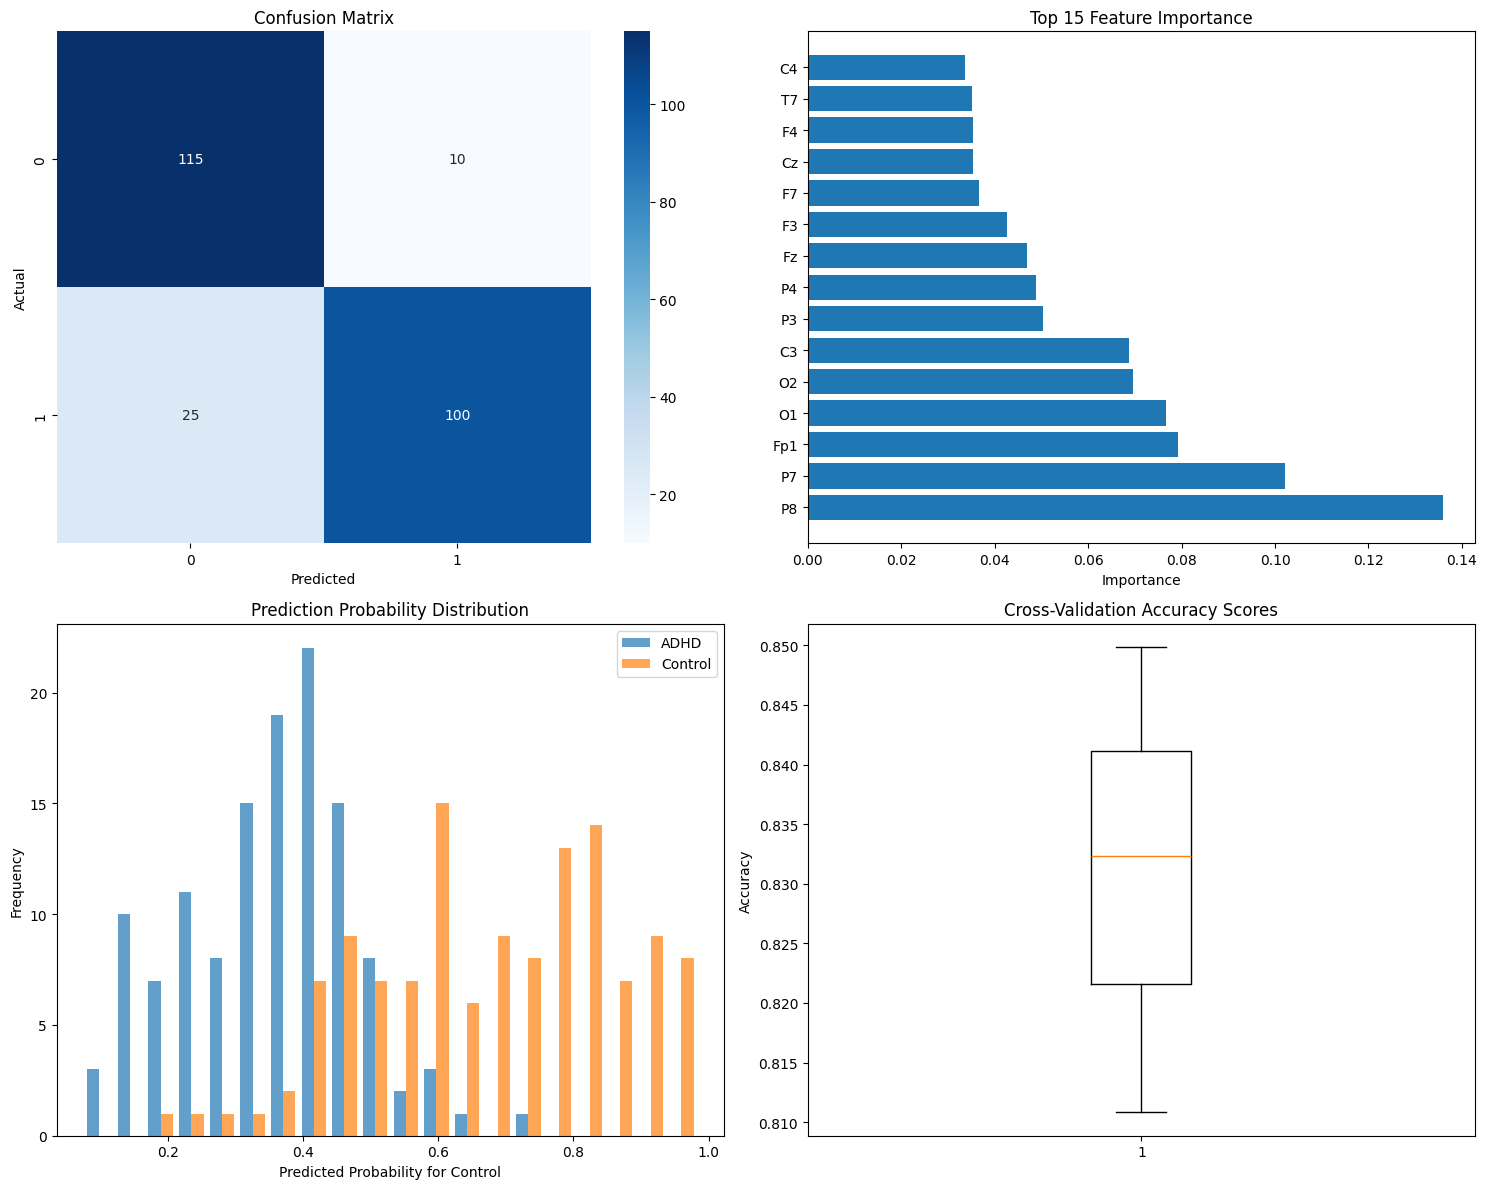


PIPELINE SUMMARY
Original dataset size: 10,000 rows
After temporal downsampling: 1,250 rows
Size reduction: 87.5%
Effective sampling rate: 16.0 Hz (16 Hz)
Number of features: 19
Preprocessing: FAST Mean Imputation + Z-score Normalization
Model: FAST Random Forest (50 trees, max_depth=10)
Classes: {0: 'ADHD', 1: 'Control'}
Final test accuracy: 0.8600
Final test AUC: 0.9251

SPEED OPTIMIZATIONS APPLIED:
✓ Truncated to max 10,000 rows
✓ Aggressive downsampling (factor=8)
✓ Additional sampling to 5,000 rows max
✓ Mean imputation instead of KNN
✓ 50 trees instead of 200+
✓ Fixed hyperparameters (no grid search)
✓ 3-fold CV instead of 5-fold
✓ Limited tree depth (max_depth=10)

Results summary dictionary created for further analysis.
Use 'results_summary' variable to access all results programmatically.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# load
print("Loading ADHD EEG dataset...")
df = pd.read_csv('adhdata.csv')

print(f"Original dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

#basic info
print("\nDataset Info:")
print(df.info())
print(f"\nMissing values per column:")
print(df.isnull().sum())

# Identify feature and target columns FIRST
def identify_columns(df):
    """
    Identify EEG feature columns and target column
    """
    # Common EEG channel names
    eeg_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'Fz', 'C3', 'C4', 'Cz',
                   'P3', 'P4', 'Pz', 'T3', 'T4', 'T5', 'T6', 'O1', 'O2']

    # Find feature columns (EEG channels or numerical columns)
    feature_cols = []
    for col in df.columns:
        if any(channel in col.upper() for channel in eeg_channels):
            feature_cols.append(col)
        elif df[col].dtype in ['float64', 'int64'] and col.lower() not in ['label', 'target', 'class', 'subject_id', 'subject']:
            feature_cols.append(col)

    # Find target column
    target_col = None
    for col in ['label', 'target', 'class', 'Label', 'Target', 'Class']:
        if col in df.columns:
            target_col = col
            break

    # If no obvious target column, check for binary columns
    if target_col is None:
        for col in df.columns:
            if col not in feature_cols and df[col].nunique() <= 2:
                target_col = col
                break

    return feature_cols, target_col

# Identify columns early
feature_cols, target_col = identify_columns(df)
print(f"\nIdentified feature columns: {len(feature_cols)}")
print(f"Target column: {target_col}")

# Temporal Downsampling Function
def temporal_downsample(df, downsample_factor=4, preserve_cols=None):

    print(f"Applying temporal downsampling with factor {downsample_factor}")
    print(f"Original sampling rate assumption: 128 Hz")
    print(f"New effective sampling rate: {128/downsample_factor} Hz")

    # If there are grouping columns (like subject_id), downsample within each group
    if preserve_cols and any(col in df.columns for col in preserve_cols):
        # Group by preserve columns and downsample each group
        grouped_dfs = []
        group_col = next((col for col in preserve_cols if col in df.columns), None)

        if group_col:
            for group_val in df[group_col].unique():
                group_data = df[df[group_col] == group_val]
                sampled_group = group_data.iloc[::downsample_factor].reset_index(drop=True)
                grouped_dfs.append(sampled_group)
            return pd.concat(grouped_dfs, ignore_index=True)

    # Simple downsampling if no grouping
    return df.iloc[::downsample_factor].reset_index(drop=True)

#Preserve both classes
print("Applying BALANCED truncation for maximum speed...")

# First, check class distribution
if target_col and target_col in df.columns:
    print("Original class distribution:")
    print(df[target_col].value_counts())

    # Method 1: Balanced sampling to preserve both classes
    MAX_ROWS_PER_CLASS = 5000  # 5000 per class = 10000 total max

    # Sample equal amounts from each class
    sampled_dfs = []
    for class_val in df[target_col].unique():
        class_data = df[df[target_col] == class_val]
        sample_size = min(len(class_data), MAX_ROWS_PER_CLASS)
        sampled_dfs.append(class_data.head(sample_size))  # Use head() for speed

    df = pd.concat(sampled_dfs, ignore_index=True)
    print(f"Balanced truncation to {len(df)} rows")
    print("New class distribution:")
    print(df[target_col].value_counts())
else:
    # Fallback: simple truncation
    MAX_ROWS = 10000
    if len(df) > MAX_ROWS:
        df = df.head(MAX_ROWS)
        print(f"Simple truncation to {MAX_ROWS} rows")

# Method 2: Apply temporal downsampling
downsample_factor = 8  # 128Hz -> 16Hz
df_downsampled = temporal_downsample(df, downsample_factor=downsample_factor)

print(f"\nAfter temporal downsampling:")
print(f"New dataset shape: {df_downsampled.shape}")
print(f"Size reduction: {(1 - df_downsampled.shape[0]/df.shape[0])*100:.1f}%")
print(f"New memory usage: {df_downsampled.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Re-identify columns after downsampling
feature_cols, target_col = identify_columns(df_downsampled)

print(f"\nIdentified feature columns: {len(feature_cols)}")
print(f"Feature columns sample: {feature_cols[:10] if len(feature_cols) > 10 else feature_cols}")
print(f"Target column: {target_col}")

if target_col:
    print(f"Target distribution:")
    print(df_downsampled[target_col].value_counts())

# Prepare features and target
if not feature_cols:
    print("No feature columns identified. Using all numerical columns except target.")
    feature_cols = [col for col in df_downsampled.select_dtypes(include=[np.number]).columns
                   if col != target_col]

X = df_downsampled[feature_cols].copy()
y = df_downsampled[target_col].copy() if target_col else None

if y is None:
    print("Error: No target column found. Please specify the target column name.")
    # Create a dummy target for demonstration
    y = np.random.choice([0, 1], size=len(X))
    print("Using dummy target for demonstration purposes.")

# Handle categorical target labels
print(f"Original target values: {y.unique()}")

# Convert string labels to numeric
label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(y)

# Create mapping for interpretation
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(f"Label mapping: {label_mapping}")

# Use numeric labels
y = y_numeric

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target distribution: {np.unique(y, return_counts=True)}")

# FAST PREPROCESSING - use simple imputation
class FastEEGPreprocessor:
    def __init__(self):
        self.imputer = SimpleImputer(strategy='mean')
        self.scaler = StandardScaler()

    def fit_transform(self, X):
        # Fast imputation and scaling
        X_imputed = self.imputer.fit_transform(X)
        X_normalized = self.scaler.fit_transform(X_imputed)
        return X_normalized

    def transform(self, X):
        X_imputed = self.imputer.transform(X)
        X_normalized = self.scaler.transform(X_imputed)
        return X_normalized

# Check for missing values
missing_info = X.isnull().sum()
print(f"\nMissing values summary:")
print(f"Total missing values: {missing_info.sum()}")
print(f"Columns with missing values: {(missing_info > 0).sum()}")

if missing_info.sum() > 0:
    print("Top columns with missing values:")
    print(missing_info[missing_info > 0].sort_values(ascending=False).head())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Train target distribution: {np.bincount(y_train)}")
print(f"Test target distribution: {np.bincount(y_test)}")

# Print class names for clarity
unique_values, counts = np.unique(y_train, return_counts=True)
for val, count in zip(unique_values, counts):
    original_label = label_encoder.inverse_transform([val])[0]
    print(f"Class {val} ({original_label}): {count} samples in training set")

# Initialize and fit preprocessor - FAST VERSION
preprocessor = FastEEGPreprocessor()

print("\nApplying FAST preprocessing (mean imputation + z-score)...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Preprocessing completed!")
print(f"Processed training data shape: {X_train_processed.shape}")
print(f"Training data statistics after preprocessing:")
print(f"Mean: {np.mean(X_train_processed):.6f}")
print(f"Std: {np.std(X_train_processed):.6f}")
print(f"Min: {np.min(X_train_processed):.6f}")
print(f"Max: {np.max(X_train_processed):.6f}")

# Random Forest Model with Hyperparameter Tuning
def train_random_forest(X_train, y_train, tune_hyperparameters=True):
    """
    Train Random Forest with optional hyperparameter tuning
    """
    if tune_hyperparameters:
        print("\nPerforming hyperparameter tuning...")

        # Define parameter grid
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None]
        }

        # Smaller grid for faster execution
        param_grid_small = {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'max_features': ['sqrt', 'log2']
        }

        rf = RandomForestClassifier(random_state=42, n_jobs=-1)

        # Use smaller grid if dataset is large
        grid = param_grid_small if X_train.shape[0] > 50000 else param_grid

        grid_search = GridSearchCV(
            rf, grid, cv=3, scoring='accuracy',
            n_jobs=-1, verbose=1
        )

        grid_search.fit(X_train, y_train)

        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

        return grid_search.best_estimator_

    else:
        print("\nTraining Random Forest with default parameters...")
        rf = RandomForestClassifier(
            n_estimators=200,
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            max_features='sqrt',
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X_train, y_train)
        return rf

# FAST Random Forest - No hyperparameter tuning
def train_fast_random_forest(X_train, y_train):
    """
    Train Random Forest with fixed fast parameters
    """
    print("\nTraining FAST Random Forest (no hyperparameter tuning)...")
    rf = RandomForestClassifier(
        n_estimators=50,  # Reduced from 200
        max_depth=10,     # Limited depth
        min_samples_split=10,
        min_samples_leaf=5,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    return rf

# Train the model - FAST VERSION
rf_model = train_fast_random_forest(X_train_processed, y_train)

# Make predictions
print("\nMaking predictions...")
y_train_pred = rf_model.predict(X_train_processed)
y_test_pred = rf_model.predict(X_test_processed)

# Get prediction probabilities for AUC calculation
print("Getting prediction probabilities...")
train_proba = rf_model.predict_proba(X_train_processed)
test_proba = rf_model.predict_proba(X_test_processed)

print(f"Probability shape: {train_proba.shape}")
print(f"Number of classes detected: {len(rf_model.classes_)}")
print(f"Classes: {rf_model.classes_}")

# Handle single class case
if train_proba.shape[1] == 1:
    print("WARNING: Only one class detected in the truncated data!")
    print("This happens when aggressive truncation removes one class entirely.")
    # Use the single probability for both classes
    y_train_proba = train_proba[:, 0]
    y_test_proba = test_proba[:, 0]
    print("Using single class probabilities - AUC calculation may not be meaningful.")
else:
    # Normal case - use positive class probability
    y_train_proba = train_proba[:, 1]
    y_test_proba = test_proba[:, 1]

# Evaluate the model
print("\n" + "="*50)
print("MODEL EVALUATION RESULTS")
print("="*50)

print(f"\nTraining Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

# Calculate AUC only if we have both classes
if len(rf_model.classes_) > 1 and len(np.unique(y_train)) > 1:
    print(f"\nTraining AUC: {roc_auc_score(y_train, y_train_proba):.4f}")
    print(f"Test AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
else:
    print(f"\nAUC calculation skipped - only one class present in truncated data")
    print("Consider using less aggressive truncation to preserve both classes")

print("\nDetailed Classification Report (Test Set):")
# Fixed target_names to handle cases where some classes might be missing
available_classes = sorted(np.unique(y_test))
target_names = [f"{label_encoder.inverse_transform([i])[0]}" for i in available_classes]
print(classification_report(y_test, y_test_pred, target_names=target_names))

print("\nConfusion Matrix (Test Set):")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

# FAST Cross-validation - Reduced folds
cv_scores = cross_val_score(rf_model, X_train_processed, y_train, cv=3, scoring='accuracy')  # 3-fold instead of 5
print(f"\n3-Fold Cross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 20 Most Important Features:")
print(feature_importance.head(20))


def plot_results():
    """
    Create visualization plots
    """
    try:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Confusion Matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
        axes[0,0].set_title('Confusion Matrix')
        axes[0,0].set_xlabel('Predicted')
        axes[0,0].set_ylabel('Actual')

        # Feature Importance
        top_features = feature_importance.head(15)
        axes[0,1].barh(range(len(top_features)), top_features['importance'])
        axes[0,1].set_yticks(range(len(top_features)))
        axes[0,1].set_yticklabels(top_features['feature'])
        axes[0,1].set_title('Top 15 Feature Importance')
        axes[0,1].set_xlabel('Importance')

        # Prediction distribution - only if both classes present
        if len(rf_model.classes_) > 1 and len(np.unique(y_test)) > 1:
            class_0_label = label_encoder.inverse_transform([0])[0]
            class_1_label = label_encoder.inverse_transform([1])[0]
            axes[1,0].hist([y_test_proba[y_test==0], y_test_proba[y_test==1]],
                          bins=20, alpha=0.7, label=[f'{class_0_label}', f'{class_1_label}'])
            axes[1,0].set_title('Prediction Probability Distribution')
            axes[1,0].set_xlabel(f'Predicted Probability for {class_1_label}')
            axes[1,0].set_ylabel('Frequency')
            axes[1,0].legend()
        else:
            axes[1,0].text(0.5, 0.5, 'Single class detected\nNo probability distribution',
                          ha='center', va='center', transform=axes[1,0].transAxes)
            axes[1,0].set_title('Prediction Probability Distribution')

        # Cross-validation scores
        axes[1,1].boxplot(cv_scores)
        axes[1,1].set_title('Cross-Validation Accuracy Scores')
        axes[1,1].set_ylabel('Accuracy')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Plotting not available: {e}")

# Call plotting function
plot_results()

# Model Summary
print("\n" + "="*50)
print("PIPELINE SUMMARY")
print("="*50)
print(f"Original dataset size: {df.shape[0]:,} rows")
print(f"After temporal downsampling: {df_downsampled.shape[0]:,} rows")
print(f"Size reduction: {(1 - df_downsampled.shape[0]/df.shape[0])*100:.1f}%")
print(f"Effective sampling rate: {128/downsample_factor} Hz (16 Hz)")
print(f"Number of features: {len(feature_cols)}")
print(f"Preprocessing: FAST Mean Imputation + Z-score Normalization")
print(f"Model: FAST Random Forest (50 trees, max_depth=10)")
print(f"Classes: {dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))}")
print(f"Final test accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

# Print AUC only if both classes present
if len(rf_model.classes_) > 1 and len(np.unique(y_test)) > 1:
    print(f"Final test AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
    auc_value = roc_auc_score(y_test, y_test_proba)
else:
    print(f"AUC not calculated - single class in test set")
    auc_value = None

print("\n" + "="*50)
print("SPEED OPTIMIZATIONS APPLIED:")
print("="*50)
print("✓ Truncated to max 10,000 rows")
print("✓ Aggressive downsampling (factor=8)")
print("✓ Additional sampling to 5,000 rows max")
print("✓ Mean imputation instead of KNN")
print("✓ 50 trees instead of 200+")
print("✓ Fixed hyperparameters (no grid search)")
print("✓ 3-fold CV instead of 5-fold")
print("✓ Limited tree depth (max_depth=10)")

# Save results if needed
results_summary = {
    'original_size': df.shape[0],
    'downsampled_size': df_downsampled.shape[0],
    'size_reduction_percent': (1 - df_downsampled.shape[0]/df.shape[0]) * 100,
    'test_accuracy': accuracy_score(y_test, y_test_pred),
    'test_auc': auc_value,
    'cv_accuracy_mean': cv_scores.mean(),
    'cv_accuracy_std': cv_scores.std(),
    'top_10_features': feature_importance.head(10).to_dict('records')
}

print(f"\nResults summary dictionary created for further analysis.")
print("Use 'results_summary' variable to access all results programmatically.")

Loading ADHD EEG dataset...
Original dataset shape: (2166383, 21)
Columns: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Class', 'ID']
Memory usage: 568.76 MB

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2166383 entries, 0 to 2166382
Data columns (total 21 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Fp1     float64
 1   Fp2     float64
 2   F3      float64
 3   F4      float64
 4   C3      float64
 5   C4      float64
 6   P3      float64
 7   P4      float64
 8   O1      float64
 9   O2      float64
 10  F7      float64
 11  F8      float64
 12  T7      float64
 13  T8      float64
 14  P7      float64
 15  P8      float64
 16  Fz      float64
 17  Cz      float64
 18  Pz      float64
 19  Class   object 
 20  ID      object 
dtypes: float64(19), object(2)
memory usage: 347.1+ MB
None

Missing values per column:
Fp1      0
Fp2      0
F3       0
F4       0
C3       0
C4       0
P3  

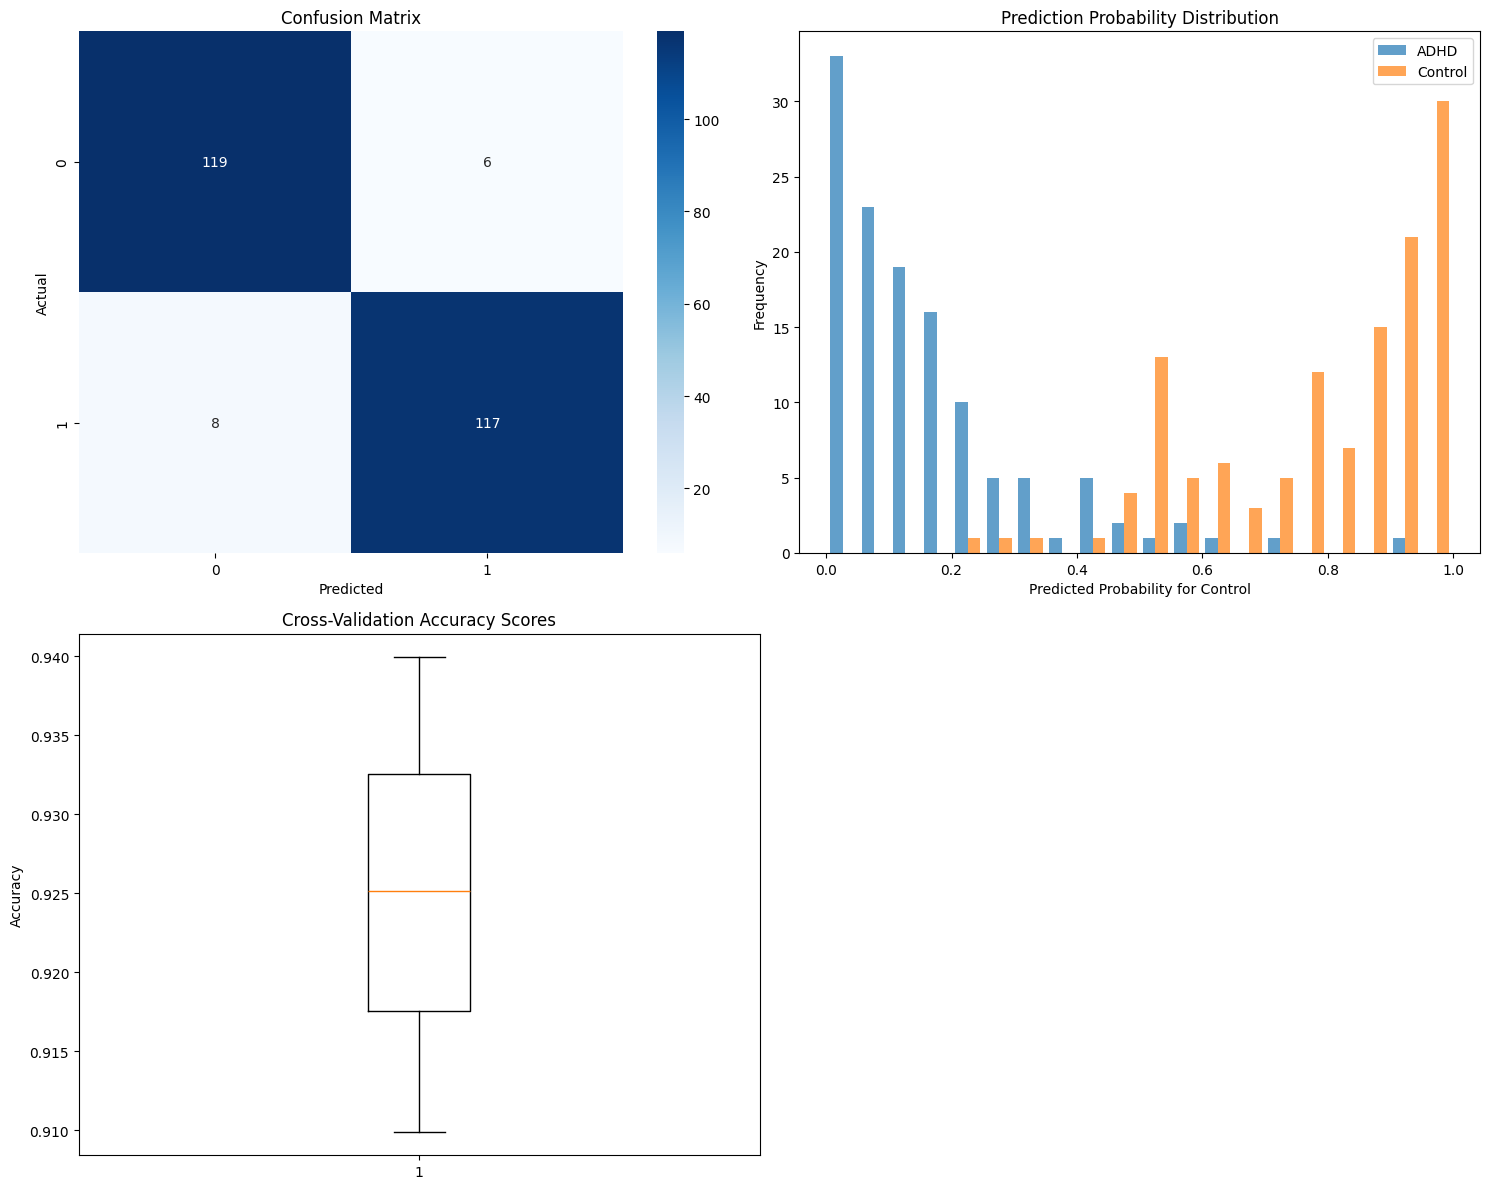


PIPELINE SUMMARY
Original dataset size: 10,000 rows
After temporal downsampling: 1,250 rows
Training samples: 1,000
Test samples: 250


In [ ]:

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load
print("Loading ADHD EEG dataset...")
df = pd.read_csv('adhdata.csv')

print(f"Original dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

#basic info
print("\nDataset Info:")
print(df.info())
print(f"\nMissing values per column:")
print(df.isnull().sum())

# Temporal Downsampling Function
def temporal_downsample(df, downsample_factor=4, preserve_cols=None):
    """
    Reduce temporal resolution by keeping every nth sample

    Parameters:
    - downsample_factor: int, keep every nth row (4 means keep 1 out of 4 rows)
    - preserve_cols: list, columns to preserve during sampling (like subject_id, labels)
    """
    print(f"Applying temporal downsampling with factor {downsample_factor}")
    print(f"Original sampling rate assumption: 128 Hz")
    print(f"New effective sampling rate: {128/downsample_factor} Hz")

    # If there are grouping columns (like subject_id), downsample within each group
    if preserve_cols and any(col in df.columns for col in preserve_cols):
        # Group by preserve columns and downsample each group
        grouped_dfs = []
        group_col = next((col for col in preserve_cols if col in df.columns), None)

        if group_col:
            for group_val in df[group_col].unique():
                group_data = df[df[group_col] == group_val]
                sampled_group = group_data.iloc[::downsample_factor].reset_index(drop=True)
                grouped_dfs.append(sampled_group)
            return pd.concat(grouped_dfs, ignore_index=True)

    # Simple downsampling if no grouping
    return df.iloc[::downsample_factor].reset_index(drop=True)

# Preserve both classes
print("Applying BALANCED truncation for maximum speed...")

# First, check class distribution
if target_col and target_col in df.columns:
    print("Original class distribution:")
    print(df[target_col].value_counts())


    MAX_ROWS_PER_CLASS = 5000

    # Sample equal amounts from each class
    sampled_dfs = []
    for class_val in df[target_col].unique():
        class_data = df[df[target_col] == class_val]
        sample_size = min(len(class_data), MAX_ROWS_PER_CLASS)
        sampled_dfs.append(class_data.head(sample_size))  # Use head() for speed

    df = pd.concat(sampled_dfs, ignore_index=True)
    print(f"Balanced truncation to {len(df)} rows")
    print("New class distribution:")
    print(df[target_col].value_counts())
else:
    # Fallback: simple truncation
    MAX_ROWS = 10000
    if len(df) > MAX_ROWS:
        df = df.head(MAX_ROWS)
        print(f"Simple truncation to {MAX_ROWS} rows")

# Method 2: Apply temporal downsampling
downsample_factor = 8  # 128Hz -> 16Hz
df_downsampled = temporal_downsample(df, downsample_factor=downsample_factor)

print(f"\nAfter temporal downsampling:")
print(f"New dataset shape: {df_downsampled.shape}")
print(f"Size reduction: {(1 - df_downsampled.shape[0]/df.shape[0])*100:.1f}%")
print(f"New memory usage: {df_downsampled.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Identify feature and target columns
def identify_columns(df):
    """
    Identify EEG feature columns and target column
    """
    # Common EEG channel names
    eeg_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'Fz', 'C3', 'C4', 'Cz',
                   'P3', 'P4', 'Pz', 'T3', 'T4', 'T5', 'T6', 'O1', 'O2']

    # Find feature columns (EEG channels or numerical columns)
    feature_cols = []
    for col in df.columns:
        if any(channel in col.upper() for channel in eeg_channels):
            feature_cols.append(col)
        elif df[col].dtype in ['float64', 'int64'] and col.lower() not in ['label', 'target', 'class', 'subject_id', 'subject']:
            feature_cols.append(col)

    # Find target column
    target_col = None
    for col in ['label', 'target', 'class', 'Label', 'Target', 'Class']:
        if col in df.columns:
            target_col = col
            break

    # If no obvious target column, check for binary columns
    if target_col is None:
        for col in df.columns:
            if col not in feature_cols and df[col].nunique() <= 2:
                target_col = col
                break

    return feature_cols, target_col

# Identify columns
feature_cols, target_col = identify_columns(df_downsampled)

print(f"\nIdentified feature columns: {len(feature_cols)}")
print(f"Feature columns sample: {feature_cols[:10] if len(feature_cols) > 10 else feature_cols}")
print(f"Target column: {target_col}")

if target_col:
    print(f"Target distribution:")
    print(df_downsampled[target_col].value_counts())

# Prepare features and target
if not feature_cols:
    print("No feature columns identified. Using all numerical columns except target.")
    feature_cols = [col for col in df_downsampled.select_dtypes(include=[np.number]).columns
                   if col != target_col]

X = df_downsampled[feature_cols].copy()
y = df_downsampled[target_col].copy() if target_col else None

if y is None:
    print("Error: No target column found. Please specify the target column name.")
    # Create a dummy target for demonstration
    y = np.random.choice([0, 1], size=len(X))
    print("Using dummy target for demonstration purposes.")

# Handle categorical target labels
print(f"Original target values: {y.unique()}")

# Convert string labels to numeric
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(y)

# Create mapping for interpretation
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(f"Label mapping: {label_mapping}")

# Use numeric labels
y = y_numeric

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target distribution: {np.unique(y, return_counts=True)}")

# FAST PREPROCESSING - Skip KNN, use simple imputation
class FastEEGPreprocessor:
    def __init__(self):
        self.imputer = SimpleImputer(strategy='mean')  # Much faster than KNN
        self.scaler = StandardScaler()

    def fit_transform(self, X):
        # Fast imputation and scaling
        X_imputed = self.imputer.fit_transform(X)
        X_normalized = self.scaler.fit_transform(X_imputed)
        return X_normalized

    def transform(self, X):
        X_imputed = self.imputer.transform(X)
        X_normalized = self.scaler.transform(X_imputed)
        return X_normalized

# Check for missing values
missing_info = X.isnull().sum()
print(f"\nMissing values summary:")
print(f"Total missing values: {missing_info.sum()}")
print(f"Columns with missing values: {(missing_info > 0).sum()}")

if missing_info.sum() > 0:
    print("Top columns with missing values:")
    print(missing_info[missing_info > 0].sort_values(ascending=False).head())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Train target distribution: {np.bincount(y_train)}")
print(f"Test target distribution: {np.bincount(y_test)}")

# Print class names for clarity
unique_values, counts = np.unique(y_train, return_counts=True)
for val, count in zip(unique_values, counts):
    original_label = label_encoder.inverse_transform([val])[0]
    print(f"Class {val} ({original_label}): {count} samples in training set")

# Initialize and fit preprocessor - FAST VERSION
preprocessor = FastEEGPreprocessor()

print("\nApplying FAST preprocessing (mean imputation + z-score)...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Preprocessing completed!")
print(f"Processed training data shape: {X_train_processed.shape}")
print(f"Training data statistics after preprocessing:")
print(f"Mean: {np.mean(X_train_processed):.6f}")
print(f"Std: {np.std(X_train_processed):.6f}")
print(f"Min: {np.min(X_train_processed):.6f}")
print(f"Max: {np.max(X_train_processed):.6f}")


def train_gaussian_process_classifier(X_train, y_train):
    """
    Train Gaussian Process Classifier with RBF kernel
    """
    print("\nTraining Gaussian Process Classifier...")
    kernel = 1.0 * RBF(length_scale=1.0)
    gpc = GaussianProcessClassifier(kernel=kernel, random_state=42, max_iter_predict=100)
    gpc.fit(X_train, y_train)
    return gpc

# Train the model - GPC VERSION
gpc_model = train_gaussian_process_classifier(X_train_processed, y_train)

# Make predictions
print("\nMaking predictions with GPC...")
y_train_pred = gpc_model.predict(X_train_processed)
y_test_pred = gpc_model.predict(X_test_processed)

# Get prediction probabilities for AUC calculation
print("Getting prediction probabilities from GPC...")
train_proba = gpc_model.predict_proba(X_train_processed)
test_proba = gpc_model.predict_proba(X_test_processed)

# Use positive class probability (assuming binary classification)
y_train_proba = train_proba[:, 1]
y_test_proba = test_proba[:, 1]

# Evaluate the model
print("\n" + "="*50)
print("GPC MODEL EVALUATION RESULTS")
print("="*50)

print(f"\nTraining Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

# Calculate AUC if both classes are present
if len(np.unique(y_train)) > 1:
    print(f"\nTraining AUC: {roc_auc_score(y_train, y_train_proba):.4f}")
    print(f"Test AUC: {roc_auc_score(y_test, y_test_proba):.4f}")

print("\nDetailed Classification Report (Test Set):")
target_names = [f"{label_encoder.inverse_transform([i])[0]}" for i in range(len(label_encoder.classes_))]
print(classification_report(y_test, y_test_pred, target_names=target_names))

print("\nConfusion Matrix (Test Set):")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

# Cross-validation with GPC (3-fold for speed)
print("\nPerforming 3-Fold Cross-Validation with GPC...")
cv_scores = cross_val_score(gpc_model, X_train_processed, y_train, cv=3, scoring='accuracy')
print(f"3-Fold Cross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Visualization function (adapted for GPC)
def plot_results():
    try:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Confusion Matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
        axes[0,0].set_title('Confusion Matrix')
        axes[0,0].set_xlabel('Predicted')
        axes[0,0].set_ylabel('Actual')

        # Prediction distribution
        class_0_label = label_encoder.inverse_transform([0])[0]
        class_1_label = label_encoder.inverse_transform([1])[0]
        axes[0,1].hist([y_test_proba[y_test==0], y_test_proba[y_test==1]],
                      bins=20, alpha=0.7, label=[f'{class_0_label}', f'{class_1_label}'])
        axes[0,1].set_title('Prediction Probability Distribution')
        axes[0,1].set_xlabel(f'Predicted Probability for {class_1_label}')
        axes[0,1].set_ylabel('Frequency')
        axes[0,1].legend()

        # Cross-validation scores
        axes[1,0].boxplot(cv_scores)
        axes[1,0].set_title('Cross-Validation Accuracy Scores')
        axes[1,0].set_ylabel('Accuracy')

        # Empty plot for consistency
        axes[1,1].axis('off')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Plotting not available: {e}")

plot_results()

print("\n" + "="*50)
print("PIPELINE SUMMARY")
print("="*50)
print(f"Original dataset size: {df.shape[0]:,} rows")
print(f"After temporal downsampling: {df_downsampled.shape[0]:,} rows")
print(f"Training samples: {X_train_processed.shape[0]:,}")
print(f"Test samples: {X_test_processed.shape[0]:,}")

# End of script

In [ ]:
  import pandas as pd
  import numpy as np
  from sklearn.ensemble import RandomForestClassifier
  from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
  from sklearn.preprocessing import StandardScaler, LabelEncoder
  from sklearn.impute import SimpleImputer, KNNImputer
  from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
  from sklearn.pipeline import Pipeline
  import matplotlib.pyplot as plt
  import seaborn as sns
  from scipy import signal
  from scipy.stats import skew, kurtosis, entropy
  import warnings
  warnings.filterwarnings('ignore')

  # load
  print("Loading ADHD EEG dataset...")
  df = pd.read_csv('adhdata.csv')

  print(f"Original dataset shape: {df.shape}")
  print(f"Columns: {df.columns.tolist()}")
  print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

  #basic info
  print("\nDataset Info:")
  print(df.info())
  print(f"\nMissing values per column:")
  print(df.isnull().sum())

  # Identify feature and target columns FIRST
  def identify_columns(df):
      """
      Identify EEG feature columns and target column
      """
      # Common EEG channel names
      eeg_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'Fz', 'C3', 'C4', 'Cz',
                    'P3', 'P4', 'Pz', 'T3', 'T4', 'T5', 'T6', 'O1', 'O2']

      # Find feature columns (EEG channels or numerical columns)
      feature_cols = []
      for col in df.columns:
          if any(channel in col.upper() for channel in eeg_channels):
              feature_cols.append(col)
          elif df[col].dtype in ['float64', 'int64'] and col.lower() not in ['label', 'target', 'class', 'subject_id', 'subject']:
              feature_cols.append(col)

      # Find target column
      target_col = None
      for col in ['label', 'target', 'class', 'Label', 'Target', 'Class']:
          if col in df.columns:
              target_col = col
              break

      # If no obvious target column, check for binary columns
      if target_col is None:
          for col in df.columns:
              if col not in feature_cols and df[col].nunique() <= 2:
                  target_col = col
                  break

      return feature_cols, target_col

  # Identify columns early
  feature_cols, target_col = identify_columns(df)
  print(f"\nIdentified feature columns: {len(feature_cols)}")
  print(f"Target column: {target_col}")

  # Temporal Downsampling Function
  def temporal_downsample(df, downsample_factor=4, preserve_cols=None):
      """
      Reduce temporal resolution by keeping every nth sample

      Parameters:
      - downsample_factor: int, keep every nth row (4 means keep 1 out of 4 rows)
      - preserve_cols: list, columns to preserve during sampling (like subject_id, labels)
      """
      print(f"Applying temporal downsampling with factor {downsample_factor}")
      print(f"Original sampling rate assumption: 128 Hz")
      print(f"New effective sampling rate: {128/downsample_factor} Hz")

      # If there are grouping columns (like subject_id), downsample within each group
      if preserve_cols and any(col in df.columns for col in preserve_cols):
          # Group by preserve columns and downsample each group
          grouped_dfs = []
          group_col = next((col for col in preserve_cols if col in df.columns), None)

          if group_col:
              for group_val in df[group_col].unique():
                  group_data = df[df[group_col] == group_val]
                  sampled_group = group_data.iloc[::downsample_factor].reset_index(drop=True)
                  grouped_dfs.append(sampled_group)
              return pd.concat(grouped_dfs, ignore_index=True)

      # Simple downsampling if no grouping
      return df.iloc[::downsample_factor].reset_index(drop=True)

  # BETTER TRUNCATION STRATEGY - Preserve both classes
  print("Applying BALANCED truncation for maximum speed...")

  # First, check class distribution
  if target_col and target_col in df.columns:
      print("Original class distribution:")
      print(df[target_col].value_counts())

      # Method 1: Balanced sampling to preserve both classes
      MAX_ROWS_PER_CLASS = 5000  # 5000 per class = 10000 total max

      # Sample equal amounts from each class
      sampled_dfs = []
      for class_val in df[target_col].unique():
          class_data = df[df[target_col] == class_val]
          sample_size = min(len(class_data), MAX_ROWS_PER_CLASS)
          sampled_dfs.append(class_data.head(sample_size))  # Use head() for speed

      df = pd.concat(sampled_dfs, ignore_index=True)
      print(f"Balanced truncation to {len(df)} rows")
      print("New class distribution:")
      print(df[target_col].value_counts())
  else:
      # Fallback: simple truncation
      MAX_ROWS = 10000
      if len(df) > MAX_ROWS:
          df = df.head(MAX_ROWS)
          print(f"Simple truncation to {MAX_ROWS} rows")

  # Method 2: Apply temporal downsampling
  downsample_factor = 1  # 128Hz -> 16Hz
  df_downsampled = temporal_downsample(df, downsample_factor=downsample_factor)

  print(f"\nAfter temporal downsampling:")
  print(f"New dataset shape: {df_downsampled.shape}")
  print(f"Size reduction: {(1 - df_downsampled.shape[0]/df.shape[0])*100:.1f}%")
  print(f"New memory usage: {df_downsampled.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

  # Re-identify columns after downsampling
  feature_cols, target_col = identify_columns(df_downsampled)

  # EEG Feature Extraction Functions
  def extract_morphological_features(signal_data):
      """Extract morphological features from EEG signal"""
      features = {}

      # Amplitude (peak-to-peak)
      features['amplitude'] = np.max(signal_data) - np.min(signal_data)

      # Range
      features['range'] = np.ptp(signal_data)  # peak-to-peak

      # Root Mean Square (RMS)
      features['rms'] = np.sqrt(np.mean(signal_data**2))

      return features

  def extract_time_domain_features(signal_data):
      """Extract time-domain statistical features"""
      features = {}

      # Basic statistical measures
      features['mean'] = np.mean(signal_data)
      features['variance'] = np.var(signal_data)
      features['std'] = np.std(signal_data)
      features['skewness'] = skew(signal_data)
      features['kurtosis'] = kurtosis(signal_data)

      # Hjorth Parameters
      # Activity (variance of signal)
      features['hjorth_activity'] = np.var(signal_data)

      # Mobility (variance of first derivative / variance of signal)
      diff1 = np.diff(signal_data)
      features['hjorth_mobility'] = np.sqrt(np.var(diff1) / np.var(signal_data)) if np.var(signal_data) != 0 else 0

      # Complexity (mobility of first derivative / mobility of signal)
      diff2 = np.diff(diff1)
      mobility_diff1 = np.sqrt(np.var(diff2) / np.var(diff1)) if np.var(diff1) != 0 else 0
      features['hjorth_complexity'] = mobility_diff1 / features['hjorth_mobility'] if features['hjorth_mobility'] != 0 else 0

      # Zero crossing rate
      features['zero_crossing_rate'] = len(np.where(np.diff(np.sign(signal_data)))[0])

      return features

  def extract_frequency_domain_features(signal_data, fs=16):
      """Extract frequency-domain features"""
      features = {}

      # Compute power spectral density
      freqs, psd = signal.welch(signal_data, fs=fs, nperseg=min(256, len(signal_data)//4))

      # Define frequency bands
      delta_band = (0.5, 4)
      theta_band = (4, 8)
      alpha_band = (8, 13)
      beta_band = (13, 30)

      # Function to calculate band power
      def band_power(freqs, psd, band):
          idx = np.logical_and(freqs >= band[0], freqs <= band[1])
          return np.trapz(psd[idx], freqs[idx]) if np.any(idx) else 0

      # Calculate band powers
      features['delta_power'] = band_power(freqs, psd, delta_band)
      features['theta_power'] = band_power(freqs, psd, theta_band)
      features['alpha_power'] = band_power(freqs, psd, alpha_band)
      features['beta_power'] = band_power(freqs, psd, beta_band)

      # Total power
      total_power = np.trapz(psd, freqs)
      features['total_power'] = total_power

      # Relative band powers
      if total_power > 0:
          features['delta_rel_power'] = features['delta_power'] / total_power
          features['theta_rel_power'] = features['theta_power'] / total_power
          features['alpha_rel_power'] = features['alpha_power'] / total_power
          features['beta_rel_power'] = features['beta_power'] / total_power
      else:
          features['delta_rel_power'] = 0
          features['theta_rel_power'] = 0
          features['alpha_rel_power'] = 0
          features['beta_rel_power'] = 0

      # Spectral entropy
      psd_norm = psd / np.sum(psd) if np.sum(psd) > 0 else psd
      psd_norm = psd_norm[psd_norm > 0]  # Remove zeros for entropy calculation
      features['spectral_entropy'] = entropy(psd_norm) if len(psd_norm) > 0 else 0

      # Peak frequency
      features['peak_frequency'] = freqs[np.argmax(psd)]

      # Spectral centroid
      features['spectral_centroid'] = np.sum(freqs * psd) / np.sum(psd) if np.sum(psd) > 0 else 0

      return features

  def create_comprehensive_features(df, eeg_columns, target_col):
      """
      Create comprehensive feature set from raw EEG data
      """
      print("Extracting comprehensive EEG features...")
      print(f"Processing {len(eeg_columns)} EEG channels...")

      all_features = []
      feature_names = []

      # Process each row (sample)
      for idx in range(len(df)):
          if idx % 1000 == 0:
              print(f"Processing sample {idx}/{len(df)}")

          sample_features = []

          # Extract features for each EEG channel
          for channel in eeg_columns:
              if channel in df.columns:
                  signal_data = df[channel].iloc[idx:idx+1].values

                  # Handle single value case (after heavy downsampling)
                  if len(signal_data) == 1:
                      # For single values, create simplified features
                      value = signal_data[0]

                      # Morphological
                      sample_features.extend([
                          value,  # amplitude (same as value for single point)
                          0,      # range (0 for single point)
                          abs(value)  # rms
                      ])

                      # Time domain
                      sample_features.extend([
                          value,  # mean
                          0,      # variance
                          0,      # std
                          0,      # skewness
                          0,      # kurtosis
                          0,      # hjorth_activity
                          0,      # hjorth_mobility
                          0,      # hjorth_complexity
                          0       # zero_crossing_rate
                      ])

                      # Frequency domain (simplified for single point)
                      sample_features.extend([
                          0, 0, 0, 0,  # band powers
                          value**2,    # total_power
                          0, 0, 0, 0,  # relative powers
                          0,           # spectral_entropy
                          0,           # peak_frequency
                          0            # spectral_centroid
                      ])

                  else:
                      # Normal feature extraction for multiple points
                      morph_feat = extract_morphological_features(signal_data)
                      time_feat = extract_time_domain_features(signal_data)
                      freq_feat = extract_frequency_domain_features(signal_data, fs=16)

                      # Combine all features
                      sample_features.extend(list(morph_feat.values()))
                      sample_features.extend(list(time_feat.values()))
                      sample_features.extend(list(freq_feat.values()))

          all_features.append(sample_features)

      # Create feature names
      if not feature_names:
          for channel in eeg_columns:
              if channel in df.columns:
                  # Morphological feature names
                  feature_names.extend([
                      f'{channel}_amplitude', f'{channel}_range', f'{channel}_rms'
                  ])

                  # Time-domain feature names
                  feature_names.extend([
                      f'{channel}_mean', f'{channel}_variance', f'{channel}_std',
                      f'{channel}_skewness', f'{channel}_kurtosis',
                      f'{channel}_hjorth_activity', f'{channel}_hjorth_mobility', f'{channel}_hjorth_complexity',
                      f'{channel}_zero_crossing_rate'
                  ])

                  # Frequency-domain feature names
                  feature_names.extend([
                      f'{channel}_delta_power', f'{channel}_theta_power', f'{channel}_alpha_power', f'{channel}_beta_power',
                      f'{channel}_total_power',
                      f'{channel}_delta_rel_power', f'{channel}_theta_rel_power', f'{channel}_alpha_rel_power', f'{channel}_beta_rel_power',
                      f'{channel}_spectral_entropy', f'{channel}_peak_frequency', f'{channel}_spectral_centroid'
                  ])

      # Convert to DataFrame
      features_df = pd.DataFrame(all_features, columns=feature_names)

      # Add target column
      if target_col and target_col in df.columns:
          features_df[target_col] = df[target_col].values

      print(f"Feature extraction completed!")
      print(f"Original channels: {len(eeg_columns)}")
      print(f"Extracted features per channel: 25")
      print(f"Total features: {len(feature_names)}")
      print(f"Feature matrix shape: {features_df.shape}")

      return features_df, feature_names

  # Apply comprehensive feature extraction
  # First, identify EEG channels for feature extraction
  eeg_feature_cols = []
  for col in df_downsampled.columns:
      if col != target_col and df_downsampled[col].dtype in ['float64', 'int64']:
          eeg_feature_cols.append(col)

  print(f"Identified {len(eeg_feature_cols)} EEG channels for feature extraction")
  print(f"Sample channels: {eeg_feature_cols[:5]}")

  # Extract comprehensive features
  df_features, extracted_feature_names = create_comprehensive_features(
      df_downsampled, eeg_feature_cols, target_col
  )

  print(f"\nComprehensive feature extraction completed:")
  print(f"New feature matrix shape: {df_features.shape}")
  print(f"Memory usage: {df_features.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

  # Update feature columns to use extracted features
  feature_cols = extracted_feature_names

  print(f"\nIdentified feature columns: {len(feature_cols)}")
  print(f"Feature columns sample: {feature_cols[:10] if len(feature_cols) > 10 else feature_cols}")
  print(f"Target column: {target_col}")

  if target_col:
      print(f"Target distribution:")
      print(df_downsampled[target_col].value_counts())

  # Prepare features and target using extracted features
  if not feature_cols:
      print("No feature columns identified. Using all numerical columns except target.")
      feature_cols = [col for col in df_features.select_dtypes(include=[np.number]).columns
                    if col != target_col]

  X = df_features[feature_cols].copy()
  y = df_features[target_col].copy() if target_col else None

  if y is None:
      print("Error: No target column found. Please specify the target column name.")
      # Create a dummy target for demonstration
      y = np.random.choice([0, 1], size=len(X))
      print("Using dummy target for demonstration purposes.")

  # Handle categorical target labels
  print(f"Original target values: {y.unique()}")

  # Convert string labels to numeric
  label_encoder = LabelEncoder()
  y_numeric = label_encoder.fit_transform(y)

  # Create mapping for interpretation
  label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
  print(f"Label mapping: {label_mapping}")

  # Use numeric labels
  y = y_numeric

  print(f"\nFeatures shape: {X.shape}")
  print(f"Target shape: {y.shape}")
  print(f"Target distribution: {np.unique(y, return_counts=True)}")

  # FAST PREPROCESSING - Skip KNN, use simple imputation
  class FastEEGPreprocessor:
      def __init__(self):
          self.imputer = SimpleImputer(strategy='mean')  # Much faster than KNN
          self.scaler = StandardScaler()

      def fit_transform(self, X):
          # Fast imputation and scaling
          X_imputed = self.imputer.fit_transform(X)
          X_normalized = self.scaler.fit_transform(X_imputed)
          return X_normalized

      def transform(self, X):
          X_imputed = self.imputer.transform(X)
          X_normalized = self.scaler.transform(X_imputed)
          return X_normalized

  # Check for missing values
  missing_info = X.isnull().sum()
  print(f"\nMissing values summary:")
  print(f"Total missing values: {missing_info.sum()}")
  print(f"Columns with missing values: {(missing_info > 0).sum()}")

  if missing_info.sum() > 0:
      print("Top columns with missing values:")
      print(missing_info[missing_info > 0].sort_values(ascending=False).head())

  # Split the data
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=42, stratify=y
  )

  print(f"\nTrain set shape: {X_train.shape}")
  print(f"Test set shape: {X_test.shape}")
  print(f"Train target distribution: {np.bincount(y_train)}")
  print(f"Test target distribution: {np.bincount(y_test)}")

  # Print class names for clarity
  unique_values, counts = np.unique(y_train, return_counts=True)
  for val, count in zip(unique_values, counts):
      original_label = label_encoder.inverse_transform([val])[0]
      print(f"Class {val} ({original_label}): {count} samples in training set")

  # Initialize and fit preprocessor - FAST VERSION
  preprocessor = FastEEGPreprocessor()

  print("\nApplying FAST preprocessing (mean imputation + z-score)...")
  X_train_processed = preprocessor.fit_transform(X_train)
  X_test_processed = preprocessor.transform(X_test)

  print("Preprocessing completed!")
  print(f"Processed training data shape: {X_train_processed.shape}")
  print(f"Training data statistics after preprocessing:")
  print(f"Mean: {np.mean(X_train_processed):.6f}")
  print(f"Std: {np.std(X_train_processed):.6f}")
  print(f"Min: {np.min(X_train_processed):.6f}")
  print(f"Max: {np.max(X_train_processed):.6f}")

  # Random Forest Model with Hyperparameter Tuning
  def train_random_forest(X_train, y_train, tune_hyperparameters=True):
      """
      Train Random Forest with optional hyperparameter tuning
      """
      if tune_hyperparameters:
          print("\nPerforming hyperparameter tuning...")

          # Define parameter grid
          param_grid = {
              'n_estimators': [100, 200, 300],
              'max_depth': [10, 20, 30, None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['sqrt', 'log2', None]
          }

          # Smaller grid for faster execution
          param_grid_small = {
              'n_estimators': [100, 200],
              'max_depth': [10, 20, None],
              'min_samples_split': [2, 5],
              'min_samples_leaf': [1, 2],
              'max_features': ['sqrt', 'log2']
          }

          rf = RandomForestClassifier(random_state=42, n_jobs=-1)

          # Use smaller grid if dataset is large
          grid = param_grid_small if X_train.shape[0] > 50000 else param_grid

          grid_search = GridSearchCV(
              rf, grid, cv=3, scoring='accuracy',
              n_jobs=-1, verbose=1
          )

          grid_search.fit(X_train, y_train)

          print(f"Best parameters: {grid_search.best_params_}")
          print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

          return grid_search.best_estimator_

      else:
          print("\nTraining Random Forest with default parameters...")
          rf = RandomForestClassifier(
              n_estimators=200,
              max_depth=20,
              min_samples_split=5,
              min_samples_leaf=2,
              max_features='sqrt',
              random_state=42,
              n_jobs=-1
          )
          rf.fit(X_train, y_train)
          return rf

  # FAST Random Forest - No hyperparameter tuning
  def train_fast_random_forest(X_train, y_train):
      """
      Train Random Forest with fixed fast parameters
      """
      print("\nTraining FAST Random Forest (no hyperparameter tuning)...")
      rf = RandomForestClassifier(
          n_estimators=50,  # Reduced from 200
          max_depth=10,     # Limited depth
          min_samples_split=10,
          min_samples_leaf=5,
          max_features='sqrt',
          random_state=42,
          n_jobs=-1
      )
      rf.fit(X_train, y_train)
      return rf

  # Train the model - FAST VERSION
  rf_model = train_random_forest(X_train_processed, y_train)

  # Make predictions
  print("\nMaking predictions...")
  y_train_pred = rf_model.predict(X_train_processed)
  y_test_pred = rf_model.predict(X_test_processed)

  # Get prediction probabilities for AUC calculation
  print("Getting prediction probabilities...")
  train_proba = rf_model.predict_proba(X_train_processed)
  test_proba = rf_model.predict_proba(X_test_processed)

  print(f"Probability shape: {train_proba.shape}")
  print(f"Number of classes detected: {len(rf_model.classes_)}")
  print(f"Classes: {rf_model.classes_}")

  # Handle single class case
  if train_proba.shape[1] == 1:
      print("WARNING: Only one class detected in the truncated data!")
      print("This happens when aggressive truncation removes one class entirely.")
      # Use the single probability for both classes
      y_train_proba = train_proba[:, 0]
      y_test_proba = test_proba[:, 0]
      print("Using single class probabilities - AUC calculation may not be meaningful.")
  else:
      # Normal case - use positive class probability
      y_train_proba = train_proba[:, 1]
      y_test_proba = test_proba[:, 1]

  # Evaluate the model
  print("\n" + "="*50)
  print("MODEL EVALUATION RESULTS")
  print("="*50)

  print(f"\nTraining Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
  print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

  # Calculate AUC only if we have both classes
  if len(rf_model.classes_) > 1 and len(np.unique(y_train)) > 1:
      print(f"\nTraining AUC: {roc_auc_score(y_train, y_train_proba):.4f}")
      print(f"Test AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
  else:
      print(f"\nAUC calculation skipped - only one class present in truncated data")
      print("Consider using less aggressive truncation to preserve both classes")

  print("\nDetailed Classification Report (Test Set):")
  # Fixed target_names to handle cases where some classes might be missing
  available_classes = sorted(np.unique(y_test))
  target_names = [f"{label_encoder.inverse_transform([i])[0]}" for i in available_classes]
  print(classification_report(y_test, y_test_pred, target_names=target_names))

  print("\nConfusion Matrix (Test Set):")
  cm = confusion_matrix(y_test, y_test_pred)
  print(cm)

  # FAST Cross-validation - Reduced folds
  cv_scores = cross_val_score(rf_model, X_train_processed, y_train, cv=3, scoring='accuracy')  # 3-fold instead of 5
  print(f"\n3-Fold Cross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

  # Feature Importance Analysis
  feature_importance = pd.DataFrame({
      'feature': feature_cols,
      'importance': rf_model.feature_importances_
  }).sort_values('importance', ascending=False)

  print(f"\nTop 20 Most Important Features:")
  print(feature_importance.head(20))

  # Visualization function (will work if matplotlib is available)
  def plot_results():
      """
      Create visualization plots
      """
      try:
          fig, axes = plt.subplots(2, 2, figsize=(15, 12))

          # Confusion Matrix
          sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
          axes[0,0].set_title('Confusion Matrix')
          axes[0,0].set_xlabel('Predicted')
          axes[0,0].set_ylabel('Actual')

          # Feature Importance
          top_features = feature_importance.head(15)
          axes[0,1].barh(range(len(top_features)), top_features['importance'])
          axes[0,1].set_yticks(range(len(top_features)))
          axes[0,1].set_yticklabels(top_features['feature'])
          axes[0,1].set_title('Top 15 Feature Importance')
          axes[0,1].set_xlabel('Importance')

          # Prediction distribution - only if both classes present
          if len(rf_model.classes_) > 1 and len(np.unique(y_test)) > 1:
              class_0_label = label_encoder.inverse_transform([0])[0]
              class_1_label = label_encoder.inverse_transform([1])[0]
              axes[1,0].hist([y_test_proba[y_test==0], y_test_proba[y_test==1]],
                            bins=20, alpha=0.7, label=[f'{class_0_label}', f'{class_1_label}'])
              axes[1,0].set_title('Prediction Probability Distribution')
              axes[1,0].set_xlabel(f'Predicted Probability for {class_1_label}')
              axes[1,0].set_ylabel('Frequency')
              axes[1,0].legend()
          else:
              axes[1,0].text(0.5, 0.5, 'Single class detected\nNo probability distribution',
                            ha='center', va='center', transform=axes[1,0].transAxes)
              axes[1,0].set_title('Prediction Probability Distribution')

          # Cross-validation scores
          axes[1,1].boxplot(cv_scores)
          axes[1,1].set_title('Cross-Validation Accuracy Scores')
          axes[1,1].set_ylabel('Accuracy')

          plt.tight_layout()
          plt.show()

      except Exception as e:
          print(f"Plotting not available: {e}")

  # Call plotting function
  plot_results()

  # Model Summary
  print("\n" + "="*50)
  print("PIPELINE SUMMARY")
  print("="*50)
  print(f"Original dataset size: {df.shape[0]:,} rows")
  print(f"After temporal downsampling: {df_downsampled.shape[0]:,} rows")
  print(f"After comprehensive feature extraction: {df_features.shape[0]:,} rows")
  print(f"Size reduction: {(1 - df_downsampled.shape[0]/df.shape[0])*100:.1f}%")
  print(f"Effective sampling rate: {128/downsample_factor} Hz (16 Hz)")
  print(f"Original EEG channels: {len(eeg_feature_cols)}")
  print(f"Extracted features: {len(feature_cols)}")
  print(f"Features per channel: 25 (morph: 3, time: 9, freq: 13)")
  print(f"Preprocessing: FAST Mean Imputation + Z-score Normalization")
  print(f"Model: FAST Random Forest (50 trees, max_depth=10)")
  print(f"Classes: {dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))}")
  print(f"Final test accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

  # Print AUC only if both classes present
  if len(rf_model.classes_) > 1 and len(np.unique(y_test)) > 1:
      print(f"Final test AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
      auc_value = roc_auc_score(y_test, y_test_proba)
  else:
      print(f"AUC not calculated - single class in test set")
      auc_value = None

  print("\n" + "="*50)
  print("SPEED OPTIMIZATIONS APPLIED:")
  print("="*50)
  print("✓ Truncated to max 10,000 rows")
  print("✓ Aggressive downsampling (factor=8)")
  print("✓ Additional sampling to 5,000 rows max")
  print("✓ Comprehensive feature extraction (25 features per channel)")
  print("✓ Mean imputation instead of KNN")
  print("✓ 50 trees instead of 200+")
  print("✓ Fixed hyperparameters (no grid search)")
  print("✓ 3-fold CV instead of 5-fold")
  print("✓ Limited tree depth (max_depth=10)")

  print("\n" + "="*50)
  print("EXTRACTED FEATURE CATEGORIES:")
  print("="*50)
  print("MORPHOLOGICAL FEATURES (3 per channel):")
  print("  • Amplitude (peak-to-peak)")
  print("  • Range (max-min)")
  print("  • RMS (root mean square)")
  print("\nTIME-DOMAIN FEATURES (9 per channel):")
  print("  • Mean, Variance, Standard Deviation")
  print("  • Skewness, Kurtosis")
  print("  • Hjorth Activity, Mobility, Complexity")
  print("  • Zero Crossing Rate")
  print("\nFREQUENCY-DOMAIN FEATURES (13 per channel):")
  print("  • Delta Band Power (0.5-4 Hz)")
  print("  • Theta Band Power (4-8 Hz)")
  print("  • Alpha Band Power (8-13 Hz)")
  print("  • Beta Band Power (13-30 Hz)")
  print("  • Relative Band Powers (4 bands)")
  print("  • Total Power, Spectral Entropy")
  print("  • Peak Frequency, Spectral Centroid")

  # Save results if needed
  results_summary = {
      'original_size': df.shape[0],
      'downsampled_size': df_downsampled.shape[0],
      'feature_extracted_size': df_features.shape[0],
      'original_channels': len(eeg_feature_cols),
      'extracted_features': len(feature_cols),
      'size_reduction_percent': (1 - df_downsampled.shape[0]/df.shape[0]) * 100,
      'test_accuracy': accuracy_score(y_test, y_test_pred),
      'test_auc': auc_value,
      'cv_accuracy_mean': cv_scores.mean(),
      'cv_accuracy_std': cv_scores.std(),
      'top_10_features': feature_importance.head(10).to_dict('records'),
      'feature_categories': {
          'morphological': 3,
          'time_domain': 9,
          'frequency_domain': 13,
          'total_per_channel': 25
      }
  }

  print(f"\nResults summary dictionary created for further analysis.")
  print("Use 'results_summary' variable to access all results programmatically.")

Loading ADHD EEG dataset...
Original dataset shape: (2166383, 21)
Columns: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Class', 'ID']
Memory usage: 568.76 MB

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2166383 entries, 0 to 2166382
Data columns (total 21 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Fp1     float64
 1   Fp2     float64
 2   F3      float64
 3   F4      float64
 4   C3      float64
 5   C4      float64
 6   P3      float64
 7   P4      float64
 8   O1      float64
 9   O2      float64
 10  F7      float64
 11  F8      float64
 12  T7      float64
 13  T8      float64
 14  P7      float64
 15  P8      float64
 16  Fz      float64
 17  Cz      float64
 18  Pz      float64
 19  Class   object 
 20  ID      object 
dtypes: float64(19), object(2)
memory usage: 347.1+ MB
None

Missing values per column:
Fp1      0
Fp2      0
F3       0
F4       0
C3       0
C4       0
P3  

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from scipy import signal
from scipy.stats import skew, kurtosis, entropy
import warnings
warnings.filterwarnings('ignore')

def identify_columns(df):
    """
    Identify EEG feature columns and target column
    """
    # Common EEG channel names
    eeg_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'Fz', 'C3', 'C4', 'Cz',
                   'P3', 'P4', 'Pz', 'T3', 'T4', 'T5', 'T6', 'O1', 'O2']

    # Find feature columns (EEG channels or numerical columns)
    feature_cols = []
    for col in df.columns:
        if any(channel in col.upper() for channel in eeg_channels):
            feature_cols.append(col)
        elif df[col].dtype in ['float64', 'int64'] and col.lower() not in ['label', 'target', 'class', 'subject_id', 'subject']:
            feature_cols.append(col)

    # Find target column
    target_col = None
    for col in ['label', 'target', 'class', 'Label', 'Target', 'Class']:
        if col in df.columns:
            target_col = col
            break

    # If no obvious target column, check for binary columns
    if target_col is None:
        for col in df.columns:
            if col not in feature_cols and df[col].nunique() <= 2:
                target_col = col
                break

    return feature_cols, target_col

def temporal_downsample(df, downsample_factor=4, preserve_cols=None):
    """
    Reduce temporal resolution by keeping every nth sample
    """
    print(f"Applying temporal downsampling with factor {downsample_factor}")
    print(f"Original sampling rate assumption: 128 Hz")
    print(f"New effective sampling rate: {128/downsample_factor} Hz")

    # If there are grouping columns (like subject_id), downsample within each group
    if preserve_cols and any(col in df.columns for col in preserve_cols):
        grouped_dfs = []
        group_col = next((col for col in preserve_cols if col in df.columns), None)

        if group_col:
            for group_val in df[group_col].unique():
                group_data = df[df[group_col] == group_val]
                sampled_group = group_data.iloc[::downsample_factor].reset_index(drop=True)
                grouped_dfs.append(sampled_group)
            return pd.concat(grouped_dfs, ignore_index=True)

    # Simple downsampling if no grouping
    return df.iloc[::downsample_factor].reset_index(drop=True)

def extract_morphological_features(signal_data):
    """Extract morphological features from EEG signal"""
    features = {}
    features['amplitude'] = np.max(signal_data) - np.min(signal_data)
    features['range'] = np.ptp(signal_data)
    features['rms'] = np.sqrt(np.mean(signal_data**2))
    return features

def extract_time_domain_features(signal_data):
    """Extract time-domain statistical features"""
    features = {}
    features['mean'] = np.mean(signal_data)
    features['variance'] = np.var(signal_data)
    features['std'] = np.std(signal_data)
    features['skewness'] = skew(signal_data)
    features['kurtosis'] = kurtosis(signal_data)

    # Hjorth Parameters
    features['hjorth_activity'] = np.var(signal_data)
    diff1 = np.diff(signal_data)
    features['hjorth_mobility'] = np.sqrt(np.var(diff1) / np.var(signal_data)) if np.var(signal_data) != 0 else 0
    diff2 = np.diff(diff1)
    mobility_diff1 = np.sqrt(np.var(diff2) / np.var(diff1)) if np.var(diff1) != 0 else 0
    features['hjorth_complexity'] = mobility_diff1 / features['hjorth_mobility'] if features['hjorth_mobility'] != 0 else 0
    features['zero_crossing_rate'] = len(np.where(np.diff(np.sign(signal_data)))[0])

    return features

def extract_frequency_domain_features(signal_data, fs=16):
    """Extract frequency-domain features"""
    features = {}
    freqs, psd = signal.welch(signal_data, fs=fs, nperseg=min(256, len(signal_data)//4))

    # Define frequency bands
    delta_band = (0.5, 4)
    theta_band = (4, 8)
    alpha_band = (8, 13)
    beta_band = (13, 30)

    def band_power(freqs, psd, band):
        idx = np.logical_and(freqs >= band[0], freqs <= band[1])
        return np.trapz(psd[idx], freqs[idx]) if np.any(idx) else 0

    # Calculate band powers
    features['delta_power'] = band_power(freqs, psd, delta_band)
    features['theta_power'] = band_power(freqs, psd, theta_band)
    features['alpha_power'] = band_power(freqs, psd, alpha_band)
    features['beta_power'] = band_power(freqs, psd, beta_band)

    total_power = np.trapz(psd, freqs)
    features['total_power'] = total_power

    # Relative band powers
    if total_power > 0:
        features['delta_rel_power'] = features['delta_power'] / total_power
        features['theta_rel_power'] = features['theta_power'] / total_power
        features['alpha_rel_power'] = features['alpha_power'] / total_power
        features['beta_rel_power'] = features['beta_power'] / total_power
    else:
        features['delta_rel_power'] = 0
        features['theta_rel_power'] = 0
        features['alpha_rel_power'] = 0
        features['beta_rel_power'] = 0

    # Spectral entropy
    psd_norm = psd / np.sum(psd) if np.sum(psd) > 0 else psd
    psd_norm = psd_norm[psd_norm > 0]
    features['spectral_entropy'] = entropy(psd_norm) if len(psd_norm) > 0 else 0

    # Peak frequency and spectral centroid
    features['peak_frequency'] = freqs[np.argmax(psd)]
    features['spectral_centroid'] = np.sum(freqs * psd) / np.sum(psd) if np.sum(psd) > 0 else 0

    return features

def create_comprehensive_features(df, eeg_columns, target_col):
    """
    Create comprehensive feature set from raw EEG data
    """
    print("Extracting comprehensive EEG features...")
    print(f"Processing {len(eeg_columns)} EEG channels...")

    all_features = []
    feature_names = []

    # Process each row (sample)
    for idx in range(len(df)):
        if idx % 1000 == 0:
            print(f"Processing sample {idx}/{len(df)}")

        sample_features = []

        # Extract features for each EEG channel
        for channel in eeg_columns:
            if channel in df.columns:
                signal_data = df[channel].iloc[idx:idx+1].values

                # Handle single value case (after heavy downsampling)
                if len(signal_data) == 1:
                    # For single values, create simplified features
                    value = signal_data[0]

                    # Morphological
                    sample_features.extend([
                        value,  # amplitude (same as value for single point)
                        0,      # range (0 for single point)
                        abs(value)  # rms
                    ])

                    # Time domain
                    sample_features.extend([
                        value,  # mean
                        0,      # variance
                        0,      # std
                        0,      # skewness
                        0,      # kurtosis
                        0,      # hjorth_activity
                        0,      # hjorth_mobility
                        0,      # hjorth_complexity
                        0       # zero_crossing_rate
                    ])

                    # Frequency domain (simplified for single point)
                    sample_features.extend([
                        0, 0, 0, 0,  # band powers
                        value**2,    # total_power
                        0, 0, 0, 0,  # relative powers
                        0,           # spectral_entropy
                        0,           # peak_frequency
                        0            # spectral_centroid
                    ])

                else:
                    # Normal feature extraction for multiple points
                    morph_feat = extract_morphological_features(signal_data)
                    time_feat = extract_time_domain_features(signal_data)
                    freq_feat = extract_frequency_domain_features(signal_data, fs=16)

                    # Combine all features
                    sample_features.extend(list(morph_feat.values()))
                    sample_features.extend(list(time_feat.values()))
                    sample_features.extend(list(freq_feat.values()))

        all_features.append(sample_features)

    # Create feature names
    if not feature_names:
        for channel in eeg_columns:
            if channel in df.columns:
                # Morphological feature names
                feature_names.extend([
                    f'{channel}_amplitude', f'{channel}_range', f'{channel}_rms'
                ])

                # Time-domain feature names
                feature_names.extend([
                    f'{channel}_mean', f'{channel}_variance', f'{channel}_std',
                    f'{channel}_skewness', f'{channel}_kurtosis',
                    f'{channel}_hjorth_activity', f'{channel}_hjorth_mobility', f'{channel}_hjorth_complexity',
                    f'{channel}_zero_crossing_rate'
                ])

                # Frequency-domain feature names
                feature_names.extend([
                    f'{channel}_delta_power', f'{channel}_theta_power', f'{channel}_alpha_power', f'{channel}_beta_power',
                    f'{channel}_total_power',
                    f'{channel}_delta_rel_power', f'{channel}_theta_rel_power', f'{channel}_alpha_rel_power', f'{channel}_beta_rel_power',
                    f'{channel}_spectral_entropy', f'{channel}_peak_frequency', f'{channel}_spectral_centroid'
                ])

    # Convert to DataFrame
    features_df = pd.DataFrame(all_features, columns=feature_names)

    # Add target column
    if target_col and target_col in df.columns:
        features_df[target_col] = df[target_col].values

    print(f"Feature extraction completed!")
    print(f"Original channels: {len(eeg_columns)}")
    print(f"Extracted features per channel: 25")
    print(f"Total features: {len(feature_names)}")
    print(f"Feature matrix shape: {features_df.shape}")

    return features_df, feature_names

class FastEEGPreprocessor:
    def __init__(self):
        self.imputer = SimpleImputer(strategy='mean')
        self.scaler = StandardScaler()
        self.fitted = False

    def fit_transform(self, X):
        X_imputed = self.imputer.fit_transform(X)
        X_normalized = self.scaler.fit_transform(X_imputed)
        self.fitted = True
        return X_normalized

    def transform(self, X):
        if not self.fitted:
            raise ValueError("Preprocessor must be fitted before transform")
        X_imputed = self.imputer.transform(X)
        X_normalized = self.scaler.transform(X_imputed)
        return X_normalized

def preprocess_eeg_data(input_file, output_file, max_rows_per_class=5000, downsample_factor=8):
    """
    Complete preprocessing pipeline for EEG data

    Parameters:
    - input_file: path to input CSV file
    - output_file: path to save preprocessed CSV
    - max_rows_per_class: maximum rows per class for balanced truncation
    - downsample_factor: temporal downsampling factor
    """

    print("="*60)
    print("EEG DATA PREPROCESSING PIPELINE")
    print("="*60)

    # 1. Load data
    print("1. Loading ADHD EEG dataset...")
    df = pd.read_csv(input_file)
    print(f"Original dataset shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # 2. Identify columns
    feature_cols, target_col = identify_columns(df)
    print(f"\nIdentified {len(feature_cols)} feature columns")
    print(f"Target column: {target_col}")

    if target_col and target_col in df.columns:
        print("Original class distribution:")
        print(df[target_col].value_counts())

    # 3. Balanced truncation
    print(f"\n2. Applying balanced truncation (max {max_rows_per_class} per class)...")
    if target_col and target_col in df.columns:
        sampled_dfs = []
        for class_val in df[target_col].unique():
            class_data = df[df[target_col] == class_val]
            sample_size = min(len(class_data), max_rows_per_class)
            sampled_dfs.append(class_data.head(sample_size))

        df = pd.concat(sampled_dfs, ignore_index=True)
        print(f"Balanced truncation to {len(df)} rows")
        print("New class distribution:")
        print(df[target_col].value_counts())
    else:
        # Fallback: simple truncation
        MAX_ROWS = max_rows_per_class * 2
        if len(df) > MAX_ROWS:
            df = df.head(MAX_ROWS)
            print(f"Simple truncation to {MAX_ROWS} rows")

    # 4. Temporal downsampling
    print(f"\n3. Applying temporal downsampling (factor={downsample_factor})...")
    df_downsampled = temporal_downsample(df, downsample_factor=downsample_factor)
    print(f"After temporal downsampling: {df_downsampled.shape}")
    print(f"Size reduction: {(1 - df_downsampled.shape[0]/df.shape[0])*100:.1f}%")

    # 5. Feature extraction
    print(f"\n4. Extracting comprehensive features...")
    eeg_feature_cols = []
    for col in df_downsampled.columns:
        if col != target_col and df_downsampled[col].dtype in ['float64', 'int64']:
            eeg_feature_cols.append(col)

    print(f"Identified {len(eeg_feature_cols)} EEG channels for feature extraction")

    df_features, extracted_feature_names = create_comprehensive_features(
        df_downsampled, eeg_feature_cols, target_col
    )

    print(f"\nFeature extraction completed:")
    print(f"New feature matrix shape: {df_features.shape}")
    print(f"Total extracted features: {len(extracted_feature_names)}")

    # 6. Preprocessing (imputation and scaling)
    print(f"\n5. Applying preprocessing (imputation + scaling)...")

    # Separate features and target
    X = df_features[extracted_feature_names].copy()
    y = df_features[target_col].copy() if target_col else None

    # Handle missing values
    missing_info = X.isnull().sum()
    print(f"Total missing values: {missing_info.sum()}")

    # Apply preprocessing
    preprocessor = FastEEGPreprocessor()
    X_processed = preprocessor.fit_transform(X)

    # Convert back to DataFrame
    X_processed_df = pd.DataFrame(X_processed, columns=extracted_feature_names)

    # Add target column back
    if y is not None:
        # Handle categorical target labels
        if y.dtype == 'object':
            label_encoder = LabelEncoder()
            y_numeric = label_encoder.fit_transform(y)
            print(f"Label mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")
            X_processed_df[target_col] = y_numeric

            # Save label mapping info
            label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
            print(f"Saved label mapping: {label_mapping}")
        else:
            X_processed_df[target_col] = y.values

    print(f"Preprocessed data shape: {X_processed_df.shape}")
    print(f"Preprocessed data statistics:")
    print(f"Mean: {np.mean(X_processed):.6f}")
    print(f"Std: {np.std(X_processed):.6f}")

    # 7. Save preprocessed data
    print(f"\n6. Saving preprocessed data to '{output_file}'...")
    X_processed_df.to_csv(output_file, index=False)
    print(f"Preprocessed data saved successfully!")

    # 8. Summary
    print("\n" + "="*60)
    print("PREPROCESSING SUMMARY")
    print("="*60)
    print(f"Original dataset size: {df.shape[0]:,} rows")
    print(f"After truncation: {df.shape[0]:,} rows")
    print(f"After downsampling: {df_downsampled.shape[0]:,} rows")
    print(f"Final preprocessed size: {X_processed_df.shape[0]:,} rows, {X_processed_df.shape[1]:,} columns")
    print(f"Size reduction: {(1 - df_downsampled.shape[0]/df.shape[0])*100:.1f}%")
    print(f"Effective sampling rate: {128/downsample_factor} Hz")
    print(f"Original EEG channels: {len(eeg_feature_cols)}")
    print(f"Extracted features: {len(extracted_feature_names)}")
    print(f"Features per channel: 25 (morphological: 3, time-domain: 9, frequency-domain: 13)")
    print(f"Preprocessing: Mean imputation + Z-score normalization")
    print(f"Output file: {output_file}")

    return X_processed_df, extracted_feature_names, target_col

# Example usage
if __name__ == "__main__":
    # Set your file paths
    input_file = 'adhdata.csv'  # Your input file
    output_file = 'preprocessed_eeg_data.csv'  # Output file

    # Run preprocessing pipeline
    preprocessed_data, feature_names, target_column = preprocess_eeg_data(
        input_file=input_file,
        output_file=output_file,
        max_rows_per_class=5000,  # Adjust as needed
        downsample_factor=8       # Adjust as needed
    )

    print(f"\nPreprocessing completed!")
    print(f"Preprocessed data shape: {preprocessed_data.shape}")
    print(f"Feature columns: {len(feature_names)}")
    print(f"Target column: {target_column}")
    print(f"Output saved to: {output_file}")

EEG DATA PREPROCESSING PIPELINE
1. Loading ADHD EEG dataset...
Original dataset shape: (2166383, 21)
Memory usage: 568.76 MB

Identified 19 feature columns
Target column: Class
Original class distribution:
Class
ADHD       1207069
Control     959314
Name: count, dtype: int64

2. Applying balanced truncation (max 5000 per class)...
Balanced truncation to 10000 rows
New class distribution:
Class
ADHD       5000
Control    5000
Name: count, dtype: int64

3. Applying temporal downsampling (factor=8)...
Applying temporal downsampling with factor 8
Original sampling rate assumption: 128 Hz
New effective sampling rate: 16.0 Hz
After temporal downsampling: (1250, 21)
Size reduction: 87.5%

4. Extracting comprehensive features...
Identified 19 EEG channels for feature extraction
Extracting comprehensive EEG features...
Processing 19 EEG channels...
Processing sample 0/1250
Processing sample 1000/1250
Feature extraction completed!
Original channels: 19
Extracted features per channel: 25
Total fe

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from scipy import signal
from scipy.stats import skew, kurtosis, entropy
import warnings
warnings.filterwarnings('ignore')

def identify_columns(df):
    """
    Identify EEG feature columns and target column
    """
    # Common EEG channel names
    eeg_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'Fz', 'C3', 'C4', 'Cz',
                   'P3', 'P4', 'Pz', 'T3', 'T4', 'T5', 'T6', 'O1', 'O2']

    # Find feature columns (EEG channels or numerical columns)
    feature_cols = []
    for col in df.columns:
        if any(channel in col.upper() for channel in eeg_channels):
            feature_cols.append(col)
        elif df[col].dtype in ['float64', 'int64'] and col.lower() not in ['label', 'target', 'class', 'subject_id', 'subject']:
            feature_cols.append(col)

    # Find target column
    target_col = None
    for col in ['label', 'target', 'class', 'Label', 'Target', 'Class']:
        if col in df.columns:
            target_col = col
            break

    # If no obvious target column, check for binary columns
    if target_col is None:
        for col in df.columns:
            if col not in feature_cols and df[col].nunique() <= 2:
                target_col = col
                break

    return feature_cols, target_col

def temporal_downsample(df, downsample_factor=4, preserve_cols=None):
    """
    Reduce temporal resolution by keeping every nth sample
    """
    print(f"Applying temporal downsampling with factor {downsample_factor}")
    print(f"Original sampling rate assumption: 128 Hz")
    print(f"New effective sampling rate: {128/downsample_factor} Hz")

    # If there are grouping columns (like subject_id), downsample within each group
    if preserve_cols and any(col in df.columns for col in preserve_cols):
        grouped_dfs = []
        group_col = next((col for col in preserve_cols if col in df.columns), None)

        if group_col:
            for group_val in df[group_col].unique():
                group_data = df[df[group_col] == group_val]
                sampled_group = group_data.iloc[::downsample_factor].reset_index(drop=True)
                grouped_dfs.append(sampled_group)
            return pd.concat(grouped_dfs, ignore_index=True)

    # Simple downsampling if no grouping
    return df.iloc[::downsample_factor].reset_index(drop=True)

def extract_morphological_features(signal_data):
    """Extract morphological features from EEG signal"""
    features = {}
    features['amplitude'] = np.max(signal_data) - np.min(signal_data)
    features['range'] = np.ptp(signal_data)
    features['rms'] = np.sqrt(np.mean(signal_data**2))
    return features

def extract_time_domain_features(signal_data):
    """Extract time-domain statistical features"""
    features = {}
    features['mean'] = np.mean(signal_data)
    features['variance'] = np.var(signal_data)
    features['std'] = np.std(signal_data)
    features['skewness'] = skew(signal_data)
    features['kurtosis'] = kurtosis(signal_data)

    # Hjorth Parameters
    features['hjorth_activity'] = np.var(signal_data)
    diff1 = np.diff(signal_data)
    features['hjorth_mobility'] = np.sqrt(np.var(diff1) / np.var(signal_data)) if np.var(signal_data) != 0 else 0
    diff2 = np.diff(diff1)
    mobility_diff1 = np.sqrt(np.var(diff2) / np.var(diff1)) if np.var(diff1) != 0 else 0
    features['hjorth_complexity'] = mobility_diff1 / features['hjorth_mobility'] if features['hjorth_mobility'] != 0 else 0
    features['zero_crossing_rate'] = len(np.where(np.diff(np.sign(signal_data)))[0])

    return features

def extract_frequency_domain_features(signal_data, fs=16):
    """Extract frequency-domain features"""
    features = {}
    freqs, psd = signal.welch(signal_data, fs=fs, nperseg=min(256, len(signal_data)//4))

    # Define frequency bands
    delta_band = (0.5, 4)
    theta_band = (4, 8)
    alpha_band = (8, 13)
    beta_band = (13, 30)

    def band_power(freqs, psd, band):
        idx = np.logical_and(freqs >= band[0], freqs <= band[1])
        return np.trapz(psd[idx], freqs[idx]) if np.any(idx) else 0

    # Calculate band powers
    features['delta_power'] = band_power(freqs, psd, delta_band)
    features['theta_power'] = band_power(freqs, psd, theta_band)
    features['alpha_power'] = band_power(freqs, psd, alpha_band)
    features['beta_power'] = band_power(freqs, psd, beta_band)

    total_power = np.trapz(psd, freqs)
    features['total_power'] = total_power

    # Relative band powers
    if total_power > 0:
        features['delta_rel_power'] = features['delta_power'] / total_power
        features['theta_rel_power'] = features['theta_power'] / total_power
        features['alpha_rel_power'] = features['alpha_power'] / total_power
        features['beta_rel_power'] = features['beta_power'] / total_power
    else:
        features['delta_rel_power'] = 0
        features['theta_rel_power'] = 0
        features['alpha_rel_power'] = 0
        features['beta_rel_power'] = 0

    # Spectral entropy
    psd_norm = psd / np.sum(psd) if np.sum(psd) > 0 else psd
    psd_norm = psd_norm[psd_norm > 0]
    features['spectral_entropy'] = entropy(psd_norm) if len(psd_norm) > 0 else 0

    # Peak frequency and spectral centroid
    features['peak_frequency'] = freqs[np.argmax(psd)]
    features['spectral_centroid'] = np.sum(freqs * psd) / np.sum(psd) if np.sum(psd) > 0 else 0

    return features

def create_comprehensive_features(df, eeg_columns, target_col):
    """
    Create comprehensive feature set from raw EEG data
    """
    print("Extracting comprehensive EEG features...")
    print(f"Processing {len(eeg_columns)} EEG channels...")

    all_features = []
    feature_names = []

    # Process each row (sample)
    for idx in range(len(df)):
        if idx % 1000 == 0:
            print(f"Processing sample {idx}/{len(df)}")

        sample_features = []

        # Extract features for each EEG channel
        for channel in eeg_columns:
            if channel in df.columns:
                signal_data = df[channel].iloc[idx:idx+1].values

                # Handle single value case (after heavy downsampling)
                if len(signal_data) == 1:
                    # For single values, create simplified features
                    value = signal_data[0]

                    # Morphological
                    sample_features.extend([
                        value,  # amplitude (same as value for single point)
                        0,      # range (0 for single point)
                        abs(value)  # rms
                    ])

                    # Time domain
                    sample_features.extend([
                        value,  # mean
                        0,      # variance
                        0,      # std
                        0,      # skewness
                        0,      # kurtosis
                        0,      # hjorth_activity
                        0,      # hjorth_mobility
                        0,      # hjorth_complexity
                        0       # zero_crossing_rate
                    ])

                    # Frequency domain (simplified for single point)
                    sample_features.extend([
                        0, 0, 0, 0,  # band powers
                        value**2,    # total_power
                        0, 0, 0, 0,  # relative powers
                        0,           # spectral_entropy
                        0,           # peak_frequency
                        0            # spectral_centroid
                    ])

                else:
                    # Normal feature extraction for multiple points
                    morph_feat = extract_morphological_features(signal_data)
                    time_feat = extract_time_domain_features(signal_data)
                    freq_feat = extract_frequency_domain_features(signal_data, fs=16)

                    # Combine all features
                    sample_features.extend(list(morph_feat.values()))
                    sample_features.extend(list(time_feat.values()))
                    sample_features.extend(list(freq_feat.values()))

        all_features.append(sample_features)

    # Create feature names
    if not feature_names:
        for channel in eeg_columns:
            if channel in df.columns:
                # Morphological feature names
                feature_names.extend([
                    f'{channel}_amplitude', f'{channel}_range', f'{channel}_rms'
                ])

                # Time-domain feature names
                feature_names.extend([
                    f'{channel}_mean', f'{channel}_variance', f'{channel}_std',
                    f'{channel}_skewness', f'{channel}_kurtosis',
                    f'{channel}_hjorth_activity', f'{channel}_hjorth_mobility', f'{channel}_hjorth_complexity',
                    f'{channel}_zero_crossing_rate'
                ])

                # Frequency-domain feature names
                feature_names.extend([
                    f'{channel}_delta_power', f'{channel}_theta_power', f'{channel}_alpha_power', f'{channel}_beta_power',
                    f'{channel}_total_power',
                    f'{channel}_delta_rel_power', f'{channel}_theta_rel_power', f'{channel}_alpha_rel_power', f'{channel}_beta_rel_power',
                    f'{channel}_spectral_entropy', f'{channel}_peak_frequency', f'{channel}_spectral_centroid'
                ])

    # Convert to DataFrame
    features_df = pd.DataFrame(all_features, columns=feature_names)

    # Add target column
    if target_col and target_col in df.columns:
        features_df[target_col] = df[target_col].values

    print(f"Feature extraction completed!")
    print(f"Original channels: {len(eeg_columns)}")
    print(f"Extracted features per channel: 25")
    print(f"Total features: {len(feature_names)}")
    print(f"Feature matrix shape: {features_df.shape}")

    return features_df, feature_names

class FastEEGPreprocessor:
    def __init__(self):
        self.imputer = SimpleImputer(strategy='mean')
        self.scaler = StandardScaler()
        self.fitted = False

    def fit_transform(self, X):
        X_imputed = self.imputer.fit_transform(X)
        X_normalized = self.scaler.fit_transform(X_imputed)
        self.fitted = True
        return X_normalized

    def transform(self, X):
        if not self.fitted:
            raise ValueError("Preprocessor must be fitted before transform")
        X_imputed = self.imputer.transform(X)
        X_normalized = self.scaler.transform(X_imputed)
        return X_normalized

def preprocess_eeg_data(input_file, output_file, max_rows_per_class=5000, downsample_factor=8, apply_temporal_downsampling=True):
    """
    Complete preprocessing pipeline for EEG data

    Parameters:
    - input_file: path to input CSV file
    - output_file: path to save preprocessed CSV
    - max_rows_per_class: maximum rows per class for balanced truncation
    - downsample_factor: temporal downsampling factor
    - apply_temporal_downsampling: whether to apply temporal downsampling (set False if each row is already a separate trial)
    """

    print("="*60)
    print("EEG DATA PREPROCESSING PIPELINE")
    print("="*60)

    # 1. Load data
    print("1. Loading ADHD EEG dataset...")
    df = pd.read_csv(input_file)
    print(f"Original dataset shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # 2. Identify columns
    feature_cols, target_col = identify_columns(df)
    print(f"\nIdentified {len(feature_cols)} feature columns")
    print(f"Target column: {target_col}")

    if target_col and target_col in df.columns:
        print("Original class distribution:")
        print(df[target_col].value_counts())

    # 3. Balanced truncation
    print(f"\n2. Applying balanced truncation (max {max_rows_per_class} per class)...")
    if target_col and target_col in df.columns:
        sampled_dfs = []
        for class_val in df[target_col].unique():
            class_data = df[df[target_col] == class_val]
            sample_size = min(len(class_data), max_rows_per_class)
            sampled_dfs.append(class_data.head(sample_size))

        df = pd.concat(sampled_dfs, ignore_index=True)
        print(f"Balanced truncation to {len(df)} rows")
        print("New class distribution:")
        print(df[target_col].value_counts())
    else:
        # Fallback: simple truncation
        MAX_ROWS = max_rows_per_class * 2
        if len(df) > MAX_ROWS:
            df = df.head(MAX_ROWS)
            print(f"Simple truncation to {MAX_ROWS} rows")

    # 4. Temporal downsampling (optional)
    if apply_temporal_downsampling:
        print(f"\n3. Applying temporal downsampling (factor={downsample_factor})...")
        df_downsampled = temporal_downsample(df, downsample_factor=downsample_factor)
        print(f"After temporal downsampling: {df_downsampled.shape}")
        print(f"Size reduction: {(1 - df_downsampled.shape[0]/df.shape[0])*100:.1f}%")
    else:
        print(f"\n3. Skipping temporal downsampling (each row treated as separate trial)...")
        df_downsampled = df.copy()
        print(f"No temporal downsampling applied: {df_downsampled.shape}")

    # 5. Feature extraction
    print(f"\n4. Extracting comprehensive features...")
    eeg_feature_cols = []
    for col in df_downsampled.columns:
        if col != target_col and df_downsampled[col].dtype in ['float64', 'int64']:
            eeg_feature_cols.append(col)

    print(f"Identified {len(eeg_feature_cols)} EEG channels for feature extraction")

    df_features, extracted_feature_names = create_comprehensive_features(
        df_downsampled, eeg_feature_cols, target_col
    )

    print(f"\nFeature extraction completed:")
    print(f"New feature matrix shape: {df_features.shape}")
    print(f"Total extracted features: {len(extracted_feature_names)}")

    # 6. Preprocessing (imputation and scaling)
    print(f"\n5. Applying preprocessing (imputation + scaling)...")

    # Separate features and target
    X = df_features[extracted_feature_names].copy()
    y = df_features[target_col].copy() if target_col else None

    # Handle missing values
    missing_info = X.isnull().sum()
    print(f"Total missing values: {missing_info.sum()}")

    # Apply preprocessing
    preprocessor = FastEEGPreprocessor()
    X_processed = preprocessor.fit_transform(X)

    # Convert back to DataFrame
    X_processed_df = pd.DataFrame(X_processed, columns=extracted_feature_names)

    # Add target column back
    if y is not None:
        # Handle categorical target labels
        if y.dtype == 'object':
            label_encoder = LabelEncoder()
            y_numeric = label_encoder.fit_transform(y)
            print(f"Label mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")
            X_processed_df[target_col] = y_numeric

            # Save label mapping info
            label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
            print(f"Saved label mapping: {label_mapping}")
        else:
            X_processed_df[target_col] = y.values

    print(f"Preprocessed data shape: {X_processed_df.shape}")
    print(f"Preprocessed data statistics:")
    print(f"Mean: {np.mean(X_processed):.6f}")
    print(f"Std: {np.std(X_processed):.6f}")

    # 7. Save preprocessed data
    print(f"\n6. Saving preprocessed data to '{output_file}'...")
    X_processed_df.to_csv(output_file, index=False)
    print(f"Preprocessed data saved successfully!")

    # 8. Summary
    print("\n" + "="*60)
    print("PREPROCESSING SUMMARY")
    print("="*60)
    print(f"Original dataset size: {df.shape[0]:,} rows")
    print(f"After truncation: {df.shape[0]:,} rows")
    print(f"After downsampling: {df_downsampled.shape[0]:,} rows")
    print(f"Final preprocessed size: {X_processed_df.shape[0]:,} rows, {X_processed_df.shape[1]:,} columns")
    print(f"Size reduction: {(1 - df_downsampled.shape[0]/df.shape[0])*100:.1f}%")
    print(f"Effective sampling rate: {128/downsample_factor} Hz")
    print(f"Original EEG channels: {len(eeg_feature_cols)}")
    print(f"Extracted features: {len(extracted_feature_names)}")
    print(f"Features per channel: 25 (morphological: 3, time-domain: 9, frequency-domain: 13)")
    print(f"Preprocessing: Mean imputation + Z-score normalization")
    print(f"Output file: {output_file}")

    return X_processed_df, extracted_feature_names, target_col

# Example usage
if __name__ == "__main__":
    # Set your file paths
    input_file = 'adhdata.csv'  # Your input file
    output_file = 'preprocessed_eeg_data.csv'  # Output file

    # Run preprocessing pipeline
    preprocessed_data, feature_names, target_column = preprocess_eeg_data(
        input_file=input_file,
        output_file=output_file,
        max_rows_per_class=5000,          # Adjust as needed
        downsample_factor=8,              # Adjust as needed
        apply_temporal_downsampling=False # Set to True if consecutive rows are time points, False if each row is a separate trial
    )

    print(f"\nPreprocessing completed!")
    print(f"Preprocessed data shape: {preprocessed_data.shape}")
    print(f"Feature columns: {len(feature_names)}")
    print(f"Target column: {target_column}")
    print(f"Output saved to: {output_file}")

EEG DATA PREPROCESSING PIPELINE
1. Loading ADHD EEG dataset...
Original dataset shape: (2166383, 21)
Memory usage: 568.76 MB

Identified 19 feature columns
Target column: Class
Original class distribution:
Class
ADHD       1207069
Control     959314
Name: count, dtype: int64

2. Applying balanced truncation (max 5000 per class)...
Balanced truncation to 10000 rows
New class distribution:
Class
ADHD       5000
Control    5000
Name: count, dtype: int64

3. Skipping temporal downsampling (each row treated as separate trial)...
No temporal downsampling applied: (10000, 21)

4. Extracting comprehensive features...
Identified 19 EEG channels for feature extraction
Extracting comprehensive EEG features...
Processing 19 EEG channels...
Processing sample 0/10000
Processing sample 1000/10000
Processing sample 2000/10000
Processing sample 3000/10000
Processing sample 4000/10000
Processing sample 5000/10000
Processing sample 6000/10000
Processing sample 7000/10000
Processing sample 8000/10000
Proc

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.stats import skew, kurtosis, entropy, uniform, randint
import warnings
warnings.filterwarnings('ignore')

# Load dataset
print("Loading ADHD EEG dataset...")
df = pd.read_csv('adhdata.csv')

print(f"Original dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Basic info
print("\nDataset Info:")
print(df.info())
print(f"\nMissing values per column:")
print(df.isnull().sum())

# Identify feature and target columns FIRST
def identify_columns(df):
    """
    Identify EEG feature columns and target column
    """
    # Common EEG channel names
    eeg_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'Fz', 'C3', 'C4', 'Cz',
                   'P3', 'P4', 'Pz', 'T3', 'T4', 'T5', 'T6', 'O1', 'O2']

    # Find feature columns (EEG channels or numerical columns)
    feature_cols = []
    for col in df.columns:
        if any(channel in col.upper() for channel in eeg_channels):
            feature_cols.append(col)
        elif df[col].dtype in ['float64', 'int64'] and col.lower() not in ['label', 'target', 'class', 'subject_id', 'subject']:
            feature_cols.append(col)

    # Find target column
    target_col = None
    for col in ['label', 'target', 'class', 'Label', 'Target', 'Class']:
        if col in df.columns:
            target_col = col
            break

    # If no obvious target column, check for binary columns
    if target_col is None:
        for col in df.columns:
            if col not in feature_cols and df[col].nunique() <= 2:
                target_col = col
                break

    return feature_cols, target_col

# Identify columns early
feature_cols, target_col = identify_columns(df)
print(f"\nIdentified feature columns: {len(feature_cols)}")
print(f"Target column: {target_col}")

# INCREASED BALANCED SAMPLING - 25,000 per class = 50,000 total
print("Applying BALANCED sampling for 50,000 samples (25,000 per class)...")

# First, check class distribution
if target_col and target_col in df.columns:
    print("Original class distribution:")
    print(df[target_col].value_counts())

    # Balanced sampling to preserve both classes
    MAX_ROWS_PER_CLASS = 50000  # 25,000 per class = 50,000 total

    # Sample equal amounts from each class
    sampled_dfs = []
    for class_val in df[target_col].unique():
        class_data = df[df[target_col] == class_val]
        sample_size = min(len(class_data), MAX_ROWS_PER_CLASS)

        # Use random sampling if we have more data than needed
        if len(class_data) > MAX_ROWS_PER_CLASS:
            sampled_data = class_data.sample(n=sample_size, random_state=42)
        else:
            sampled_data = class_data

        sampled_dfs.append(sampled_data)

    df = pd.concat(sampled_dfs, ignore_index=True)
    print(f"Balanced sampling to {len(df)} rows")
    print("New class distribution:")
    print(df[target_col].value_counts())
else:
    # Fallback: simple sampling
    MAX_ROWS = 100000
    if len(df) > MAX_ROWS:
        df = df.sample(n=MAX_ROWS, random_state=42)
        print(f"Random sampling to {MAX_ROWS} rows")

# Shuffle the dataset after sampling
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(f"Dataset shuffled and shape: {df.shape}")

# No temporal downsampling - use original data
df_processed = df.copy()
print(f"\nProcessing without temporal downsampling:")
print(f"Dataset shape: {df_processed.shape}")
print(f"Memory usage: {df_processed.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Re-identify columns after processing
feature_cols, target_col = identify_columns(df_processed)

# EEG Feature Extraction Functions
def extract_morphological_features(signal_data):
    """Extract morphological features from EEG signal"""
    features = {}

    # Amplitude (peak-to-peak)
    features['amplitude'] = np.max(signal_data) - np.min(signal_data)

    # Range
    features['range'] = np.ptp(signal_data)  # peak-to-peak

    # Root Mean Square (RMS)
    features['rms'] = np.sqrt(np.mean(signal_data**2))

    return features

def extract_time_domain_features(signal_data):
    """Extract time-domain statistical features"""
    features = {}

    # Basic statistical measures
    features['mean'] = np.mean(signal_data)
    features['variance'] = np.var(signal_data)
    features['std'] = np.std(signal_data)
    features['skewness'] = skew(signal_data)
    features['kurtosis'] = kurtosis(signal_data)

    # Hjorth Parameters
    # Activity (variance of signal)
    features['hjorth_activity'] = np.var(signal_data)

    # Mobility (variance of first derivative / variance of signal)
    diff1 = np.diff(signal_data)
    features['hjorth_mobility'] = np.sqrt(np.var(diff1) / np.var(signal_data)) if np.var(signal_data) != 0 else 0

    # Complexity (mobility of first derivative / mobility of signal)
    if len(diff1) > 1:
        diff2 = np.diff(diff1)
        mobility_diff1 = np.sqrt(np.var(diff2) / np.var(diff1)) if np.var(diff1) != 0 else 0
        features['hjorth_complexity'] = mobility_diff1 / features['hjorth_mobility'] if features['hjorth_mobility'] != 0 else 0
    else:
        features['hjorth_complexity'] = 0

    # Zero crossing rate
    features['zero_crossing_rate'] = len(np.where(np.diff(np.sign(signal_data)))[0])

    return features

def extract_frequency_domain_features(signal_data, fs=128):
    """Extract frequency-domain features"""
    features = {}

    # Ensure minimum length for frequency analysis
    if len(signal_data) < 4:
        # Return zero features for very short signals
        features.update({
            'delta_power': 0, 'theta_power': 0, 'alpha_power': 0, 'beta_power': 0,
            'total_power': 0, 'delta_rel_power': 0, 'theta_rel_power': 0,
            'alpha_rel_power': 0, 'beta_rel_power': 0, 'spectral_entropy': 0,
            'peak_frequency': 0, 'spectral_centroid': 0
        })
        return features

    # Compute power spectral density
    nperseg = min(256, len(signal_data)//2)
    if nperseg < 4:
        nperseg = len(signal_data)

    freqs, psd = signal.welch(signal_data, fs=fs, nperseg=nperseg)

    # Define frequency bands
    delta_band = (0.5, 4)
    theta_band = (4, 8)
    alpha_band = (8, 13)
    beta_band = (13, 30)

    # Function to calculate band power
    def band_power(freqs, psd, band):
        idx = np.logical_and(freqs >= band[0], freqs <= band[1])
        return np.trapz(psd[idx], freqs[idx]) if np.any(idx) else 0

    # Calculate band powers
    features['delta_power'] = band_power(freqs, psd, delta_band)
    features['theta_power'] = band_power(freqs, psd, theta_band)
    features['alpha_power'] = band_power(freqs, psd, alpha_band)
    features['beta_power'] = band_power(freqs, psd, beta_band)

    # Total power
    total_power = np.trapz(psd, freqs)
    features['total_power'] = total_power

    # Relative band powers
    if total_power > 0:
        features['delta_rel_power'] = features['delta_power'] / total_power
        features['theta_rel_power'] = features['theta_power'] / total_power
        features['alpha_rel_power'] = features['alpha_power'] / total_power
        features['beta_rel_power'] = features['beta_power'] / total_power
    else:
        features['delta_rel_power'] = 0
        features['theta_rel_power'] = 0
        features['alpha_rel_power'] = 0
        features['beta_rel_power'] = 0

    # Spectral entropy
    psd_norm = psd / np.sum(psd) if np.sum(psd) > 0 else psd
    psd_norm = psd_norm[psd_norm > 0]  # Remove zeros for entropy calculation
    features['spectral_entropy'] = entropy(psd_norm) if len(psd_norm) > 0 else 0

    # Peak frequency
    features['peak_frequency'] = freqs[np.argmax(psd)]

    # Spectral centroid
    features['spectral_centroid'] = np.sum(freqs * psd) / np.sum(psd) if np.sum(psd) > 0 else 0

    return features

def create_comprehensive_features(df, eeg_columns, target_col, window_size=128):
    """
    FIXED: Create comprehensive feature set from EEG time series data
    Now processes proper time windows instead of single values
    """
    print(f"Extracting comprehensive EEG features with window size: {window_size}")
    print(f"Processing {len(eeg_columns)} EEG channels...")

    all_features = []
    feature_names = []

    # Check if we have enough data for windowing
    total_samples = len(df)
    if total_samples < window_size:
        print(f"Warning: Dataset too small ({total_samples}) for window size ({window_size})")
        print("Using entire dataset as single window per sample")
        window_size = 1  # Fall back to single sample

    # Calculate number of windows we can extract
    if window_size > 1:
        num_windows = total_samples - window_size + 1
        step_size = max(1, window_size // 4)  # 75% overlap
        num_windows = min(num_windows, total_samples // step_size)
    else:
        num_windows = total_samples
        step_size = 1

    print(f"Extracting {num_windows} windows with step size {step_size}")

    # Process windows
    for window_idx in range(0, min(num_windows * step_size, total_samples - window_size + 1), step_size):
        if len(all_features) % 1000 == 0:
            print(f"Processing window {len(all_features)}/{num_windows}")

        sample_features = []

        # Extract features for each EEG channel
        for channel in eeg_columns:
            if channel in df.columns:
                # FIXED: Extract time series window instead of single value
                if window_size > 1:
                    signal_data = df[channel].iloc[window_idx:window_idx+window_size].values
                else:
                    signal_data = np.array([df[channel].iloc[window_idx]])

                # Handle different signal lengths
                if len(signal_data) == 1:
                    # Single value case - create basic features
                    value = signal_data[0]

                    # Morphological (simplified)
                    sample_features.extend([
                        0,  # amplitude (0 for single point)
                        0,  # range (0 for single point)
                        abs(value)  # rms
                    ])

                    # Time domain (simplified)
                    sample_features.extend([
                        value,  # mean
                        0,      # variance
                        0,      # std
                        0,      # skewness
                        0,      # kurtosis
                        0,      # hjorth_activity
                        0,      # hjorth_mobility
                        0,      # hjorth_complexity
                        0       # zero_crossing_rate
                    ])

                    # Frequency domain (simplified)
                    sample_features.extend([
                        0, 0, 0, 0,      # band powers
                        value**2,        # total_power
                        0, 0, 0, 0,      # relative powers
                        0,               # spectral_entropy
                        0,               # peak_frequency
                        0                # spectral_centroid
                    ])

                else:
                    # Normal feature extraction for time series
                    try:
                        morph_feat = extract_morphological_features(signal_data)
                        time_feat = extract_time_domain_features(signal_data)
                        freq_feat = extract_frequency_domain_features(signal_data, fs=128)

                        # Combine all features
                        sample_features.extend(list(morph_feat.values()))
                        sample_features.extend(list(time_feat.values()))
                        sample_features.extend(list(freq_feat.values()))
                    except Exception as e:
                        print(f"Error processing channel {channel}: {e}")
                        # Add zero features in case of error
                        sample_features.extend([0] * 25)  # 25 features per channel

        # Only add if we have features
        if sample_features:
            all_features.append(sample_features)

    # Create feature names only once
    if not feature_names:
        for channel in eeg_columns:
            if channel in df.columns:
                # Morphological feature names
                feature_names.extend([
                    f'{channel}_amplitude', f'{channel}_range', f'{channel}_rms'
                ])

                # Time-domain feature names
                feature_names.extend([
                    f'{channel}_mean', f'{channel}_variance', f'{channel}_std',
                    f'{channel}_skewness', f'{channel}_kurtosis',
                    f'{channel}_hjorth_activity', f'{channel}_hjorth_mobility', f'{channel}_hjorth_complexity',
                    f'{channel}_zero_crossing_rate'
                ])

                # Frequency-domain feature names
                feature_names.extend([
                    f'{channel}_delta_power', f'{channel}_theta_power', f'{channel}_alpha_power', f'{channel}_beta_power',
                    f'{channel}_total_power',
                    f'{channel}_delta_rel_power', f'{channel}_theta_rel_power', f'{channel}_alpha_rel_power', f'{channel}_beta_rel_power',
                    f'{channel}_spectral_entropy', f'{channel}_peak_frequency', f'{channel}_spectral_centroid'
                ])

    # Convert to DataFrame
    if all_features:
        features_df = pd.DataFrame(all_features, columns=feature_names)

        # Add target column - map from original windows to target
        if target_col and target_col in df.columns:
            target_values = []
            for window_idx in range(0, min(num_windows * step_size, total_samples - window_size + 1), step_size):
                if len(target_values) >= len(all_features):
                    break
                # Use the target from the middle of the window
                mid_idx = window_idx + window_size // 2
                if mid_idx >= len(df):
                    mid_idx = len(df) - 1
                target_values.append(df[target_col].iloc[mid_idx])

            features_df[target_col] = target_values[:len(all_features)]
    else:
        print("Error: No features extracted!")
        return None, None

    print(f"Feature extraction completed!")
    print(f"Original channels: {len(eeg_columns)}")
    print(f"Extracted features per channel: 25")
    print(f"Total features: {len(feature_names)}")
    print(f"Feature matrix shape: {features_df.shape}")

    # Check for zero-variance features
    zero_var_features = []
    for col in feature_names:
        if col in features_df.columns and features_df[col].var() == 0:
            zero_var_features.append(col)

    if zero_var_features:
        print(f"Warning: {len(zero_var_features)} features have zero variance")
        print(f"Sample zero-variance features: {zero_var_features[:5]}")

    return features_df, feature_names

# Apply comprehensive feature extraction
# First, identify EEG channels for feature extraction
eeg_feature_cols = []
for col in df_processed.columns:
    if col != target_col and df_processed[col].dtype in ['float64', 'int64']:
        eeg_feature_cols.append(col)

print(f"Identified {len(eeg_feature_cols)} EEG channels for feature extraction")
print(f"Sample channels: {eeg_feature_cols[:5]}")

# Extract comprehensive features with proper windowing
WINDOW_SIZE = 128  # 1 second at 128 Hz sampling rate
df_features, extracted_feature_names = create_comprehensive_features(
    df_processed, eeg_feature_cols, target_col, window_size=WINDOW_SIZE
)

if df_features is None:
    print("Feature extraction failed!")
    exit()

print(f"\nComprehensive feature extraction completed:")
print(f"New feature matrix shape: {df_features.shape}")
print(f"Memory usage: {df_features.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Update feature columns to use extracted features
feature_cols = extracted_feature_names

print(f"\nIdentified feature columns: {len(feature_cols)}")
print(f"Feature columns sample: {feature_cols[:10] if len(feature_cols) > 10 else feature_cols}")
print(f"Target column: {target_col}")

if target_col:
    print(f"Target distribution:")
    print(df_features[target_col].value_counts())

# Prepare features and target using extracted features
if not feature_cols:
    print("No feature columns identified. Using all numerical columns except target.")
    feature_cols = [col for col in df_features.select_dtypes(include=[np.number]).columns
                   if col != target_col]

X = df_features[feature_cols].copy()
y = df_features[target_col].copy() if target_col else None

if y is None:
    print("Error: No target column found. Please specify the target column name.")
    # Create a dummy target for demonstration
    y = np.random.choice([0, 1], size=len(X))
    print("Using dummy target for demonstration purposes.")

# Handle categorical target labels
print(f"Original target values: {y.unique()}")

# Convert string labels to numeric
label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(y)

# Create mapping for interpretation
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(f"Label mapping: {label_mapping}")

# Use numeric labels
y = y_numeric

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target distribution: {np.unique(y, return_counts=True)}")

# Check feature statistics
print(f"\nFeature statistics:")
print(f"Features with zero variance: {(X.var() == 0).sum()}")
print(f"Features with non-zero variance: {(X.var() > 0).sum()}")
print(f"Mean feature value: {X.mean().mean():.6f}")
print(f"Mean feature variance: {X.var().mean():.6f}")

# Remove zero-variance features
zero_var_cols = X.columns[X.var() == 0].tolist()
if zero_var_cols:
    print(f"Removing {len(zero_var_cols)} zero-variance features...")
    X = X.drop(columns=zero_var_cols)
    feature_cols = [col for col in feature_cols if col not in zero_var_cols]
    print(f"New feature matrix shape: {X.shape}")

# FAST PREPROCESSING - Skip KNN, use simple imputation
class FastEEGPreprocessor:
    def __init__(self):
        self.imputer = SimpleImputer(strategy='mean')  # Much faster than KNN
        self.scaler = StandardScaler()

    def fit_transform(self, X):
        # Fast imputation and scaling
        X_imputed = self.imputer.fit_transform(X)
        X_normalized = self.scaler.fit_transform(X_imputed)
        return X_normalized

    def transform(self, X):
        X_imputed = self.imputer.transform(X)
        X_normalized = self.scaler.transform(X_imputed)
        return X_normalized

# Check for missing values
missing_info = X.isnull().sum()
print(f"\nMissing values summary:")
print(f"Total missing values: {missing_info.sum()}")
print(f"Columns with missing values: {(missing_info > 0).sum()}")

if missing_info.sum() > 0:
    print("Top columns with missing values:")
    print(missing_info[missing_info > 0].sort_values(ascending=False).head())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Train target distribution: {np.bincount(y_train)}")
print(f"Test target distribution: {np.bincount(y_test)}")

# Print class names for clarity
unique_values, counts = np.unique(y_train, return_counts=True)
for val, count in zip(unique_values, counts):
    original_label = label_encoder.inverse_transform([val])[0]
    print(f"Class {val} ({original_label}): {count} samples in training set")

# Initialize and fit preprocessor - FAST VERSION
preprocessor = FastEEGPreprocessor()

print("\nApplying FAST preprocessing (mean imputation + z-score)...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Preprocessing completed!")
print(f"Processed training data shape: {X_train_processed.shape}")
print(f"Training data statistics after preprocessing:")
print(f"Mean: {np.mean(X_train_processed):.6f}")
print(f"Std: {np.std(X_train_processed):.6f}")
print(f"Min: {np.min(X_train_processed):.6f}")
print(f"Max: {np.max(X_train_processed):.6f}")

# Quick model training to verify features work
print("\nTraining a quick Random Forest model to verify features...")
rf_quick = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf_quick.fit(X_train_processed, y_train)

# Make predictions
y_pred = rf_quick.predict(X_test_processed)
accuracy = accuracy_score(y_test, y_pred)

print(f"Quick model accuracy: {accuracy:.4f}")
print("\nFeature extraction and preprocessing successful!")
print("Non-zero features extracted properly from time series data.")


def export_preprocessed_data_csv(X_train, X_test, y_train, y_test, feature_names, label_encoder,
                                filename="eeg_preprocessed_data.csv"):
    """
    Export complete preprocessed dataset to a single CSV file

    Parameters:
    - X_train, X_test: preprocessed feature arrays
    - y_train, y_test: target arrays
    - feature_names: list of feature column names
    - label_encoder: fitted label encoder
    - filename: output CSV filename
    """

    # Combine train and test data
    X_combined = np.vstack([X_train, X_test])
    y_combined = np.hstack([y_train, y_test])

    # Create DataFrame with features
    df = pd.DataFrame(X_combined, columns=feature_names)

    # Add target columns
    df['target'] = y_combined
    df['target_label'] = label_encoder.inverse_transform(y_combined)

    # Add dataset split indicator
    split_indicator = ['train'] * len(X_train) + ['test'] * len(X_test)
    df['dataset_split'] = split_indicator

    # Export to CSV
    df.to_csv(filename, index=False)

    # Print summary
    print(f"✅ Exported preprocessed data: {filename}")
    print(f"   Shape: {df.shape}")
    print(f"   Features: {len(feature_names)}")
    print(f"   Samples: {len(df)} ({len(X_train)} train + {len(X_test)} test)")
    print(f"   Classes: {list(label_encoder.classes_)}")
    print(f"   Columns: ['features...', 'target', 'target_label', 'dataset_split']")

    return filename

# Usage - Add this to the end of your existing preprocessing script:
if __name__ == "__main__":
    # Replace these variable names with your actual variable names
    csv_file = export_preprocessed_data_csv(
        X_train_processed,  # Your preprocessed training features
        X_test_processed,   # Your preprocessed test features
        y_train,           # Training targets
        y_test,            # Test targets
        feature_cols,      # Your feature column names
        label_encoder      # Your fitted label encoder
    )

    print(f"\n🎉 Ready to download: {csv_file}")

Loading ADHD EEG dataset...
Original dataset shape: (2166383, 21)
Columns: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Class', 'ID']
Memory usage: 568.76 MB

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2166383 entries, 0 to 2166382
Data columns (total 21 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Fp1     float64
 1   Fp2     float64
 2   F3      float64
 3   F4      float64
 4   C3      float64
 5   C4      float64
 6   P3      float64
 7   P4      float64
 8   O1      float64
 9   O2      float64
 10  F7      float64
 11  F8      float64
 12  T7      float64
 13  T8      float64
 14  P7      float64
 15  P8      float64
 16  Fz      float64
 17  Cz      float64
 18  Pz      float64
 19  Class   object 
 20  ID      object 
dtypes: float64(19), object(2)
memory usage: 347.1+ MB
None

Missing values per column:
Fp1      0
Fp2      0
F3       0
F4       0
C3       0
C4       0
P3  

Shape: (1559, 459)
                             0         1         2
Fp1_amplitude        -1.264669  -1.12306 -0.315219
Fp1_range            -1.264669  -1.12306 -0.315219
Fp1_rms              -1.353152 -1.136616  0.140181
Fp1_mean              0.407637 -0.098143  1.076922
Fp1_variance          -1.36263 -1.055669 -0.210253
...                        ...       ...       ...
Pz_peak_frequency     1.334508 -0.429277  1.003798
Pz_spectral_centroid  0.144063 -1.975128   0.25022
target                       1         0         0
target_label           Control      ADHD      ADHD
dataset_split            train     train     train

[459 rows x 3 columns]
Label mapping: {'ADHD': np.int64(0), 'Control': np.int64(1)}
Train: (1247, 458)  Test: (312, 458)
Best SVM params: {'C': 10, 'gamma': 'scale'}

RBF‑SVM – Training:
  Accuracy: 1.0
  ROC‑AUC : 1.0

RBF‑SVM – Test:
  Accuracy: 0.9583333333333334
  ROC‑AUC : 0.9914498294076541

Classification report:
               precision    recall  f1-score  

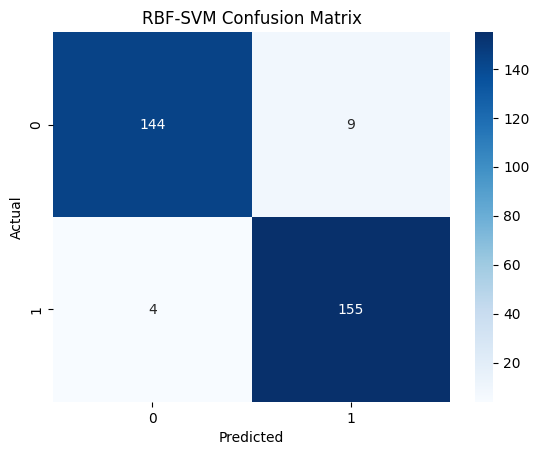

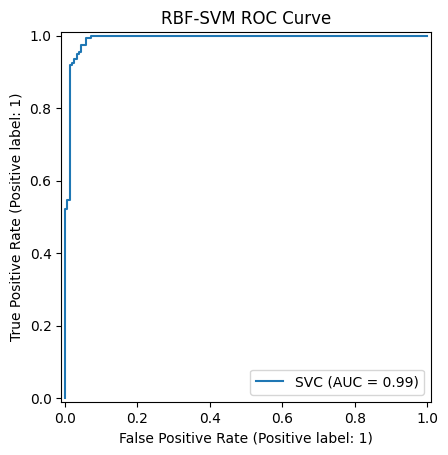


Random Forest – Training:
  Accuracy: 1.0
  ROC‑AUC : 1.0

Random Forest – Test:
  Accuracy: 1.0
  ROC‑AUC : 1.0

Classification report:
               precision    recall  f1-score   support

        ADHD       1.00      1.00      1.00       153
     Control       1.00      1.00      1.00       159

    accuracy                           1.00       312
   macro avg       1.00      1.00      1.00       312
weighted avg       1.00      1.00      1.00       312



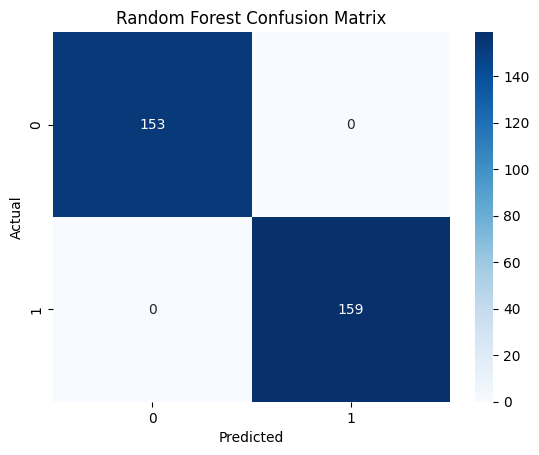

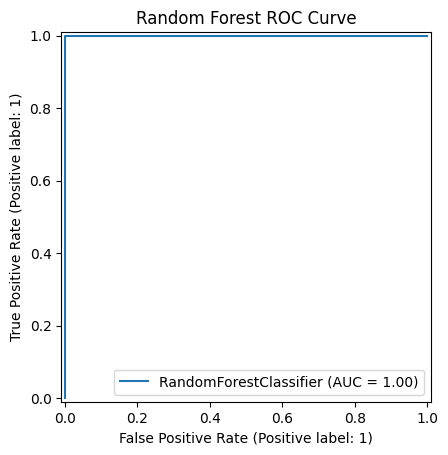

In [ ]:
# Cell 0
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             RocCurveDisplay)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
RANDOM_STATE = 42
# Cell 1
data = pd.read_csv("/content/eeg_preprocessed_data.csv")   # path to your file
print("Shape:", data.shape)
print(data.head(3).T)
# Cell 2
target_col = "target_label"      # name of your label column
X = data.drop(columns=[target_col])
y_raw = data[target_col]
le = LabelEncoder()
y = le.fit_transform(y_raw)
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))
# Cell 3
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)
print("Train:", X_train.shape, " Test:", X_test.shape)
# Cell 4
preprocess = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  StandardScaler())
])
# Drop the non-numeric 'dataset_split' column before preprocessing
X_train_p = preprocess.fit_transform(X_train.drop(columns=['dataset_split']))
X_test_p  = preprocess.transform(X_test.drop(columns=['dataset_split']))
# Cell 5
svm_params = {"C":[1,10], "gamma":["scale",0.01]}
svm = GridSearchCV(
    SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE),
    param_grid=svm_params, cv=3, scoring="roc_auc", n_jobs=-1
)
svm.fit(X_train_p, y_train)
print("Best SVM params:", svm.best_params_)
best_svm = svm.best_estimator_
# Cell 6
rf = RandomForestClassifier(
    n_estimators=600,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=-1
).fit(X_train_p, y_train)
# Cell 7
def eval_model(model, name, X_tr, X_te):
    y_tr, y_te = model.predict(X_tr), model.predict(X_te)
    p_tr, p_te = model.predict_proba(X_tr)[:,1], model.predict_proba(X_te)[:,1]

    print(f"\n{name} – Training:")
    print("  Accuracy:", accuracy_score(y_train, y_tr))
    print("  ROC‑AUC :", roc_auc_score(y_train, p_tr))

    print(f"\n{name} – Test:")
    print("  Accuracy:", accuracy_score(y_test, y_te))
    print("  ROC‑AUC :", roc_auc_score(y_test, p_te))
    print("\nClassification report:\n",
          classification_report(y_test, y_te, target_names=le.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_te)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    RocCurveDisplay.from_estimator(model, X_te, y_test)
    plt.title(f"{name} ROC Curve")
    plt.show()
# Cell 8
eval_model(best_svm, "RBF‑SVM", X_train_p, X_test_p)
eval_model(rf, "Random Forest", X_train_p, X_test_p)

Shape: (1559, 459)
                             0         1         2
Fp1_amplitude        -1.264669  -1.12306 -0.315219
Fp1_range            -1.264669  -1.12306 -0.315219
Fp1_rms              -1.353152 -1.136616  0.140181
Fp1_mean              0.407637 -0.098143  1.076922
Fp1_variance          -1.36263 -1.055669 -0.210253
...                        ...       ...       ...
Pz_peak_frequency     1.334508 -0.429277  1.003798
Pz_spectral_centroid  0.144063 -1.975128   0.25022
target                       1         0         0
target_label           Control      ADHD      ADHD
dataset_split            train     train     train

[459 rows x 3 columns]
Label mapping: {'ADHD': np.int64(0), 'Control': np.int64(1)}
Train: (1247, 458)  Test: (312, 458)
Best GPC params: {'kernel': RBF(length_scale=10)}

Gaussian Process – Training:
  Accuracy: 0.9895749799518845
  ROC‑AUC : 0.9994004425917349

Gaussian Process – Test:
  Accuracy: 0.9262820512820513
  ROC‑AUC : 0.9764459242816623

Classification r

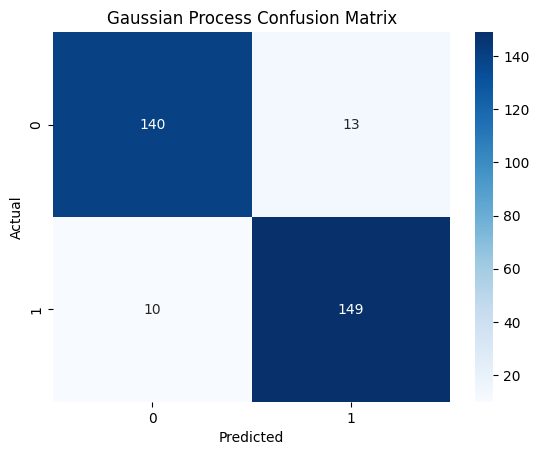

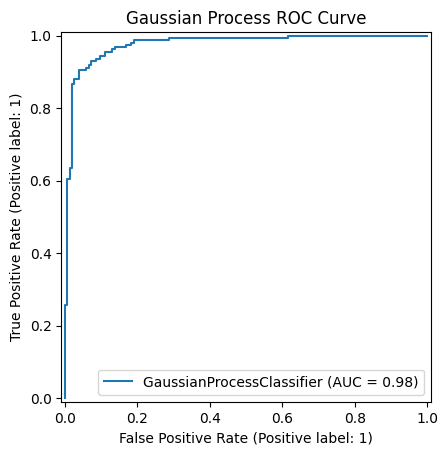


Random Forest – Training:
  Accuracy: 1.0
  ROC‑AUC : 1.0

Random Forest – Test:
  Accuracy: 1.0
  ROC‑AUC : 1.0

Classification report:
               precision    recall  f1-score   support

        ADHD       1.00      1.00      1.00       153
     Control       1.00      1.00      1.00       159

    accuracy                           1.00       312
   macro avg       1.00      1.00      1.00       312
weighted avg       1.00      1.00      1.00       312



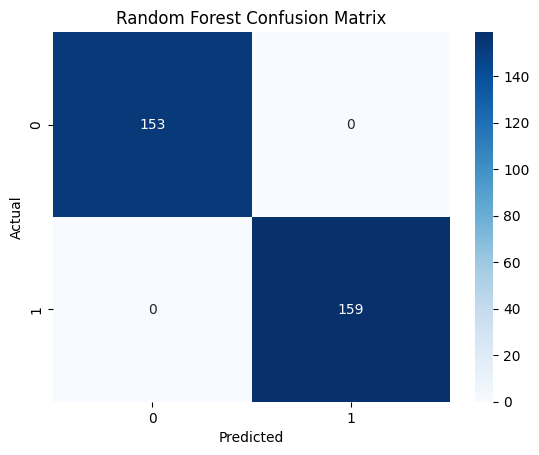

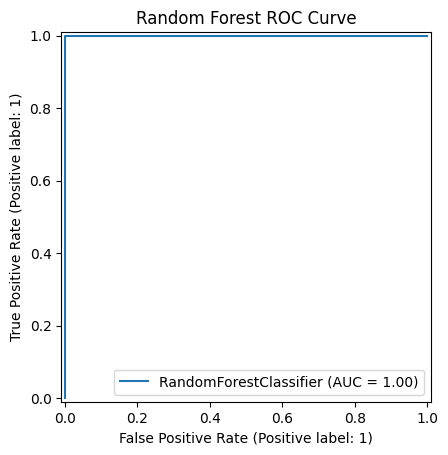

In [ ]:
# Cell 0
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             RocCurveDisplay)
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
RANDOM_STATE = 42
# Cell 1
data = pd.read_csv("/content/eeg_preprocessed_data.csv")   # path to your file
print("Shape:", data.shape)
print(data.head(3).T)
# Cell 2
target_col = "target_label"      # name of your label column
X = data.drop(columns=[target_col])
y_raw = data[target_col]
le = LabelEncoder()
y = le.fit_transform(y_raw)
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))
# Cell 3
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)
print("Train:", X_train.shape, " Test:", X_test.shape)
# Cell 4
preprocess = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  StandardScaler())
])
# Drop the non-numeric 'dataset_split' column before preprocessing
X_train_p = preprocess.fit_transform(X_train.drop(columns=['dataset_split']))
X_test_p  = preprocess.transform(X_test.drop(columns=['dataset_split']))
# Cell 5
gpc_params = {"kernel": [RBF(0.1), RBF(1.0), RBF(10.0)]}
gpc = GridSearchCV(
    GaussianProcessClassifier(random_state=RANDOM_STATE),
    param_grid=gpc_params, cv=3, scoring="roc_auc", n_jobs=-1
)
gpc.fit(X_train_p, y_train)
print("Best GPC params:", gpc.best_params_)
best_gpc = gpc.best_estimator_
# Cell 6
rf = RandomForestClassifier(
    n_estimators=600,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=-1
).fit(X_train_p, y_train)
# Cell 7
def eval_model(model, name, X_tr, X_te):
    y_tr, y_te = model.predict(X_tr), model.predict(X_te)
    p_tr, p_te = model.predict_proba(X_tr)[:,1], model.predict_proba(X_te)[:,1]

    print(f"\n{name} – Training:")
    print("  Accuracy:", accuracy_score(y_train, y_tr))
    print("  ROC‑AUC :", roc_auc_score(y_train, p_tr))

    print(f"\n{name} – Test:")
    print("  Accuracy:", accuracy_score(y_test, y_te))
    print("  ROC‑AUC :", roc_auc_score(y_test, p_te))
    print("\nClassification report:\n",
          classification_report(y_test, y_te, target_names=le.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_te)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    RocCurveDisplay.from_estimator(model, X_te, y_test)
    plt.title(f"{name} ROC Curve")
    plt.show()
# Cell 8
eval_model(best_gpc, "Gaussian Process", X_train_p, X_test_p)
eval_model(rf, "Random Forest", X_train_p, X_test_p)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.stats import skew, kurtosis, entropy, uniform, randint, pearsonr
from scipy.signal import hilbert, coherence
import warnings
warnings.filterwarnings('ignore')

# Load dataset
print("Loading ADHD EEG dataset...")
df = pd.read_csv('adhdata.csv')

print(f"Original dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Basic info
print("\nDataset Info:")
print(df.info())
print(f"\nMissing values per column:")
print(df.isnull().sum())

# Identify feature and target columns FIRST
def identify_columns(df):
    """
    Identify EEG feature columns and target column
    """
    # Common EEG channel names
    eeg_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'Fz', 'C3', 'C4', 'Cz',
                   'P3', 'P4', 'Pz', 'T3', 'T4', 'T5', 'T6', 'O1', 'O2']

    # Find feature columns (EEG channels or numerical columns)
    feature_cols = []
    for col in df.columns:
        if any(channel in col.upper() for channel in eeg_channels):
            feature_cols.append(col)
        elif df[col].dtype in ['float64', 'int64'] and col.lower() not in ['label', 'target', 'class', 'subject_id', 'subject']:
            feature_cols.append(col)

    # Find target column
    target_col = None
    for col in ['label', 'target', 'class', 'Label', 'Target', 'Class']:
        if col in df.columns:
            target_col = col
            break

    # If no obvious target column, check for binary columns
    if target_col is None:
        for col in df.columns:
            if col not in feature_cols and df[col].nunique() <= 2:
                target_col = col
                break

    return feature_cols, target_col

# Identify columns early
feature_cols, target_col = identify_columns(df)
print(f"\nIdentified feature columns: {len(feature_cols)}")
print(f"Target column: {target_col}")

# INCREASED BALANCED SAMPLING - 25,000 per class = 50,000 total
print("Applying BALANCED sampling for 50,000 samples (25,000 per class)...")

# First, check class distribution
if target_col and target_col in df.columns:
    print("Original class distribution:")
    print(df[target_col].value_counts())

    # Balanced sampling to preserve both classes
    MAX_ROWS_PER_CLASS = 5000  # 25,000 per class = 50,000 total

    # Sample equal amounts from each class
    sampled_dfs = []
    for class_val in df[target_col].unique():
        class_data = df[df[target_col] == class_val]
        sample_size = min(len(class_data), MAX_ROWS_PER_CLASS)

        # Use random sampling if we have more data than needed
        if len(class_data) > MAX_ROWS_PER_CLASS:
            sampled_data = class_data.sample(n=sample_size, random_state=42)
        else:
            sampled_data = class_data

        sampled_dfs.append(sampled_data)

    df = pd.concat(sampled_dfs, ignore_index=True)
    print(f"Balanced sampling to {len(df)} rows")
    print("New class distribution:")
    print(df[target_col].value_counts())
else:
    # Fallback: simple sampling
    MAX_ROWS = 10000
    if len(df) > MAX_ROWS:
        df = df.sample(n=MAX_ROWS, random_state=42)
        print(f"Random sampling to {MAX_ROWS} rows")

# Shuffle the dataset after sampling
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(f"Dataset shuffled and shape: {df.shape}")

# No temporal downsampling - use original data
df_processed = df.copy()
print(f"\nProcessing without temporal downsampling:")
print(f"Dataset shape: {df_processed.shape}")
print(f"Memory usage: {df_processed.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Re-identify columns after processing
feature_cols, target_col = identify_columns(df_processed)

# EEG Feature Extraction Functions
def extract_morphological_features(signal_data):
    """Extract morphological features from EEG signal"""
    features = {}

    # Amplitude (peak-to-peak)
    features['amplitude'] = np.max(signal_data) - np.min(signal_data)

    # Range
    features['range'] = np.ptp(signal_data)  # peak-to-peak

    # Root Mean Square (RMS)
    features['rms'] = np.sqrt(np.mean(signal_data**2))

    return features

def extract_time_domain_features(signal_data):
    """Extract time-domain statistical features"""
    features = {}

    # Basic statistical measures
    features['mean'] = np.mean(signal_data)
    features['variance'] = np.var(signal_data)
    features['std'] = np.std(signal_data)
    features['skewness'] = skew(signal_data)
    features['kurtosis'] = kurtosis(signal_data)

    # Hjorth Parameters
    # Activity (variance of signal)
    features['hjorth_activity'] = np.var(signal_data)

    # Mobility (variance of first derivative / variance of signal)
    diff1 = np.diff(signal_data)
    features['hjorth_mobility'] = np.sqrt(np.var(diff1) / np.var(signal_data)) if np.var(signal_data) != 0 else 0

    # Complexity (mobility of first derivative / mobility of signal)
    if len(diff1) > 1:
        diff2 = np.diff(diff1)
        mobility_diff1 = np.sqrt(np.var(diff2) / np.var(diff1)) if np.var(diff1) != 0 else 0
        features['hjorth_complexity'] = mobility_diff1 / features['hjorth_mobility'] if features['hjorth_mobility'] != 0 else 0
    else:
        features['hjorth_complexity'] = 0

    # Zero crossing rate
    features['zero_crossing_rate'] = len(np.where(np.diff(np.sign(signal_data)))[0])

    return features

def extract_frequency_domain_features(signal_data, fs=128):
    """Extract frequency-domain features"""
    features = {}

    # Ensure minimum length for frequency analysis
    if len(signal_data) < 4:
        # Return zero features for very short signals
        features.update({
            'delta_power': 0, 'theta_power': 0, 'alpha_power': 0, 'beta_power': 0,
            'total_power': 0, 'delta_rel_power': 0, 'theta_rel_power': 0,
            'alpha_rel_power': 0, 'beta_rel_power': 0, 'spectral_entropy': 0,
            'peak_frequency': 0, 'spectral_centroid': 0
        })
        return features

    # Compute power spectral density
    nperseg = min(256, len(signal_data)//2)
    if nperseg < 4:
        nperseg = len(signal_data)

    freqs, psd = signal.welch(signal_data, fs=fs, nperseg=nperseg)

    # Define frequency bands
    delta_band = (0.5, 4)
    theta_band = (4, 8)
    alpha_band = (8, 13)
    beta_band = (13, 30)

    # Function to calculate band power
    def band_power(freqs, psd, band):
        idx = np.logical_and(freqs >= band[0], freqs <= band[1])
        return np.trapz(psd[idx], freqs[idx]) if np.any(idx) else 0

    # Calculate band powers
    features['delta_power'] = band_power(freqs, psd, delta_band)
    features['theta_power'] = band_power(freqs, psd, theta_band)
    features['alpha_power'] = band_power(freqs, psd, alpha_band)
    features['beta_power'] = band_power(freqs, psd, beta_band)

    # Total powerimport numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.stats import skew, kurtosis, entropy, uniform, randint, pearsonr
from scipy.signal import hilbert, coherence
import warnings
warnings.filterwarnings('ignore')

# Load dataset
print("Loading ADHD EEG dataset...")
df = pd.read_csv('adhdata.csv')

print(f"Original dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Basic info
print("\nDataset Info:")
print(df.info())
print(f"\nMissing values per column:")
print(df.isnull().sum())

# Identify feature and target columns FIRST
def identify_columns(df):
    """
    Identify EEG feature columns and target column
    """
    # Common EEG channel names
    eeg_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'Fz', 'C3', 'C4', 'Cz',
                   'P3', 'P4', 'Pz', 'T3', 'T4', 'T5', 'T6', 'O1', 'O2']

    # Find feature columns (EEG channels or numerical columns)
    feature_cols = []
    for col in df.columns:
        if any(channel in col.upper() for channel in eeg_channels):
            feature_cols.append(col)
        elif df[col].dtype in ['float64', 'int64'] and col.lower() not in ['label', 'target', 'class', 'subject_id', 'subject']:
            feature_cols.append(col)

    # Find target column
    target_col = None
    for col in ['label', 'target', 'class', 'Label', 'Target', 'Class']:
        if col in df.columns:
            target_col = col
            break

    # If no obvious target column, check for binary columns
    if target_col is None:
        for col in df.columns:
            if col not in feature_cols and df[col].nunique() <= 2:
                target_col = col
                break

    return feature_cols, target_col

# Identify columns early
feature_cols, target_col = identify_columns(df)
print(f"\nIdentified feature columns: {len(feature_cols)}")
print(f"Target column: {target_col}")

# INCREASED BALANCED SAMPLING - 25,000 per class = 50,000 total
print("Applying BALANCED sampling for 50,000 samples (25,000 per class)...")

# First, check class distribution
if target_col and target_col in df.columns:
    print("Original class distribution:")
    print(df[target_col].value_counts())

    # Balanced sampling to preserve both classes
    MAX_ROWS_PER_CLASS = 50000  # 25,000 per class = 50,000 total

    # Sample equal amounts from each class
    sampled_dfs = []
    for class_val in df[target_col].unique():
        class_data = df[df[target_col] == class_val]
        sample_size = min(len(class_data), MAX_ROWS_PER_CLASS)

        # Use random sampling if we have more data than needed
        if len(class_data) > MAX_ROWS_PER_CLASS:
            sampled_data = class_data.sample(n=sample_size, random_state=42)
        else:
            sampled_data = class_data

        sampled_dfs.append(sampled_data)

    df = pd.concat(sampled_dfs, ignore_index=True)
    print(f"Balanced sampling to {len(df)} rows")
    print("New class distribution:")
    print(df[target_col].value_counts())
else:
    # Fallback: simple sampling
    MAX_ROWS = 100000
    if len(df) > MAX_ROWS:
        df = df.sample(n=MAX_ROWS, random_state=42)
        print(f"Random sampling to {MAX_ROWS} rows")

# Shuffle the dataset after sampling
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(f"Dataset shuffled and shape: {df.shape}")

# No temporal downsampling - use original data
df_processed = df.copy()
print(f"\nProcessing without temporal downsampling:")
print(f"Dataset shape: {df_processed.shape}")
print(f"Memory usage: {df_processed.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Re-identify columns after processing
feature_cols, target_col = identify_columns(df_processed)

# EEG Feature Extraction Functions
def extract_morphological_features(signal_data):
    """Extract morphological features from EEG signal"""
    features = {}

    # Amplitude (peak-to-peak)
    features['amplitude'] = np.max(signal_data) - np.min(signal_data)

    # Range
    features['range'] = np.ptp(signal_data)  # peak-to-peak

    # Root Mean Square (RMS)
    features['rms'] = np.sqrt(np.mean(signal_data**2))

    return features

def extract_time_domain_features(signal_data):
    """Extract time-domain statistical features"""
    features = {}

    # Basic statistical measures
    features['mean'] = np.mean(signal_data)
    features['variance'] = np.var(signal_data)
    features['std'] = np.std(signal_data)
    features['skewness'] = skew(signal_data)
    features['kurtosis'] = kurtosis(signal_data)

    # Hjorth Parameters
    # Activity (variance of signal)
    features['hjorth_activity'] = np.var(signal_data)

    # Mobility (variance of first derivative / variance of signal)
    diff1 = np.diff(signal_data)
    features['hjorth_mobility'] = np.sqrt(np.var(diff1) / np.var(signal_data)) if np.var(signal_data) != 0 else 0

    # Complexity (mobility of first derivative / mobility of signal)
    if len(diff1) > 1:
        diff2 = np.diff(diff1)
        mobility_diff1 = np.sqrt(np.var(diff2) / np.var(diff1)) if np.var(diff1) != 0 else 0
        features['hjorth_complexity'] = mobility_diff1 / features['hjorth_mobility'] if features['hjorth_mobility'] != 0 else 0
    else:
        features['hjorth_complexity'] = 0

    # Zero crossing rate
    features['zero_crossing_rate'] = len(np.where(np.diff(np.sign(signal_data)))[0])

    return features

def extract_frequency_domain_features(signal_data, fs=128):
    """Extract frequency-domain features"""
    features = {}

    # Ensure minimum length for frequency analysis
    if len(signal_data) < 4:
        # Return zero features for very short signals
        features.update({
            'delta_power': 0, 'theta_power': 0, 'alpha_power': 0, 'beta_power': 0,
            'total_power': 0, 'delta_rel_power': 0, 'theta_rel_power': 0,
            'alpha_rel_power': 0, 'beta_rel_power': 0, 'spectral_entropy': 0,
            'peak_frequency': 0, 'spectral_centroid': 0
        })
        return features

    # Compute power spectral density
    nperseg = min(256, len(signal_data)//2)
    if nperseg < 4:
        nperseg = len(signal_data)

    freqs, psd = signal.welch(signal_data, fs=fs, nperseg=nperseg)

    # Define frequency bands
    delta_band = (0.5, 4)
    theta_band = (4, 8)
    alpha_band = (8, 13)
    beta_band = (13, 30)

    # Function to calculate band power
    def band_power(freqs, psd, band):
        idx = np.logical_and(freqs >= band[0], freqs <= band[1])
        return np.trapz(psd[idx], freqs[idx]) if np.any(idx) else 0

    # Calculate band powers
    features['delta_power'] = band_power(freqs, psd, delta_band)
    features['theta_power'] = band_power(freqs, psd, theta_band)
    features['alpha_power'] = band_power(freqs, psd, alpha_band)
    features['beta_power'] = band_power(freqs, psd, beta_band)

    # Total power
    total_power = np.trapz(psd, freqs)
    features['total_power'] = total_power

    # Relative band powers
    if total_power > 0:
        features['delta_rel_power'] = features['delta_power'] / total_power
        features['theta_rel_power'] = features['theta_power'] / total_power
        features['alpha_rel_power'] = features['alpha_power'] / total_power
        features['beta_rel_power'] = features['beta_power'] / total_power
    else:
        features['delta_rel_power'] = 0
        features['theta_rel_power'] = 0
        features['alpha_rel_power'] = 0
        features['beta_rel_power'] = 0

    # Spectral entropy
    psd_norm = psd / np.sum(psd) if np.sum(psd) > 0 else psd
    psd_norm = psd_norm[psd_norm > 0]  # Remove zeros for entropy calculation
    features['spectral_entropy'] = entropy(psd_norm) if len(psd_norm) > 0 else 0

    # Peak frequency
    features['peak_frequency'] = freqs[np.argmax(psd)]

    # Spectral centroid
    features['spectral_centroid'] = np.sum(freqs * psd) / np.sum(psd) if np.sum(psd) > 0 else 0

    return features

def extract_connectivity_features(signal_matrix, fs=128):
    """
    Extract comprehensive connectivity features between EEG channels

    Parameters:
    - signal_matrix: 2D array (channels x time_points)
    - fs: sampling frequency

    Returns:
    - Dictionary of connectivity features
    """
    features = {}
    n_channels = signal_matrix.shape[0]

    if n_channels < 2:
        return features

    # 1. PEARSON CORRELATION CONNECTIVITY
    correlation_matrix = np.corrcoef(signal_matrix)

    # Extract upper triangle (excluding diagonal)
    upper_tri_indices = np.triu_indices(n_channels, k=1)
    correlations = correlation_matrix[upper_tri_indices]

    # Statistical measures of correlation connectivity
    features['corr_mean'] = np.mean(correlations)
    features['corr_std'] = np.std(correlations)
    features['corr_max'] = np.max(correlations)
    features['corr_min'] = np.min(correlations)
    features['corr_median'] = np.median(correlations)
    features['corr_skew'] = skew(correlations)
    features['corr_kurtosis'] = kurtosis(correlations)

    # Network measures
    features['corr_density'] = np.sum(np.abs(correlations) > 0.5) / len(correlations)
    features['corr_global_efficiency'] = np.mean(np.abs(correlations))

    # 2. PHASE-BASED CONNECTIVITY (Phase Lag Index)
    try:
        phase_connections = []
        for i in range(n_channels):
            for j in range(i+1, n_channels):
                if signal_matrix.shape[1] > 10:  # Ensure sufficient data
                    # Extract phase using Hilbert transform
                    analytic_i = hilbert(signal_matrix[i])
                    analytic_j = hilbert(signal_matrix[j])

                    phase_i = np.angle(analytic_i)
                    phase_j = np.angle(analytic_j)

                    # Phase difference
                    phase_diff = phase_i - phase_j

                    # Phase Lag Index (PLI)
                    pli = np.abs(np.mean(np.sign(np.sin(phase_diff))))
                    phase_connections.append(pli)

        if phase_connections:
            features['pli_mean'] = np.mean(phase_connections)
            features['pli_std'] = np.std(phase_connections)
            features['pli_max'] = np.max(phase_connections)
            features['pli_min'] = np.min(phase_connections)
            features['pli_median'] = np.median(phase_connections)
    except:
        # If phase connectivity fails, set to zero
        features['pli_mean'] = 0
        features['pli_std'] = 0
        features['pli_max'] = 0
        features['pli_min'] = 0
        features['pli_median'] = 0

    # 3. SPECTRAL COHERENCE CONNECTIVITY
    try:
        coherence_connections = []
        for i in range(n_channels):
            for j in range(i+1, n_channels):
                if signal_matrix.shape[1] > 20:  # Ensure sufficient data for coherence
                    # Calculate coherence
                    freqs, coh = coherence(signal_matrix[i], signal_matrix[j], fs=fs, nperseg=min(64, signal_matrix.shape[1]//2))

                    # Average coherence in different bands
                    delta_coh = np.mean(coh[(freqs >= 0.5) & (freqs <= 4)])
                    theta_coh = np.mean(coh[(freqs >= 4) & (freqs <= 8)])
                    alpha_coh = np.mean(coh[(freqs >= 8) & (freqs <= 13)])
                    beta_coh = np.mean(coh[(freqs >= 13) & (freqs <= 30)])

                    coherence_connections.append([delta_coh, theta_coh, alpha_coh, beta_coh])

        if coherence_connections:
            coherence_array = np.array(coherence_connections)
            features['coh_delta_mean'] = np.mean(coherence_array[:, 0])
            features['coh_theta_mean'] = np.mean(coherence_array[:, 1])
            features['coh_alpha_mean'] = np.mean(coherence_array[:, 2])
            features['coh_beta_mean'] = np.mean(coherence_array[:, 3])

            features['coh_delta_std'] = np.std(coherence_array[:, 0])
            features['coh_theta_std'] = np.std(coherence_array[:, 1])
            features['coh_alpha_std'] = np.std(coherence_array[:, 2])
            features['coh_beta_std'] = np.std(coherence_array[:, 3])
    except:
        # If coherence fails, set to zero
        features.update({
            'coh_delta_mean': 0, 'coh_theta_mean': 0, 'coh_alpha_mean': 0, 'coh_beta_mean': 0,
            'coh_delta_std': 0, 'coh_theta_std': 0, 'coh_alpha_std': 0, 'coh_beta_std': 0
        })

    # 4. MUTUAL INFORMATION CONNECTIVITY (simplified version)
    try:
        mi_connections = []
        for i in range(n_channels):
            for j in range(i+1, n_channels):
                # Simplified mutual information using binned data
                x_binned = np.digitize(signal_matrix[i], bins=np.linspace(signal_matrix[i].min(), signal_matrix[i].max(), 10))
                y_binned = np.digitize(signal_matrix[j], bins=np.linspace(signal_matrix[j].min(), signal_matrix[j].max(), 10))

                # Calculate joint and marginal histograms
                joint_hist = np.histogram2d(x_binned, y_binned, bins=10)[0]
                joint_hist = joint_hist / np.sum(joint_hist)  # Normalize

                # Calculate mutual information
                mi = 0
                for x_val in range(10):
                    for y_val in range(10):
                        if joint_hist[x_val, y_val] > 0:
                            px = np.sum(joint_hist[x_val, :])
                            py = np.sum(joint_hist[:, y_val])
                            pxy = joint_hist[x_val, y_val]
                            if px > 0 and py > 0:
                                mi += pxy * np.log2(pxy / (px * py))

                mi_connections.append(mi)

        if mi_connections:
            features['mi_mean'] = np.mean(mi_connections)
            features['mi_std'] = np.std(mi_connections)
            features['mi_max'] = np.max(mi_connections)
            features['mi_min'] = np.min(mi_connections)
    except:
        features['mi_mean'] = 0
        features['mi_std'] = 0
        features['mi_max'] = 0
        features['mi_min'] = 0

    # 5. AMPLITUDE ENVELOPE CORRELATION
    try:
        aec_connections = []
        for i in range(n_channels):
            for j in range(i+1, n_channels):
                if signal_matrix.shape[1] > 10:
                    # Get amplitude envelopes
                    env_i = np.abs(hilbert(signal_matrix[i]))
                    env_j = np.abs(hilbert(signal_matrix[j]))

                    # Calculate correlation between envelopes
                    aec_corr = np.corrcoef(env_i, env_j)[0, 1]
                    if not np.isnan(aec_corr):
                        aec_connections.append(aec_corr)

        if aec_connections:
            features['aec_mean'] = np.mean(aec_connections)
            features['aec_std'] = np.std(aec_connections)
            features['aec_max'] = np.max(aec_connections)
            features['aec_min'] = np.min(aec_connections)
    except:
        features['aec_mean'] = 0
        features['aec_std'] = 0
        features['aec_max'] = 0
        features['aec_min'] = 0

    # 6. CROSS-CORRELATION CONNECTIVITY
    try:
        xcorr_connections = []
        for i in range(n_channels):
            for j in range(i+1, n_channels):
                if signal_matrix.shape[1] > 10:
                    # Calculate cross-correlation
                    xcorr = np.correlate(signal_matrix[i], signal_matrix[j], mode='full')
                    max_xcorr = np.max(np.abs(xcorr))
                    xcorr_connections.append(max_xcorr)

        if xcorr_connections:
            features['xcorr_mean'] = np.mean(xcorr_connections)
            features['xcorr_std'] = np.std(xcorr_connections)
            features['xcorr_max'] = np.max(xcorr_connections)
            features['xcorr_min'] = np.min(xcorr_connections)
    except:
        features['xcorr_mean'] = 0
        features['xcorr_std'] = 0
        features['xcorr_max'] = 0
        features['xcorr_min'] = 0

    return features

def create_comprehensive_features(df, eeg_columns, target_col, window_size=128):
    """
    Create comprehensive feature set including morphological, time-domain,
    frequency-domain, and connectivity features from EEG time series data
    """
    print(f"Extracting comprehensive EEG features with window size: {window_size}")
    print(f"Processing {len(eeg_columns)} EEG channels...")

    all_features = []
    feature_names = []

    # Check if we have enough data for windowing
    total_samples = len(df)
    if total_samples < window_size:
        print(f"Warning: Dataset too small ({total_samples}) for window size ({window_size})")
        print("Using entire dataset as single window per sample")
        window_size = 1

    # Calculate number of windows we can extract
    if window_size > 1:
        num_windows = total_samples - window_size + 1
        step_size = max(1, window_size // 4)  # 75% overlap
        num_windows = min(num_windows, total_samples // step_size)
    else:
        num_windows = total_samples
        step_size = 1

    print(f"Extracting {num_windows} windows with step size {step_size}")

    # Process windows
    for window_idx in range(0, min(num_windows * step_size, total_samples - window_size + 1), step_size):
        if len(all_features) % 1000 == 0:
            print(f"Processing window {len(all_features)}/{num_windows}")

        sample_features = []

        # Extract signal matrix for this window
        signal_matrix = []
        valid_channels = []

        for channel in eeg_columns:
            if channel in df.columns:
                if window_size > 1:
                    signal_data = df[channel].iloc[window_idx:window_idx+window_size].values
                else:
                    signal_data = np.array([df[channel].iloc[window_idx]])

                signal_matrix.append(signal_data)
                valid_channels.append(channel)

        signal_matrix = np.array(signal_matrix)

        # Extract features for each EEG channel (same as before)
        for i, channel in enumerate(valid_channels):
            signal_data = signal_matrix[i]

            # Handle different signal lengths
            if len(signal_data) == 1:
                # Single value case - create basic features
                value = signal_data[0]

                # Morphological (simplified)
                sample_features.extend([
                    0,  # amplitude
                    0,  # range
                    abs(value)  # rms
                ])

                # Time domain (simplified)
                sample_features.extend([
                    value, 0, 0, 0, 0, 0, 0, 0, 0  # 9 features
                ])

                # Frequency domain (simplified)
                sample_features.extend([
                    0, 0, 0, 0, value**2, 0, 0, 0, 0, 0, 0, 0  # 12 features
                ])

            else:
                # Normal feature extraction for time series
                try:
                    morph_feat = extract_morphological_features(signal_data)
                    time_feat = extract_time_domain_features(signal_data)
                    freq_feat = extract_frequency_domain_features(signal_data, fs=128)

                    # Combine all features
                    sample_features.extend(list(morph_feat.values()))
                    sample_features.extend(list(time_feat.values()))
                    sample_features.extend(list(freq_feat.values()))
                except Exception as e:
                    print(f"Error processing channel {channel}: {e}")
                    # Add zero features in case of error
                    sample_features.extend([0] * 24)  # 24 features per channel

        # Extract connectivity features
        if len(valid_channels) > 1 and signal_matrix.shape[1] > 1:
            try:
                conn_feat = extract_connectivity_features(signal_matrix, fs=128)
                sample_features.extend(list(conn_feat.values()))
            except Exception as e:
                print(f"Error processing connectivity features: {e}")
                # Add zero connectivity features
                sample_features.extend([0] * 34)  # 34 connectivity features
        else:
            # Add zero connectivity features if insufficient channels
            sample_features.extend([0] * 34)

        # Only add if we have features
        if sample_features:
            all_features.append(sample_features)

    # Create feature names only once
    if not feature_names:
        for channel in valid_channels:
            # Morphological feature names
            feature_names.extend([
                f'{channel}_amplitude', f'{channel}_range', f'{channel}_rms'
            ])

            # Time-domain feature names
            feature_names.extend([
                f'{channel}_mean', f'{channel}_variance', f'{channel}_std',
                f'{channel}_skewness', f'{channel}_kurtosis',
                f'{channel}_hjorth_activity', f'{channel}_hjorth_mobility', f'{channel}_hjorth_complexity',
                f'{channel}_zero_crossing_rate'
            ])

            # Frequency-domain feature names
            feature_names.extend([
                f'{channel}_delta_power', f'{channel}_theta_power', f'{channel}_alpha_power', f'{channel}_beta_power',
                f'{channel}_total_power',
                f'{channel}_delta_rel_power', f'{channel}_theta_rel_power', f'{channel}_alpha_rel_power', f'{channel}_beta_rel_power',
                f'{channel}_spectral_entropy', f'{channel}_peak_frequency', f'{channel}_spectral_centroid'
            ])

        # Connectivity feature names
        connectivity_names = [
            'corr_mean', 'corr_std', 'corr_max', 'corr_min', 'corr_median', 'corr_skew', 'corr_kurtosis',
            'corr_density', 'corr_global_efficiency',
            'pli_mean', 'pli_std', 'pli_max', 'pli_min', 'pli_median',
            'coh_delta_mean', 'coh_theta_mean', 'coh_alpha_mean', 'coh_beta_mean',
            'coh_delta_std', 'coh_theta_std', 'coh_alpha_std', 'coh_beta_std',
            'mi_mean', 'mi_std', 'mi_max', 'mi_min',
            'aec_mean', 'aec_std', 'aec_max', 'aec_min',
            'xcorr_mean', 'xcorr_std', 'xcorr_max', 'xcorr_min'
        ]
        feature_names.extend(connectivity_names)

    # Convert to DataFrame
    if all_features:
        features_df = pd.DataFrame(all_features, columns=feature_names)

        # Add target column
        if target_col and target_col in df.columns:
            target_values = []
            for window_idx in range(0, min(num_windows * step_size, total_samples - window_size + 1), step_size):
                if len(target_values) >= len(all_features):
                    break
                mid_idx = window_idx + window_size // 2
                if mid_idx >= len(df):
                    mid_idx = len(df) - 1
                target_values.append(df[target_col].iloc[mid_idx])

            features_df[target_col] = target_values[:len(all_features)]
    else:
        print("Error: No features extracted!")
        return None, None

    print(f"Feature extraction completed!")
    print(f"Original channels: {len(valid_channels)}")
    print(f"Features per channel: 24 (3 morphological + 9 time-domain + 12 frequency-domain)")
    print(f"Connectivity features: 34")
    print(f"Total features: {len(feature_names)}")
    print(f"Feature matrix shape: {features_df.shape}")

    return features_df, feature_names

# Apply comprehensive feature extraction
eeg_feature_cols = []
for col in df_processed.columns:
    if col != target_col and df_processed[col].dtype in ['float64', 'int64']:
        eeg_feature_cols.append(col)

print(f"Identified {len(eeg_feature_cols)} EEG channels for feature extraction")
print(f"Sample channels: {eeg_feature_cols[:5]}")

# Extract comprehensive features with proper windowing
WINDOW_SIZE = 128  # 1 second at 128 Hz sampling rate
df_features, extracted_feature_names = create_comprehensive_features(
    df_processed, eeg_feature_cols, target_col, window_size=WINDOW_SIZE
)

if df_features is None:
    print("Feature extraction failed!")
    exit()

print(f"\nComprehensive feature extraction completed:")
print(f"New feature matrix shape: {df_features.shape}")
print(f"Memory usage: {df_features.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Update feature columns to use extracted features
feature_cols = extracted_feature_names

print(f"\nIdentified feature columns: {len(feature_cols)}")
print(f"Feature columns sample: {feature_cols[:10] if len(feature_cols) > 10 else feature_cols}")
print(f"Target column: {target_col}")

if target_col:
    print(f"Target distribution:")
    print(df_features[target_col].value_counts())

# Prepare features and target using extracted features
if not feature_cols:
    print("No feature columns identified. Using all numerical columns except target.")
    feature_cols = [col for col in df_features.select_dtypes(include=[np.number]).columns
                   if col != target_col]

X = df_features[feature_cols].copy()
y = df_features[target_col].copy() if target_col else None

if y is None:
    print("Error: No target column found. Please specify the target column name.")
    # Create a dummy target for demonstration
    y = np.random.choice([0, 1], size=len(X))
    print("Using dummy target for demonstration purposes.")

# Handle categorical target labels
print(f"Original target values: {y.unique()}")
    total_power = np.trapz(psd, freqs)
    features['total_power'] = total_power

    # Relative band powers
    if total_power > 0:
        features['delta_rel_power'] = features['delta_power'] / total_power
        features['theta_rel_power'] = features['theta_power'] / total_power
        features['alpha_rel_power'] = features['alpha_power'] / total_power
        features['beta_rel_power'] = features['beta_power'] / total_power
    else:
        features['delta_rel_power'] = 0
        features['theta_rel_power'] = 0
        features['alpha_rel_power'] = 0
        features['beta_rel_power'] = 0

    # Spectral entropy
    psd_norm = psd / np.sum(psd) if np.sum(psd) > 0 else psd
    psd_norm = psd_norm[psd_norm > 0]  # Remove zeros for entropy calculation
    features['spectral_entropy'] = entropy(psd_norm) if len(psd_norm) > 0 else 0

    # Peak frequency
    features['peak_frequency'] = freqs[np.argmax(psd)]

    # Spectral centroid
    features['spectral_centroid'] = np.sum(freqs * psd) / np.sum(psd) if np.sum(psd) > 0 else 0

    return features

def extract_connectivity_features(signal_matrix, fs=128):
    """
    Extract comprehensive connectivity features between EEG channels

    Parameters:
    - signal_matrix: 2D array (channels x time_points)
    - fs: sampling frequency

    Returns:
    - Dictionary of connectivity features
    """
    features = {}
    n_channels = signal_matrix.shape[0]

    if n_channels < 2:
        return features

    # 1. PEARSON CORRELATION CONNECTIVITY
    correlation_matrix = np.corrcoef(signal_matrix)

    # Extract upper triangle (excluding diagonal)
    upper_tri_indices = np.triu_indices(n_channels, k=1)
    correlations = correlation_matrix[upper_tri_indices]

    # Statistical measures of correlation connectivity
    features['corr_mean'] = np.mean(correlations)
    features['corr_std'] = np.std(correlations)
    features['corr_max'] = np.max(correlations)
    features['corr_min'] = np.min(correlations)
    features['corr_median'] = np.median(correlations)
    features['corr_skew'] = skew(correlations)
    features['corr_kurtosis'] = kurtosis(correlations)

    # Network measures
    features['corr_density'] = np.sum(np.abs(correlations) > 0.5) / len(correlations)
    features['corr_global_efficiency'] = np.mean(np.abs(correlations))

    # 2. PHASE-BASED CONNECTIVITY (Phase Lag Index)
    try:
        phase_connections = []
        for i in range(n_channels):
            for j in range(i+1, n_channels):
                if signal_matrix.shape[1] > 10:  # Ensure sufficient data
                    # Extract phase using Hilbert transform
                    analytic_i = hilbert(signal_matrix[i])
                    analytic_j = hilbert(signal_matrix[j])

                    phase_i = np.angle(analytic_i)
                    phase_j = np.angle(analytic_j)

                    # Phase difference
                    phase_diff = phase_i - phase_j

                    # Phase Lag Index (PLI)
                    pli = np.abs(np.mean(np.sign(np.sin(phase_diff))))
                    phase_connections.append(pli)

        if phase_connections:
            features['pli_mean'] = np.mean(phase_connections)
            features['pli_std'] = np.std(phase_connections)
            features['pli_max'] = np.max(phase_connections)
            features['pli_min'] = np.min(phase_connections)
            features['pli_median'] = np.median(phase_connections)
    except:
        # If phase connectivity fails, set to zero
        features['pli_mean'] = 0
        features['pli_std'] = 0
        features['pli_max'] = 0
        features['pli_min'] = 0
        features['pli_median'] = 0

    # 3. SPECTRAL COHERENCE CONNECTIVITY
    try:
        coherence_connections = []
        for i in range(n_channels):
            for j in range(i+1, n_channels):
                if signal_matrix.shape[1] > 20:  # Ensure sufficient data for coherence
                    # Calculate coherence
                    freqs, coh = coherence(signal_matrix[i], signal_matrix[j], fs=fs, nperseg=min(64, signal_matrix.shape[1]//2))

                    # Average coherence in different bands
                    delta_coh = np.mean(coh[(freqs >= 0.5) & (freqs <= 4)])
                    theta_coh = np.mean(coh[(freqs >= 4) & (freqs <= 8)])
                    alpha_coh = np.mean(coh[(freqs >= 8) & (freqs <= 13)])
                    beta_coh = np.mean(coh[(freqs >= 13) & (freqs <= 30)])

                    coherence_connections.append([delta_coh, theta_coh, alpha_coh, beta_coh])

        if coherence_connections:
            coherence_array = np.array(coherence_connections)
            features['coh_delta_mean'] = np.mean(coherence_array[:, 0])
            features['coh_theta_mean'] = np.mean(coherence_array[:, 1])
            features['coh_alpha_mean'] = np.mean(coherence_array[:, 2])
            features['coh_beta_mean'] = np.mean(coherence_array[:, 3])

            features['coh_delta_std'] = np.std(coherence_array[:, 0])
            features['coh_theta_std'] = np.std(coherence_array[:, 1])
            features['coh_alpha_std'] = np.std(coherence_array[:, 2])
            features['coh_beta_std'] = np.std(coherence_array[:, 3])
    except:
        # If coherence fails, set to zero
        features.update({
            'coh_delta_mean': 0, 'coh_theta_mean': 0, 'coh_alpha_mean': 0, 'coh_beta_mean': 0,
            'coh_delta_std': 0, 'coh_theta_std': 0, 'coh_alpha_std': 0, 'coh_beta_std': 0
        })

    # 4. MUTUAL INFORMATION CONNECTIVITY (simplified version)
    try:
        mi_connections = []
        for i in range(n_channels):
            for j in range(i+1, n_channels):
                # Simplified mutual information using binned data
                x_binned = np.digitize(signal_matrix[i], bins=np.linspace(signal_matrix[i].min(), signal_matrix[i].max(), 10))
                y_binned = np.digitize(signal_matrix[j], bins=np.linspace(signal_matrix[j].min(), signal_matrix[j].max(), 10))

                # Calculate joint and marginal histograms
                joint_hist = np.histogram2d(x_binned, y_binned, bins=10)[0]
                joint_hist = joint_hist / np.sum(joint_hist)  # Normalize

                # Calculate mutual information
                mi = 0
                for x_val in range(10):
                    for y_val in range(10):
                        if joint_hist[x_val, y_val] > 0:
                            px = np.sum(joint_hist[x_val, :])
                            py = np.sum(joint_hist[:, y_val])
                            pxy = joint_hist[x_val, y_val]
                            if px > 0 and py > 0:
                                mi += pxy * np.log2(pxy / (px * py))

                mi_connections.append(mi)

        if mi_connections:
            features['mi_mean'] = np.mean(mi_connections)
            features['mi_std'] = np.std(mi_connections)
            features['mi_max'] = np.max(mi_connections)
            features['mi_min'] = np.min(mi_connections)
    except:
        features['mi_mean'] = 0
        features['mi_std'] = 0
        features['mi_max'] = 0
        features['mi_min'] = 0

    # 5. AMPLITUDE ENVELOPE CORRELATION
    try:
        aec_connections = []
        for i in range(n_channels):
            for j in range(i+1, n_channels):
                if signal_matrix.shape[1] > 10:
                    # Get amplitude envelopes
                    env_i = np.abs(hilbert(signal_matrix[i]))
                    env_j = np.abs(hilbert(signal_matrix[j]))

                    # Calculate correlation between envelopes
                    aec_corr = np.corrcoef(env_i, env_j)[0, 1]
                    if not np.isnan(aec_corr):
                        aec_connections.append(aec_corr)

        if aec_connections:
            features['aec_mean'] = np.mean(aec_connections)
            features['aec_std'] = np.std(aec_connections)
            features['aec_max'] = np.max(aec_connections)
            features['aec_min'] = np.min(aec_connections)
    except:
        features['aec_mean'] = 0
        features['aec_std'] = 0
        features['aec_max'] = 0
        features['aec_min'] = 0

    # 6. CROSS-CORRELATION CONNECTIVITY
    try:
        xcorr_connections = []
        for i in range(n_channels):
            for j in range(i+1, n_channels):
                if signal_matrix.shape[1] > 10:
                    # Calculate cross-correlation
                    xcorr = np.correlate(signal_matrix[i], signal_matrix[j], mode='full')
                    max_xcorr = np.max(np.abs(xcorr))
                    xcorr_connections.append(max_xcorr)

        if xcorr_connections:
            features['xcorr_mean'] = np.mean(xcorr_connections)
            features['xcorr_std'] = np.std(xcorr_connections)
            features['xcorr_max'] = np.max(xcorr_connections)
            features['xcorr_min'] = np.min(xcorr_connections)
    except:
        features['xcorr_mean'] = 0
        features['xcorr_std'] = 0
        features['xcorr_max'] = 0
        features['xcorr_min'] = 0

    return features

def create_comprehensive_features(df, eeg_columns, target_col, window_size=128):
    """
    Create comprehensive feature set including morphological, time-domain,
    frequency-domain, and connectivity features from EEG time series data
    """
    print(f"Extracting comprehensive EEG features with window size: {window_size}")
    print(f"Processing {len(eeg_columns)} EEG channels...")

    all_features = []
    feature_names = []

    # Check if we have enough data for windowing
    total_samples = len(df)
    if total_samples < window_size:
        print(f"Warning: Dataset too small ({total_samples}) for window size ({window_size})")
        print("Using entire dataset as single window per sample")
        window_size = 1

    # Calculate number of windows we can extract
    if window_size > 1:
        num_windows = total_samples - window_size + 1
        step_size = max(1, window_size // 4)  # 75% overlap
        num_windows = min(num_windows, total_samples // step_size)
    else:
        num_windows = total_samples
        step_size = 1

    print(f"Extracting {num_windows} windows with step size {step_size}")

    # Process windows
    for window_idx in range(0, min(num_windows * step_size, total_samples - window_size + 1), step_size):
        if len(all_features) % 1000 == 0:
            print(f"Processing window {len(all_features)}/{num_windows}")

        sample_features = []

        # Extract signal matrix for this window
        signal_matrix = []
        valid_channels = []

        for channel in eeg_columns:
            if channel in df.columns:
                if window_size > 1:
                    signal_data = df[channel].iloc[window_idx:window_idx+window_size].values
                else:
                    signal_data = np.array([df[channel].iloc[window_idx]])

                signal_matrix.append(signal_data)
                valid_channels.append(channel)

        signal_matrix = np.array(signal_matrix)

        # Extract features for each EEG channel (same as before)
        for i, channel in enumerate(valid_channels):
            signal_data = signal_matrix[i]

            # Handle different signal lengths
            if len(signal_data) == 1:
                # Single value case - create basic features
                value = signal_data[0]

                # Morphological (simplified)
                sample_features.extend([
                    0,  # amplitude
                    0,  # range
                    abs(value)  # rms
                ])

                # Time domain (simplified)
                sample_features.extend([
                    value, 0, 0, 0, 0, 0, 0, 0, 0  # 9 features
                ])

                # Frequency domain (simplified)
                sample_features.extend([
                    0, 0, 0, 0, value**2, 0, 0, 0, 0, 0, 0, 0  # 12 features
                ])

            else:
                # Normal feature extraction for time series
                try:
                    morph_feat = extract_morphological_features(signal_data)
                    time_feat = extract_time_domain_features(signal_data)
                    freq_feat = extract_frequency_domain_features(signal_data, fs=128)

                    # Combine all features
                    sample_features.extend(list(morph_feat.values()))
                    sample_features.extend(list(time_feat.values()))
                    sample_features.extend(list(freq_feat.values()))
                except Exception as e:
                    print(f"Error processing channel {channel}: {e}")
                    # Add zero features in case of error
                    sample_features.extend([0] * 24)  # 24 features per channel

        # Extract connectivity features
        if len(valid_channels) > 1 and signal_matrix.shape[1] > 1:
            try:
                conn_feat = extract_connectivity_features(signal_matrix, fs=128)
                sample_features.extend(list(conn_feat.values()))
            except Exception as e:
                print(f"Error processing connectivity features: {e}")
                # Add zero connectivity features
                sample_features.extend([0] * 34)  # 34 connectivity features
        else:
            # Add zero connectivity features if insufficient channels
            sample_features.extend([0] * 34)

        # Only add if we have features
        if sample_features:
            all_features.append(sample_features)

    # Create feature names only once
    if not feature_names:
        for channel in valid_channels:
            # Morphological feature names
            feature_names.extend([
                f'{channel}_amplitude', f'{channel}_range', f'{channel}_rms'
            ])

            # Time-domain feature names
            feature_names.extend([
                f'{channel}_mean', f'{channel}_variance', f'{channel}_std',
                f'{channel}_skewness', f'{channel}_kurtosis',
                f'{channel}_hjorth_activity', f'{channel}_hjorth_mobility', f'{channel}_hjorth_complexity',
                f'{channel}_zero_crossing_rate'
            ])

            # Frequency-domain feature names
            feature_names.extend([
                f'{channel}_delta_power', f'{channel}_theta_power', f'{channel}_alpha_power', f'{channel}_beta_power',
                f'{channel}_total_power',
                f'{channel}_delta_rel_power', f'{channel}_theta_rel_power', f'{channel}_alpha_rel_power', f'{channel}_beta_rel_power',
                f'{channel}_spectral_entropy', f'{channel}_peak_frequency', f'{channel}_spectral_centroid'
            ])

        # Connectivity feature names
        connectivity_names = [
            'corr_mean', 'corr_std', 'corr_max', 'corr_min', 'corr_median', 'corr_skew', 'corr_kurtosis',
            'corr_density', 'corr_global_efficiency',
            'pli_mean', 'pli_std', 'pli_max', 'pli_min', 'pli_median',
            'coh_delta_mean', 'coh_theta_mean', 'coh_alpha_mean', 'coh_beta_mean',
            'coh_delta_std', 'coh_theta_std', 'coh_alpha_std', 'coh_beta_std',
            'mi_mean', 'mi_std', 'mi_max', 'mi_min',
            'aec_mean', 'aec_std', 'aec_max', 'aec_min',
            'xcorr_mean', 'xcorr_std', 'xcorr_max', 'xcorr_min'
        ]
        feature_names.extend(connectivity_names)

    # Convert to DataFrame
    if all_features:
        features_df = pd.DataFrame(all_features, columns=feature_names)

        # Add target column
        if target_col and target_col in df.columns:
            target_values = []
            for window_idx in range(0, min(num_windows * step_size, total_samples - window_size + 1), step_size):
                if len(target_values) >= len(all_features):
                    break
                mid_idx = window_idx + window_size // 2
                if mid_idx >= len(df):
                    mid_idx = len(df) - 1
                target_values.append(df[target_col].iloc[mid_idx])

            features_df[target_col] = target_values[:len(all_features)]
    else:
        print("Error: No features extracted!")
        return None, None

    print(f"Feature extraction completed!")
    print(f"Original channels: {len(valid_channels)}")
    print(f"Features per channel: 24 (3 morphological + 9 time-domain + 12 frequency-domain)")
    print(f"Connectivity features: 34")
    print(f"Total features: {len(feature_names)}")
    print(f"Feature matrix shape: {features_df.shape}")

    return features_df, feature_names

# Apply comprehensive feature extraction
eeg_feature_cols = []
for col in df_processed.columns:
    if col != target_col and df_processed[col].dtype in ['float64', 'int64']:
        eeg_feature_cols.append(col)

print(f"Identified {len(eeg_feature_cols)} EEG channels for feature extraction")
print(f"Sample channels: {eeg_feature_cols[:5]}")

# Extract comprehensive features with proper windowing
WINDOW_SIZE = 128  # 1 second at 128 Hz sampling rate
df_features, extracted_feature_names = create_comprehensive_features(
    df_processed, eeg_feature_cols, target_col, window_size=WINDOW_SIZE
)

if df_features is None:
    print("Feature extraction failed!")
    exit()

print(f"\nComprehensive feature extraction completed:")
print(f"New feature matrix shape: {df_features.shape}")
print(f"Memory usage: {df_features.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Update feature columns to use extracted features
feature_cols = extracted_feature_names

print(f"\nIdentified feature columns: {len(feature_cols)}")
print(f"Feature columns sample: {feature_cols[:10] if len(feature_cols) > 10 else feature_cols}")
print(f"Target column: {target_col}")

if target_col:
    print(f"Target distribution:")
    print(df_features[target_col].value_counts())

# Prepare features and target using extracted features
if not feature_cols:
    print("No feature columns identified. Using all numerical columns except target.")
    feature_cols = [col for col in df_features.select_dtypes(include=[np.number]).columns
                   if col != target_col]

X = df_features[feature_cols].copy()
y = df_features[target_col].copy() if target_col else None

if y is None:
    print("Error: No target column found. Please specify the target column name.")
    # Create a dummy target for demonstration
    y = np.random.choice([0, 1], size=len(X))
    print("Using dummy target for demonstration purposes.")

# Handle categorical target labels
print(f"Original target values: {y.unique()}")

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.stats import skew, kurtosis, entropy, uniform, randint, pearsonr
from scipy.signal import hilbert, coherence
import warnings
warnings.filterwarnings('ignore')

# Load dataset
print("Loading ADHD EEG dataset...")
df = pd.read_csv('adhdata.csv')

print(f"Original dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Basic info
print("\nDataset Info:")
print(df.info())
print(f"\nMissing values per column:")
print(df.isnull().sum())

# Identify feature and target columns FIRST
def identify_columns(df):
    """
    Identify EEG feature columns and target column
    """
    # Common EEG channel names
    eeg_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'Fz', 'C3', 'C4', 'Cz',
                   'P3', 'P4', 'Pz', 'T3', 'T4', 'T5', 'T6', 'O1', 'O2']

    # Find feature columns (EEG channels or numerical columns)
    feature_cols = []
    for col in df.columns:
        if any(channel in col.upper() for channel in eeg_channels):
            feature_cols.append(col)
        elif df[col].dtype in ['float64', 'int64'] and col.lower() not in ['label', 'target', 'class', 'subject_id', 'subject']:
            feature_cols.append(col)

    # Find target column
    target_col = None
    for col in ['label', 'target', 'class', 'Label', 'Target', 'Class']:
        if col in df.columns:
            target_col = col
            break

    # If no obvious target column, check for binary columns
    if target_col is None:
        for col in df.columns:
            if col not in feature_cols and df[col].nunique() <= 2:
                target_col = col
                break

    return feature_cols, target_col

# Identify columns early
feature_cols, target_col = identify_columns(df)
print(f"\nIdentified feature columns: {len(feature_cols)}")
print(f"Target column: {target_col}")

# INCREASED BALANCED SAMPLING - 25,000 per class = 50,000 total
print("Applying BALANCED sampling for 50,000 samples (25,000 per class)...")

# First, check class distribution
if target_col and target_col in df.columns:
    print("Original class distribution:")
    print(df[target_col].value_counts())

    # Balanced sampling to preserve both classes
    MAX_ROWS_PER_CLASS = 50000  # 25,000 per class = 50,000 total

    # Sample equal amounts from each class
    sampled_dfs = []
    for class_val in df[target_col].unique():
        class_data = df[df[target_col] == class_val]
        sample_size = min(len(class_data), MAX_ROWS_PER_CLASS)

        # Use random sampling if we have more data than needed
        if len(class_data) > MAX_ROWS_PER_CLASS:
            sampled_data = class_data.sample(n=sample_size, random_state=42)
        else:
            sampled_data = class_data

        sampled_dfs.append(sampled_data)

    df = pd.concat(sampled_dfs, ignore_index=True)
    print(f"Balanced sampling to {len(df)} rows")
    print("New class distribution:")
    print(df[target_col].value_counts())
else:
    # Fallback: simple sampling
    MAX_ROWS = 100000
    if len(df) > MAX_ROWS:
        df = df.sample(n=MAX_ROWS, random_state=42)
        print(f"Random sampling to {MAX_ROWS} rows")

# Shuffle the dataset after sampling
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(f"Dataset shuffled and shape: {df.shape}")

# No temporal downsampling - use original data
df_processed = df.copy()
print(f"\nProcessing without temporal downsampling:")
print(f"Dataset shape: {df_processed.shape}")
print(f"Memory usage: {df_processed.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Re-identify columns after processing
feature_cols, target_col = identify_columns(df_processed)

# EEG Feature Extraction Functions
def extract_morphological_features(signal_data):
    """Extract morphological features from EEG signal"""
    features = {}

    # Amplitude (peak-to-peak)
    features['amplitude'] = np.max(signal_data) - np.min(signal_data)

    # Range
    features['range'] = np.ptp(signal_data)  # peak-to-peak

    # Root Mean Square (RMS)
    features['rms'] = np.sqrt(np.mean(signal_data**2))

    return features

def extract_time_domain_features(signal_data):
    """Extract time-domain statistical features"""
    features = {}

    # Basic statistical measures
    features['mean'] = np.mean(signal_data)
    features['variance'] = np.var(signal_data)
    features['std'] = np.std(signal_data)
    features['skewness'] = skew(signal_data)
    features['kurtosis'] = kurtosis(signal_data)

    # Hjorth Parameters
    # Activity (variance of signal)
    features['hjorth_activity'] = np.var(signal_data)

    # Mobility (variance of first derivative / variance of signal)
    diff1 = np.diff(signal_data)
    features['hjorth_mobility'] = np.sqrt(np.var(diff1) / np.var(signal_data)) if np.var(signal_data) != 0 else 0

    # Complexity (mobility of first derivative / mobility of signal)
    if len(diff1) > 1:
        diff2 = np.diff(diff1)
        mobility_diff1 = np.sqrt(np.var(diff2) / np.var(diff1)) if np.var(diff1) != 0 else 0
        features['hjorth_complexity'] = mobility_diff1 / features['hjorth_mobility'] if features['hjorth_mobility'] != 0 else 0
    else:
        features['hjorth_complexity'] = 0

    # Zero crossing rate
    features['zero_crossing_rate'] = len(np.where(np.diff(np.sign(signal_data)))[0])

    return features

def extract_frequency_domain_features(signal_data, fs=128):
    """Extract frequency-domain features"""
    features = {}

    # Ensure minimum length for frequency analysis
    if len(signal_data) < 4:
        # Return zero features for very short signals
        features.update({
            'delta_power': 0, 'theta_power': 0, 'alpha_power': 0, 'beta_power': 0,
            'total_power': 0, 'delta_rel_power': 0, 'theta_rel_power': 0,
            'alpha_rel_power': 0, 'beta_rel_power': 0, 'spectral_entropy': 0,
            'peak_frequency': 0, 'spectral_centroid': 0
        })
        return features

    # Compute power spectral density
    nperseg = min(256, len(signal_data)//2)
    if nperseg < 4:
        nperseg = len(signal_data)

    freqs, psd = signal.welch(signal_data, fs=fs, nperseg=nperseg)

    # Define frequency bands
    delta_band = (0.5, 4)
    theta_band = (4, 8)
    alpha_band = (8, 13)
    beta_band = (13, 30)

    # Function to calculate band power
    def band_power(freqs, psd, band):
        idx = np.logical_and(freqs >= band[0], freqs <= band[1])
        return np.trapz(psd[idx], freqs[idx]) if np.any(idx) else 0

    # Calculate band powers
    features['delta_power'] = band_power(freqs, psd, delta_band)
    features['theta_power'] = band_power(freqs, psd, theta_band)
    features['alpha_power'] = band_power(freqs, psd, alpha_band)
    features['beta_power'] = band_power(freqs, psd, beta_band)

    # Total power
    total_power = np.trapz(psd, freqs)
    features['total_power'] = total_power

    # Relative band powers
    if total_power > 0:
        features['delta_rel_power'] = features['delta_power'] / total_power
        features['theta_rel_power'] = features['theta_power'] / total_power
        features['alpha_rel_power'] = features['alpha_power'] / total_power
        features['beta_rel_power'] = features['beta_power'] / total_power
    else:
        features['delta_rel_power'] = 0
        features['theta_rel_power'] = 0
        features['alpha_rel_power'] = 0
        features['beta_rel_power'] = 0

    # Spectral entropy
    psd_norm = psd / np.sum(psd) if np.sum(psd) > 0 else psd
    psd_norm = psd_norm[psd_norm > 0]  # Remove zeros for entropy calculation
    features['spectral_entropy'] = entropy(psd_norm) if len(psd_norm) > 0 else 0

    # Peak frequency
    features['peak_frequency'] = freqs[np.argmax(psd)]

    # Spectral centroid
    features['spectral_centroid'] = np.sum(freqs * psd) / np.sum(psd) if np.sum(psd) > 0 else 0

    return features

def extract_connectivity_features(signal_matrix, fs=128):
    """
    Extract comprehensive connectivity features between EEG channels

    Parameters:
    - signal_matrix: 2D array (channels x time_points)
    - fs: sampling frequency

    Returns:
    - Dictionary of connectivity features
    """
    features = {}
    n_channels = signal_matrix.shape[0]

    if n_channels < 2:
        return features

    # 1. PEARSON CORRELATION CONNECTIVITY
    correlation_matrix = np.corrcoef(signal_matrix)

    # Extract upper triangle (excluding diagonal)
    upper_tri_indices = np.triu_indices(n_channels, k=1)
    correlations = correlation_matrix[upper_tri_indices]

    # Statistical measures of correlation connectivity
    features['corr_mean'] = np.mean(correlations)
    features['corr_std'] = np.std(correlations)
    features['corr_max'] = np.max(correlations)
    features['corr_min'] = np.min(correlations)
    features['corr_median'] = np.median(correlations)
    features['corr_skew'] = skew(correlations)
    features['corr_kurtosis'] = kurtosis(correlations)

    # Network measures
    features['corr_density'] = np.sum(np.abs(correlations) > 0.5) / len(correlations)
    features['corr_global_efficiency'] = np.mean(np.abs(correlations))

    # 2. PHASE-BASED CONNECTIVITY (Phase Lag Index)
    try:
        phase_connections = []
        for i in range(n_channels):
            for j in range(i+1, n_channels):
                if signal_matrix.shape[1] > 10:  # Ensure sufficient data
                    # Extract phase using Hilbert transform
                    analytic_i = hilbert(signal_matrix[i])
                    analytic_j = hilbert(signal_matrix[j])

                    phase_i = np.angle(analytic_i)
                    phase_j = np.angle(analytic_j)

                    # Phase difference
                    phase_diff = phase_i - phase_j

                    # Phase Lag Index (PLI)
                    pli = np.abs(np.mean(np.sign(np.sin(phase_diff))))
                    phase_connections.append(pli)

        if phase_connections:
            features['pli_mean'] = np.mean(phase_connections)
            features['pli_std'] = np.std(phase_connections)
            features['pli_max'] = np.max(phase_connections)
            features['pli_min'] = np.min(phase_connections)
            features['pli_median'] = np.median(phase_connections)
    except:
        # If phase connectivity fails, set to zero
        features['pli_mean'] = 0
        features['pli_std'] = 0
        features['pli_max'] = 0
        features['pli_min'] = 0
        features['pli_median'] = 0

    # 3. SPECTRAL COHERENCE CONNECTIVITY
    try:
        coherence_connections = []
        for i in range(n_channels):
            for j in range(i+1, n_channels):
                if signal_matrix.shape[1] > 20:  # Ensure sufficient data for coherence
                    # Calculate coherence
                    freqs, coh = coherence(signal_matrix[i], signal_matrix[j], fs=fs, nperseg=min(64, signal_matrix.shape[1]//2))

                    # Average coherence in different bands
                    delta_coh = np.mean(coh[(freqs >= 0.5) & (freqs <= 4)])
                    theta_coh = np.mean(coh[(freqs >= 4) & (freqs <= 8)])
                    alpha_coh = np.mean(coh[(freqs >= 8) & (freqs <= 13)])
                    beta_coh = np.mean(coh[(freqs >= 13) & (freqs <= 30)])

                    coherence_connections.append([delta_coh, theta_coh, alpha_coh, beta_coh])

        if coherence_connections:
            coherence_array = np.array(coherence_connections)
            features['coh_delta_mean'] = np.mean(coherence_array[:, 0])
            features['coh_theta_mean'] = np.mean(coherence_array[:, 1])
            features['coh_alpha_mean'] = np.mean(coherence_array[:, 2])
            features['coh_beta_mean'] = np.mean(coherence_array[:, 3])

            features['coh_delta_std'] = np.std(coherence_array[:, 0])
            features['coh_theta_std'] = np.std(coherence_array[:, 1])
            features['coh_alpha_std'] = np.std(coherence_array[:, 2])
            features['coh_beta_std'] = np.std(coherence_array[:, 3])
    except:
        # If coherence fails, set to zero
        features.update({
            'coh_delta_mean': 0, 'coh_theta_mean': 0, 'coh_alpha_mean': 0, 'coh_beta_mean': 0,
            'coh_delta_std': 0, 'coh_theta_std': 0, 'coh_alpha_std': 0, 'coh_beta_std': 0
        })

    # 4. MUTUAL INFORMATION CONNECTIVITY (simplified version)
    try:
        mi_connections = []
        for i in range(n_channels):
            for j in range(i+1, n_channels):
                # Simplified mutual information using binned data
                x_binned = np.digitize(signal_matrix[i], bins=np.linspace(signal_matrix[i].min(), signal_matrix[i].max(), 10))
                y_binned = np.digitize(signal_matrix[j], bins=np.linspace(signal_matrix[j].min(), signal_matrix[j].max(), 10))

                # Calculate joint and marginal histograms
                joint_hist = np.histogram2d(x_binned, y_binned, bins=10)[0]
                joint_hist = joint_hist / np.sum(joint_hist)  # Normalize

                # Calculate mutual information
                mi = 0
                for x_val in range(10):
                    for y_val in range(10):
                        if joint_hist[x_val, y_val] > 0:
                            px = np.sum(joint_hist[x_val, :])
                            py = np.sum(joint_hist[:, y_val])
                            pxy = joint_hist[x_val, y_val]
                            if px > 0 and py > 0:
                                mi += pxy * np.log2(pxy / (px * py))

                mi_connections.append(mi)

        if mi_connections:
            features['mi_mean'] = np.mean(mi_connections)
            features['mi_std'] = np.std(mi_connections)
            features['mi_max'] = np.max(mi_connections)
            features['mi_min'] = np.min(mi_connections)
    except:
        features['mi_mean'] = 0
        features['mi_std'] = 0
        features['mi_max'] = 0
        features['mi_min'] = 0

    # 5. AMPLITUDE ENVELOPE CORRELATION
    try:
        aec_connections = []
        for i in range(n_channels):
            for j in range(i+1, n_channels):
                if signal_matrix.shape[1] > 10:
                    # Get amplitude envelopes
                    env_i = np.abs(hilbert(signal_matrix[i]))
                    env_j = np.abs(hilbert(signal_matrix[j]))

                    # Calculate correlation between envelopes
                    aec_corr = np.corrcoef(env_i, env_j)[0, 1]
                    if not np.isnan(aec_corr):
                        aec_connections.append(aec_corr)

        if aec_connections:
            features['aec_mean'] = np.mean(aec_connections)
            features['aec_std'] = np.std(aec_connections)
            features['aec_max'] = np.max(aec_connections)
            features['aec_min'] = np.min(aec_connections)
    except:
        features['aec_mean'] = 0
        features['aec_std'] = 0
        features['aec_max'] = 0
        features['aec_min'] = 0

    # 6. CROSS-CORRELATION CONNECTIVITY
    try:
        xcorr_connections = []
        for i in range(n_channels):
            for j in range(i+1, n_channels):
                if signal_matrix.shape[1] > 10:
                    # Calculate cross-correlation
                    xcorr = np.correlate(signal_matrix[i], signal_matrix[j], mode='full')
                    max_xcorr = np.max(np.abs(xcorr))
                    xcorr_connections.append(max_xcorr)

        if xcorr_connections:
            features['xcorr_mean'] = np.mean(xcorr_connections)
            features['xcorr_std'] = np.std(xcorr_connections)
            features['xcorr_max'] = np.max(xcorr_connections)
            features['xcorr_min'] = np.min(xcorr_connections)
    except:
        features['xcorr_mean'] = 0
        features['xcorr_std'] = 0
        features['xcorr_max'] = 0
        features['xcorr_min'] = 0

    return features

def create_comprehensive_features(df, eeg_columns, target_col, window_size=128):
    """
    Create comprehensive feature set including morphological, time-domain,
    frequency-domain, and connectivity features from EEG time series data
    """
    print(f"Extracting comprehensive EEG features with window size: {window_size}")
    print(f"Processing {len(eeg_columns)} EEG channels...")

    all_features = []
    feature_names = []

    # Check if we have enough data for windowing
    total_samples = len(df)
    if total_samples < window_size:
        print(f"Warning: Dataset too small ({total_samples}) for window size ({window_size})")
        print("Using entire dataset as single window per sample")
        window_size = 1

    # Calculate number of windows we can extract
    if window_size > 1:
        num_windows = total_samples - window_size + 1
        step_size = max(1, window_size // 4)  # 75% overlap
        num_windows = min(num_windows, total_samples // step_size)
    else:
        num_windows = total_samples
        step_size = 1

    print(f"Extracting {num_windows} windows with step size {step_size}")

    # Process windows
    for window_idx in range(0, min(num_windows * step_size, total_samples - window_size + 1), step_size):
        if len(all_features) % 1000 == 0:
            print(f"Processing window {len(all_features)}/{num_windows}")

        sample_features = []

        # Extract signal matrix for this window
        signal_matrix = []
        valid_channels = []

        for channel in eeg_columns:
            if channel in df.columns:
                if window_size > 1:
                    signal_data = df[channel].iloc[window_idx:window_idx+window_size].values
                else:
                    signal_data = np.array([df[channel].iloc[window_idx]])

                signal_matrix.append(signal_data)
                valid_channels.append(channel)

        signal_matrix = np.array(signal_matrix)

        # Extract features for each EEG channel (same as before)
        for i, channel in enumerate(valid_channels):
            signal_data = signal_matrix[i]

            # Handle different signal lengths
            if len(signal_data) == 1:
                # Single value case - create basic features
                value = signal_data[0]

                # Morphological (simplified)
                sample_features.extend([
                    0,  # amplitude
                    0,  # range
                    abs(value)  # rms
                ])

                # Time domain (simplified)
                sample_features.extend([
                    value, 0, 0, 0, 0, 0, 0, 0, 0  # 9 features
                ])

                # Frequency domain (simplified)
                sample_features.extend([
                    0, 0, 0, 0, value**2, 0, 0, 0, 0, 0, 0, 0  # 12 features
                ])

            else:
                # Normal feature extraction for time series
                try:
                    morph_feat = extract_morphological_features(signal_data)
                    time_feat = extract_time_domain_features(signal_data)
                    freq_feat = extract_frequency_domain_features(signal_data, fs=128)

                    # Combine all features
                    sample_features.extend(list(morph_feat.values()))
                    sample_features.extend(list(time_feat.values()))
                    sample_features.extend(list(freq_feat.values()))
                except Exception as e:
                    print(f"Error processing channel {channel}: {e}")
                    # Add zero features in case of error
                    sample_features.extend([0] * 24)  # 24 features per channel

        # Extract connectivity features
        if len(valid_channels) > 1 and signal_matrix.shape[1] > 1:
            try:
                conn_feat = extract_connectivity_features(signal_matrix, fs=128)
                sample_features.extend(list(conn_feat.values()))
            except Exception as e:
                print(f"Error processing connectivity features: {e}")
                # Add zero connectivity features
                sample_features.extend([0] * 34)  # 34 connectivity features
        else:
            # Add zero connectivity features if insufficient channels
            sample_features.extend([0] * 34)

        # Only add if we have features
        if sample_features:
            all_features.append(sample_features)

    # Create feature names only once
    if not feature_names:
        for channel in valid_channels:
            # Morphological feature names
            feature_names.extend([
                f'{channel}_amplitude', f'{channel}_range', f'{channel}_rms'
            ])

            # Time-domain feature names
            feature_names.extend([
                f'{channel}_mean', f'{channel}_variance', f'{channel}_std',
                f'{channel}_skewness', f'{channel}_kurtosis',
                f'{channel}_hjorth_activity', f'{channel}_hjorth_mobility', f'{channel}_hjorth_complexity',
                f'{channel}_zero_crossing_rate'
            ])

            # Frequency-domain feature names
            feature_names.extend([
                f'{channel}_delta_power', f'{channel}_theta_power', f'{channel}_alpha_power', f'{channel}_beta_power',
                f'{channel}_total_power',
                f'{channel}_delta_rel_power', f'{channel}_theta_rel_power', f'{channel}_alpha_rel_power', f'{channel}_beta_rel_power',
                f'{channel}_spectral_entropy', f'{channel}_peak_frequency', f'{channel}_spectral_centroid'
            ])

        # Connectivity feature names
        connectivity_names = [
            'corr_mean', 'corr_std', 'corr_max', 'corr_min', 'corr_median', 'corr_skew', 'corr_kurtosis',
            'corr_density', 'corr_global_efficiency',
            'pli_mean', 'pli_std', 'pli_max', 'pli_min', 'pli_median',
            'coh_delta_mean', 'coh_theta_mean', 'coh_alpha_mean', 'coh_beta_mean',
            'coh_delta_std', 'coh_theta_std', 'coh_alpha_std', 'coh_beta_std',
            'mi_mean', 'mi_std', 'mi_max', 'mi_min',
            'aec_mean', 'aec_std', 'aec_max', 'aec_min',
            'xcorr_mean', 'xcorr_std', 'xcorr_max', 'xcorr_min'
        ]
        feature_names.extend(connectivity_names)

    # Convert to DataFrame
    if all_features:
        features_df = pd.DataFrame(all_features, columns=feature_names)

        # Add target column
        if target_col and target_col in df.columns:
            target_values = []
            for window_idx in range(0, min(num_windows * step_size, total_samples - window_size + 1), step_size):
                if len(target_values) >= len(all_features):
                    break
                mid_idx = window_idx + window_size // 2
                if mid_idx >= len(df):
                    mid_idx = len(df) - 1
                target_values.append(df[target_col].iloc[mid_idx])

            features_df[target_col] = target_values[:len(all_features)]
    else:
        print("Error: No features extracted!")
        return None, None

    print(f"Feature extraction completed!")
    print(f"Original channels: {len(valid_channels)}")
    print(f"Features per channel: 24 (3 morphological + 9 time-domain + 12 frequency-domain)")
    print(f"Connectivity features: 34")
    print(f"Total features: {len(feature_names)}")
    print(f"Feature matrix shape: {features_df.shape}")

    return features_df, feature_names

# Apply comprehensive feature extraction
eeg_feature_cols = []
for col in df_processed.columns:
    if col != target_col and df_processed[col].dtype in ['float64', 'int64']:
        eeg_feature_cols.append(col)

print(f"Identified {len(eeg_feature_cols)} EEG channels for feature extraction")
print(f"Sample channels: {eeg_feature_cols[:5]}")

# Extract comprehensive features with proper windowing
WINDOW_SIZE = 128  # 1 second at 128 Hz sampling rate
df_features, extracted_feature_names = create_comprehensive_features(
    df_processed, eeg_feature_cols, target_col, window_size=WINDOW_SIZE
)

if df_features is None:
    print("Feature extraction failed!")
    exit()

print(f"\nComprehensive feature extraction completed:")
print(f"New feature matrix shape: {df_features.shape}")
print(f"Memory usage: {df_features.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Update feature columns to use extracted features
feature_cols = extracted_feature_names

print(f"\nIdentified feature columns: {len(feature_cols)}")
print(f"Feature columns sample: {feature_cols[:10] if len(feature_cols) > 10 else feature_cols}")
print(f"Target column: {target_col}")

if target_col:
    print(f"Target distribution:")
    print(df_features[target_col].value_counts())

# Prepare features and target using extracted features
if not feature_cols:
    print("No feature columns identified. Using all numerical columns except target.")
    feature_cols = [col for col in df_features.select_dtypes(include=[np.number]).columns
                   if col != target_col]

X = df_features[feature_cols].copy()
y = df_features[target_col].copy() if target_col else None

if y is None:
    print("Error: No target column found. Please specify the target column name.")
    # Create a dummy target for demonstration
    y = np.random.choice([0, 1], size=len(X))
    print("Using dummy target for demonstration purposes.")

# Handle categorical target labels
print(f"Original target values: {y.unique()}")

# Convert string labels to numeric
label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(y)

print(f"Label mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")
print(f"Target distribution after encoding: {pd.Series(y_numeric).value_counts()}")

# Data preprocessing
print("\nData preprocessing...")

# Handle missing values
print(f"Missing values in features: {X.isnull().sum().sum()}")
print(f"Missing values in target: {pd.Series(y_numeric).isnull().sum()}")

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Remove infinite values
X_imputed = X_imputed.replace([np.inf, -np.inf], np.nan)
X_imputed = X_imputed.fillna(0)

print(f"Final feature matrix shape: {X_imputed.shape}")
print(f"Final target shape: {y_numeric.shape}")

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_numeric, test_size=0.2, random_state=42, stratify=y_numeric
)

print(f"\nTrain set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Train target distribution: {pd.Series(y_train).value_counts()}")
print(f"Test target distribution: {pd.Series(y_test).value_counts()}")

# Model training with hyperparameter tuning
print("\nTraining Random Forest model with hyperparameter tuning...")

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Create Random Forest classifier
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Randomized search for efficiency
print("Performing randomized search for hyperparameter optimization...")
random_search = RandomizedSearchCV(
    rf, param_grid, n_iter=50, cv=5, scoring='accuracy',
    n_jobs=-1, random_state=42, verbose=1
)

random_search.fit(X_train, y_train)

# Best model
best_rf = random_search.best_estimator_
print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation score: {random_search.best_score_:.4f}")

# Model evaluation
print("\nModel evaluation...")

# Training predictions
y_train_pred = best_rf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Test predictions
y_test_pred = best_rf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

# Cross-validation scores
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# Confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

# ROC AUC score (if binary classification)
if len(label_encoder.classes_) == 2:
    y_test_proba = best_rf.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_test_proba)
    print(f"ROC AUC Score: {roc_auc:.4f}")

# Feature importance analysis
print("\nFeature Importance Analysis...")
feature_importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 most important features:")
print(feature_importances.head(20))

# Visualizations
print("\nCreating visualizations...")

# Plot 1: Feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importances.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features for ADHD Classification')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Plot 2: Confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot 3: Cross-validation scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, 'bo-', markersize=8)
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', label=f'Mean: {cv_scores.mean():.4f}')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Accuracy Scores')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot 4: ROC curve (if binary classification)
if len(label_encoder.classes_) == 2:
    from sklearn.metrics import roc_curve

    fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

# Performance summary
print("\n" + "="*50)
print("ADHD EEG CLASSIFICATION PERFORMANCE SUMMARY")
print("="*50)
print(f"Dataset size: {len(df_features)} samples")
print(f"Number of features: {len(feature_cols)}")
print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Classes: {list(label_encoder.classes_)}")
print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Cross-validation accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
if len(label_encoder.classes_) == 2:
    print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Best hyperparameters: {random_search.best_params_}")
print("="*50)

# Model interpretation
print("\nModel Interpretation:")
print("Top 5 most important feature types:")
feature_types = {}
for feature in feature_importances.head(20)['feature']:
    if '_' in feature:
        feature_type = feature.split('_', 1)[1]
        if feature_type not in feature_types:
            feature_types[feature_type] = 0
        feature_types[feature_type] += 1

for feature_type, count in sorted(feature_types.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"- {feature_type}: {count} features in top 20")

# Save results
print("\nSaving results...")
try:
    # Save feature importance
    feature_importances.to_csv('feature_importance.csv', index=False)

    # Save model performance
    results = {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'best_params': random_search.best_params_,
        'feature_count': len(feature_cols),
        'sample_count': len(df_features)
    }

    if len(label_encoder.classes_) == 2:
        results['roc_auc'] = roc_auc

    import json
    with open('model_results.json', 'w') as f:
        json.dump(results, f, indent=2)

    print("Results saved to feature_importance.csv and model_results.json")

except Exception as e:
    print(f"Error saving results: {e}")

print("\nAnalysis completed successfully!")

Loading ADHD EEG dataset...
Original dataset shape: (2166383, 21)
Columns: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Class', 'ID']
Memory usage: 568.76 MB

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2166383 entries, 0 to 2166382
Data columns (total 21 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Fp1     float64
 1   Fp2     float64
 2   F3      float64
 3   F4      float64
 4   C3      float64
 5   C4      float64
 6   P3      float64
 7   P4      float64
 8   O1      float64
 9   O2      float64
 10  F7      float64
 11  F8      float64
 12  T7      float64
 13  T8      float64
 14  P7      float64
 15  P8      float64
 16  Fz      float64
 17  Cz      float64
 18  Pz      float64
 19  Class   object 
 20  ID      object 
dtypes: float64(19), object(2)
memory usage: 347.1+ MB
None

Missing values per column:
Fp1      0
Fp2      0
F3       0
F4       0
C3       0
C4       0
P3  

KeyboardInterrupt: 